## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
import numpy as np
import pandas as pd

import scipy.stats as scs

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as scs
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

target= 'price'

In [2]:
a=.05
np.array(list(range(1,20)))/20


array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

### Custom Function

In [3]:
def kfolds(data, k):
    #Force data as pandas dataframe
    data = pd.DataFrame(data)
    num_observations = len(data)
    fold_size = num_observations//k
    leftovers = num_observations%k
    folds = []
    start_obs = 0
    for fold_n in range(1,k+1):
        if fold_n <= leftovers:
            #Fold Size will be 1 larger to account for leftovers
            fold =  data.iloc[start_obs : start_obs+fold_size+1] 
            folds.append(fold)
            start_obs +=  fold_size + 1
        else:
            fold =  data.iloc[start_obs : start_obs+fold_size] 
            folds.append(fold)
            start_obs +=  fold_size
            
    return folds 

def resd_check(results, data, column):
    a=results.resid/results.resid.std()
    a = a.loc[a.abs() > 2]
    
    
    plt.figure(figsize= (13,8))
    sns.distplot(data[column].iloc[a.index])
    sns.distplot(data[column])
    plt.title('Checking Dist. Initial v. High,\n'+column)
    return

def binning_count(data_series, bins): # binning  numerical features
    data_series = data_series.astype(float)
    bins_rad = pd.cut(data_series, bins)
    print(bins_rad.isna().sum())
    bins_rad = bins_rad.cat.as_ordered()
    bins_rad = bins_rad.sort_values()
    return bins_rad.value_counts()

def binning(data_series, bins):
    data_series = data_series.astype(float)
    return pd.cut(data_series, bins)

def flip_diff(dataframe, column):
    dataout=[]
    id_ = None
    previous_index = None
    for value in dataframe.id.unique():
            for index in dataframe.loc[dataframe.id == value].index:
                
                if id_ == dataframe.id.loc[index]:
                    dataout.append(dataframe[column].loc[index] - dataframe[column].loc[previous_index])
                else:
                    dataout.append(np.nan)
                id_ = dataframe.id.loc[index]
                previous_index=index
    return dataout

#mean normalization
def mean_norm(dataseries):
    return (dataseries-dataseries.mean())/(dataseries.max()- dataseries.min())

#min-max scaling
def min_max(dataseries):
    return (dataseries-dataseries.min())/(dataseries.max()- dataseries.min())

def make_heatmap(data, columns=None, figsize=(20, 20)):
    if columns is None:
        corr = data.corr()
    else:
        corr = datadf[columns].corr()
    plt.figure(figsize=figsize)
    sns.heatmap(np.abs(corr), cmap=sns.color_palette('Blues'), annot=True, fmt='0.2g')
    plt.show()
    
def make_ols_model(df, target='price', columns_to_use=None, add_constant=True):
    
    # just build a model and see the output

    X = df[columns_to_use]
    y = df[target]

    # add a constant to my X
    if add_constant:
        X = sm.add_constant(X)
    
    ols = sm.OLS(y, X)
    results = ols.fit()
    print(results.summary())
    return ols, results

def scat_plot(data, column, target= 'price'):
    plt.figure(figsize= (13, 8))
    sns.scatterplot(x= data[column], y= data[target])

def bar_hist_plot(dataseries):
    plt.figure(figsize= (13, 8))
    a=dataseries.value_counts(sort=False);
    a.sort_index().plot(kind= 'barh')

def viol_plot(data, column, target= 'price'):
    plt.figure(figsize= (13, 8))
    sns.violinplot(x=column, y=target, data= data)

def equal_bin(dataseries):
    return [dataseries.min()-.01, dataseries.quantile(.25), dataseries.quantile(.5), 
            dataseries.quantile(.75), dataseries.max()]

def equal_bin10(dataseries, quantile_step=10):
    
    a = [dataseries.min()-.01]
    
    for quant in np.array(list(range(1,quantile_step)))/quantile_step:
        a.append(dataseries.quantile(quant))
    a.append(dataseries.max())  
    return a

def viol2(x, y):
    plt.figure(figsize= (13, 8))
    sns.violinplot(x=x, y=y)
    

### Gather Data

In [4]:
data = pd.read_csv('kc_house_data.csv')


In [5]:
data.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view     ...      grade  sqft_above  \
0      5650     1.0         NaN   0.0     ...          7        1180   
1      7242     2.0         0.0   0.0     ...          7        2170   
2     10000     1.0         0.0   0.0     ...          6         770   
3      5000     1.0         0.0   0.0     ...          7        1050   
4      8080     1.0         0.0   0.0     ...          8        1680   

   sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
0            0.0     1955           0.0    98178  47.5112 -122.257   
1          400.0     1951        1991.0    98125  47.7210 -122.319   
2            0.0     1933           NaN    98028  47.7379 -122.233   
3          910.0     1965           0.0    98136  47.5208 -122.393   
4            0.0     1987           0.0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503  

[5 rows x 21 columns]

In [6]:
data.info()
#  date, sqft_basement contain string a n

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [7]:
data.describe()
#'date' 'sqft_basement' not included.

id         price      bedrooms     bathrooms   sqft_living  \
count  2.159700e+04  2.159700e+04  21597.000000  21597.000000  21597.000000   
mean   4.580474e+09  5.402966e+05      3.373200      2.115826   2080.321850   
std    2.876736e+09  3.673681e+05      0.926299      0.768984    918.106125   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.159700e+04  21597.000000  19221.000000  21534.000000  21597.000000   
mean   1.509941e+04      1.494096      0.007596      0.233863      3.409825   
std    4.141264e+04      0.539683      0.086825      0.765686      0.650546   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.040000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.618000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.068500e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above      yr_built  yr_renovated       zipcode  \
count  21597.000000  21597.000000  21597.000000  17755.000000  21597.000000   
mean       7.657915   1788.596842   1970.999676     83.636778  98077.951845   
std        1.173200    827.759761     29.375234    399.946414     53.513072   
min        3.000000    370.000000   1900.000000      0.000000  98001.000000   
25%        7.000000   1190.000000   1951.000000      0.000000  98033.000000   
50%        7.000000   1560.000000   1975.000000      0.000000  98065.000000   
75%        8.000000   2210.000000   1997.000000      0.000000  98118.000000   
max       13.000000   9410.000000   2015.000000   2015.000000  98199.000000   

                lat          long  sqft_living15     sqft_lot15  
count  21597.000000  21597.000000   21597.000000   21597.000000  
mean      47.560093   -122.213982    1986.620318   12758.283512  
std        0.138552      0.140724     685.230472   27274.441950  
min       47.155900   -122.519000     399.000000     651.000000  
25%       47.471100   -122.328000    1490.000000    5100.000000  
50%       47.571800   -122.231000    1840.000000    7620.000000  
75%       47.678000   -122.125000    2360.000000   10083.000000  
max       47.777600   -121.315000    6210.000000  871200.000000

### Scrubbing the Data
Cleaning null values and placeholders

#### date
Convert string values to datetime64 format (yyyy-mm-dd)

In [8]:
data.date=pd.to_datetime(data.date)

#### sqft_basement
Changing 0 and ? to NaN

In [9]:
a=data.sqft_basement.replace(to_replace= '?',value= np.nan)
a= a.astype(float)
data.sqft_basement= a.replace(to_replace= 0, value= np.nan)
data.sqft_basement=data.sqft_basement.fillna(value=0)
data.sqft_basement.describe()

count    21597.000000
mean       285.716581
std        439.819830
min          0.000000
25%          0.000000
50%          0.000000
75%        550.000000
max       4820.000000
Name: sqft_basement, dtype: float64

#### Used yr_built to make age

In [10]:
data['age'] = 2015- data.yr_built


#### yr_renovated 
Changing 0 to NaN  


In [11]:
data.yr_renovated = data.yr_renovated.replace(to_replace= 0, value= np.nan)

#### Using yr_renovated to make since_ren

In [12]:
data['since_ren'] = 2015- data.yr_renovated 

#### waterfront
Changing waterfront to NaN to 0.

In [13]:
data.waterfront = data.waterfront.fillna(value = 0)


#### view
Changing Nan values to 0

In [14]:
data.view = data.view.fillna(value= 0)

#### sqft_basement
Change NaN values to 0

In [15]:
data.sqft_basement = data.sqft_basement.fillna(value= 0)

#### yr_renovated
Change NaN values to 0

In [16]:
data.yr_renovated = data.yr_renovated.fillna(value= 0)

#### since_ren
Change NaN values to 0

In [17]:
data.since_ren = data.since_ren.fillna(value= 0)

#### renovated
Binary 0 or 1 (yes)

In [18]:
#data['renovated'] = data.yr_renovated
data['renovated']=data.yr_renovated.loc[data.yr_renovated != 0]/data.yr_renovated.loc[data.yr_renovated != 0]
data.renovated = data.renovated.fillna(value= 0)

In [19]:
data.grade.unique()

array([ 7,  6,  8, 11,  9,  5, 10, 12,  4,  3, 13], dtype=int64)

In [20]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'age', 'since_ren',
       'renovated'],
      dtype='object')

#### month

In [21]:
data['month'] = data.date.dt.month

#### Creating a Possible Flipped Sale Database
We identified 177 resales of property that were sold in the period of study. We two meanful features:

change_date  The days between sales.

change_price The cost differential between the previous sale and current sale price.

Condition and grade were examined, but there was no change between any of the sales.

In [22]:
multiple = data.id.value_counts()
len(multiple.loc[multiple > 1])
resales = len(multiple.loc[multiple > 1])
# 176, The number of time a home has been resold in the time period.
resales/ len(data.id)
# Far less then 1% of homes have been sold in the time period.
multiple = multiple.loc[multiple > 1]
multiple = multiple.to_dict()
data['num_sales'] = data.id.map(multiple)
data['num_sales'] = data['num_sales'].fillna(1)
flip = data.loc[data.num_sales > 1]
data = data.drop(columns= 'num_sales')
flip = flip.sort_values('date')

# adding new column examine. 
flip['change_date'] = flip_diff(flip, 'date')

#flip = flip.change_date.apply(lambda x: x.days)      

flip['change_price'] = flip_diff(flip, 'price')

# Removing initial sales
flip = flip.dropna()

# converting timedelta to days
flip.change_date = flip.change_date.apply(lambda x: x.days)

# 
flip['percent_change'] = flip.change_price/(flip.price- flip.change_price)

### Data Condition

binning values, playing with null values, normalizing data, standardizing data
manipulating data to fit OLS assumptions
Grouping data to create categories that might make sense for your data

#### id
Unique identified for a house. 
Although not valuable for predictive modeling, the feature id homes that have been sold multiple times.

In [23]:

multiple = data.id.value_counts()
len(multiple.loc[multiple > 1])
resales = len(multiple.loc[multiple > 1])
# 176, The number of time a home has been resold in the time period.
print(resales)


176


In [24]:
# Far less then 1% of homes have been sold in the time period.
resales/ len(data.id)  

0.008149279992591563

#### date
The date  the house was sold. The initial value was a string value. The information was convert to a date. See Data Scrubbing section for more information.



In [25]:
print(data.date.min(),'-',data.date.max())


2014-05-02 00:00:00 - 2015-05-27 00:00:00


In [26]:
data.date.value_counts().sort_index()

2014-05-02     67
2014-05-03      4
2014-05-04      5
2014-05-05     84
2014-05-06     83
2014-05-07     93
2014-05-08     81
2014-05-09     81
2014-05-10      5
2014-05-11      2
2014-05-12     80
2014-05-13     86
2014-05-14     81
2014-05-15     82
2014-05-16     73
2014-05-17      1
2014-05-18      7
2014-05-19     83
2014-05-20    116
2014-05-21     94
2014-05-22     91
2014-05-23     84
2014-05-24     11
2014-05-25      5
2014-05-26      8
2014-05-27    104
2014-05-28    111
2014-05-29     75
2014-05-30     65
2014-05-31      6
             ... 
2015-04-18      5
2015-04-19      6
2015-04-20     77
2015-04-21    119
2015-04-22    121
2015-04-23    110
2015-04-24    103
2015-04-25     16
2015-04-26     13
2015-04-27    126
2015-04-28    121
2015-04-29    113
2015-04-30     83
2015-05-01     77
2015-05-02      6
2015-05-03     10
2015-05-04    102
2015-05-05     94
2015-05-06     88
2015-05-07     76
2015-05-08     54
2015-05-09      3
2015-05-10      2
2015-05-11     40
2015-05-12

The date range is 5/2/2014 to 5/27/2015

#### bedrooms
Number of Bedrooms/House
The initial values ranged from 1 to 33 bedrooms, but there are very fews value over 6. 


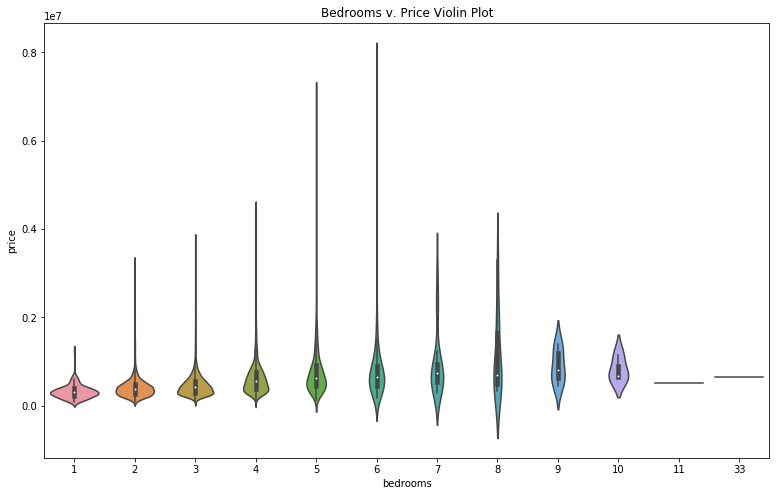

In [27]:
plt.figure(figsize= (13, 8))
sns.violinplot(x='bedrooms', y='price', data= data)
plt.title('Bedrooms v. Price Violin Plot');

#### Bedrooms v. Price Violin Plot
-skewed to data in all categories

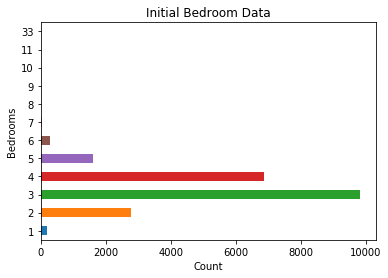

In [28]:
a=data.bedrooms.value_counts(sort=False);
a.sort_index().plot(kind= 'barh')
plt.title('Initial Bedroom Data');
plt.xlabel('Count');
plt.ylabel('Bedrooms');


#### bathrooms
Number of bathrooms/bedrooms


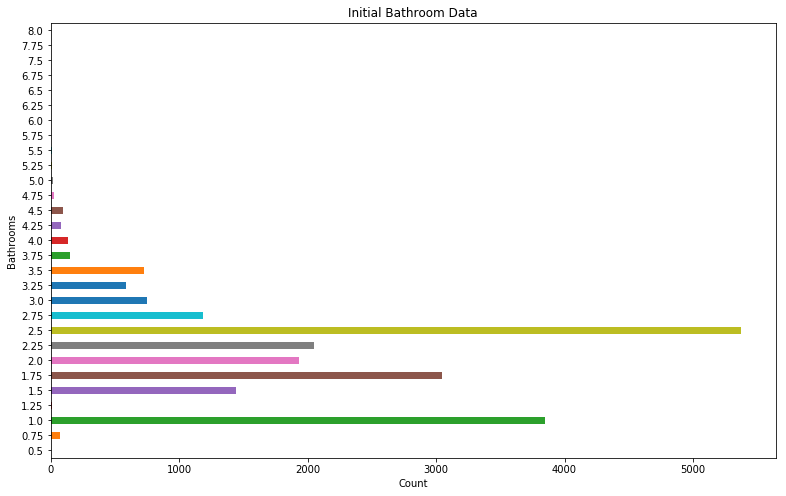

In [29]:
a=data.bathrooms.value_counts(sort=False);
plt.figure(figsize= (13, 8))
a.sort_index().plot(kind= 'barh')
plt.title('Initial Bathroom Data');
plt.xlabel('Count');
plt.ylabel('Bathrooms');

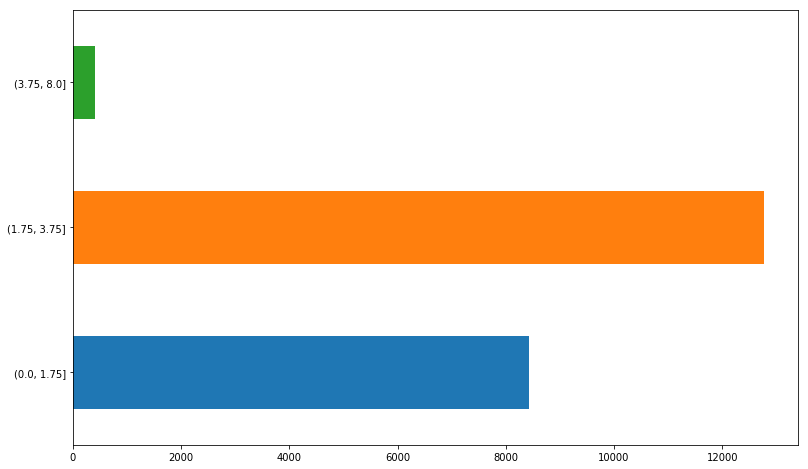

In [315]:
bins = [0, 1.75, 3.75, 8.0]
data['bin_bathrooms'] = binning(data['bathrooms'], bins)
bar_hist_plot(data['bin_bathrooms'])

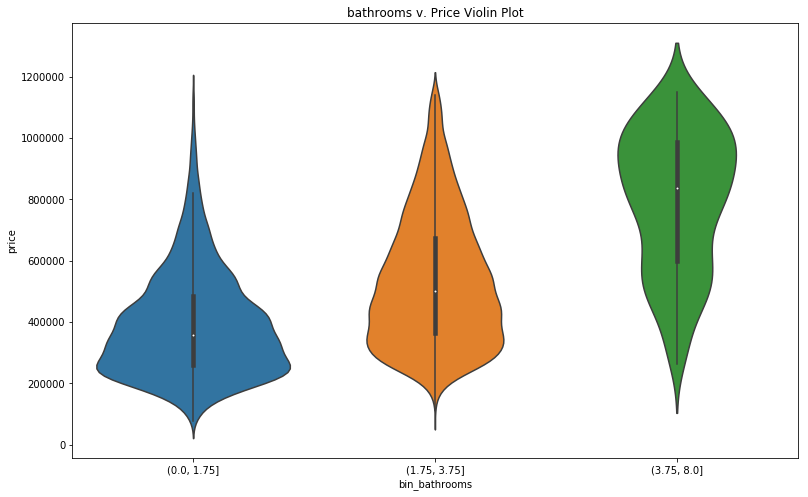

In [31]:
plt.figure(figsize= (13, 8))
sns.violinplot(x='bin_bathrooms', y='price', data= data.loc[data.price< data.price.quantile(.95)])
plt.title('bathrooms v. Price Violin Plot');

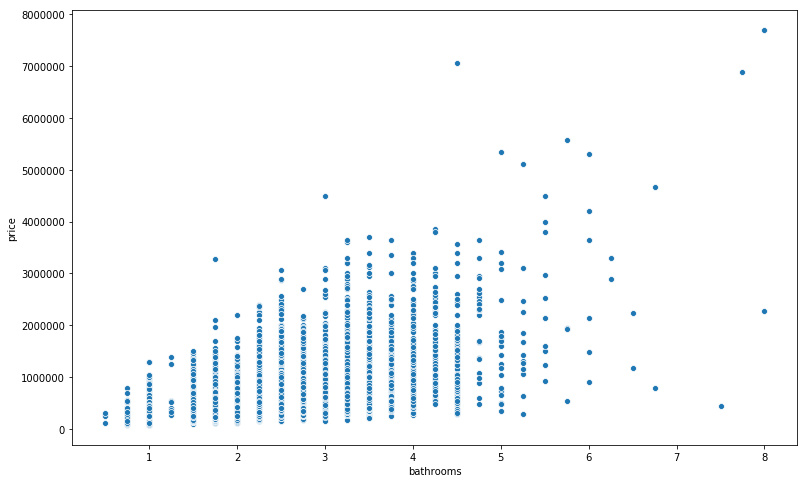

In [32]:
plt.figure(figsize= (13, 8))

#sns.violinplot(x= binning(data['bathrooms'],5), y= data[target]);
sns.scatterplot(x= data.bathrooms, y= data[target]);

#### Bathroom v. Price Violin Plot
-skewed to data in all categories

-simliar to Bedroom

-High heteroscedasticity 

#### sqft_living
Square footage of the home 

The range is 370 sqft to 13540 sqft. 

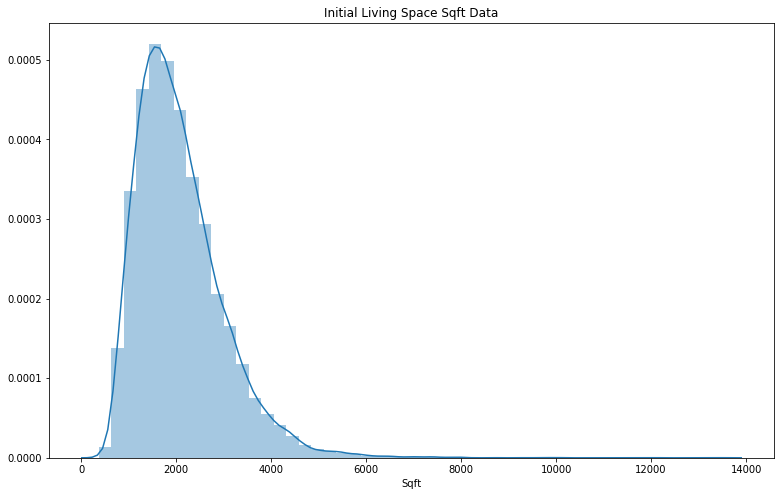

In [33]:
# binning values
bins = [370, 1000, 2000, 3000, 4000, 5000, 13540]


plt.figure(figsize= (13, 8))

sns.distplot(data.sqft_living)
plt.title('Initial Living Space Sqft Data');
plt.xlabel('Sqft');



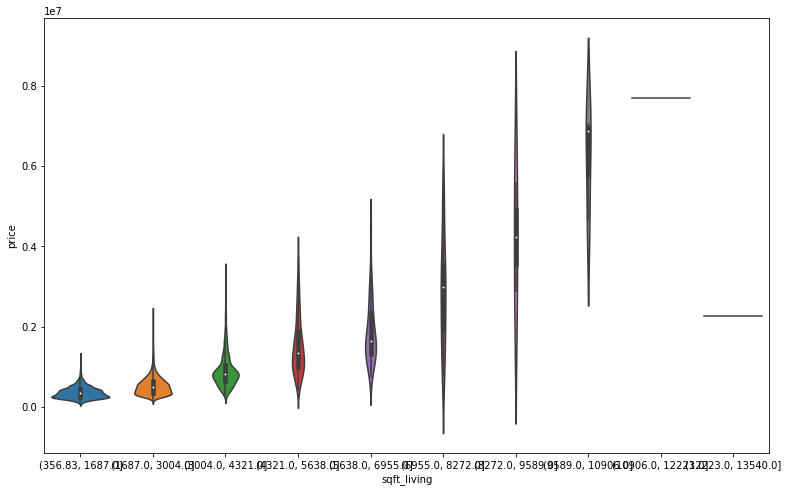

In [34]:
plt.figure(figsize= (13, 8))
sns.violinplot(x= binning(data['sqft_living'],10), y= data[target]);

<Figure size 936x576 with 0 Axes>

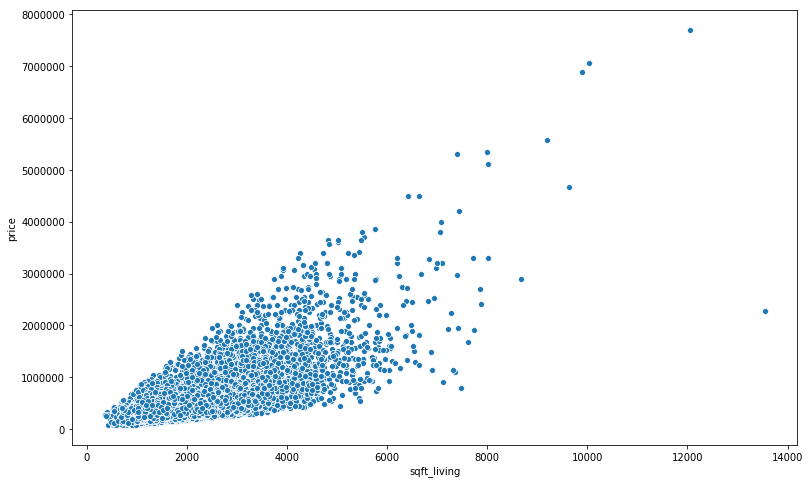

In [35]:
plt.figure(figsize= (13, 8));
scat_plot(data, 'sqft_living');

#### Square Footage for Living Space v. Price Violin Plot
-skewed to data in all categories

-simliar to Bedroom

-There is high heterodiacity

##### sqft_lot
Square footage of the lot
The range is 520 sqft to 1,651,359 sqft.


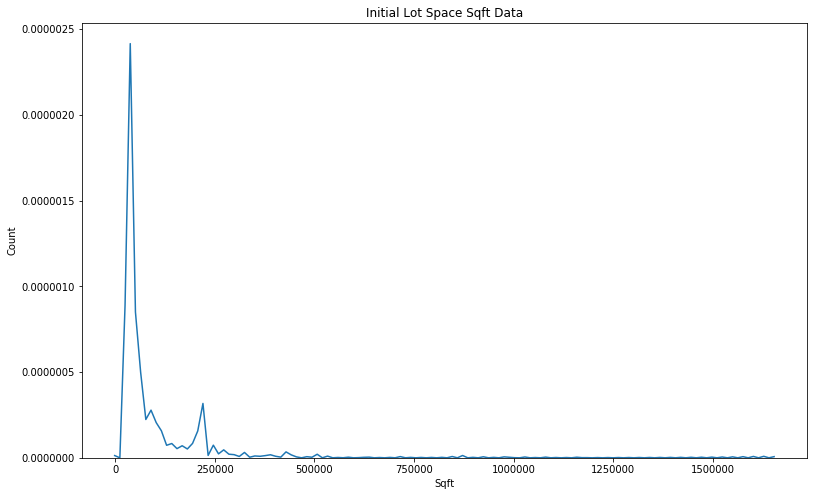

In [36]:

plt.figure(figsize= (13, 8))
sns.distplot(data.sqft_lot, hist=False)
plt.title('Initial Lot Space Sqft Data');
plt.xlabel('Sqft');
plt.ylabel('Count');


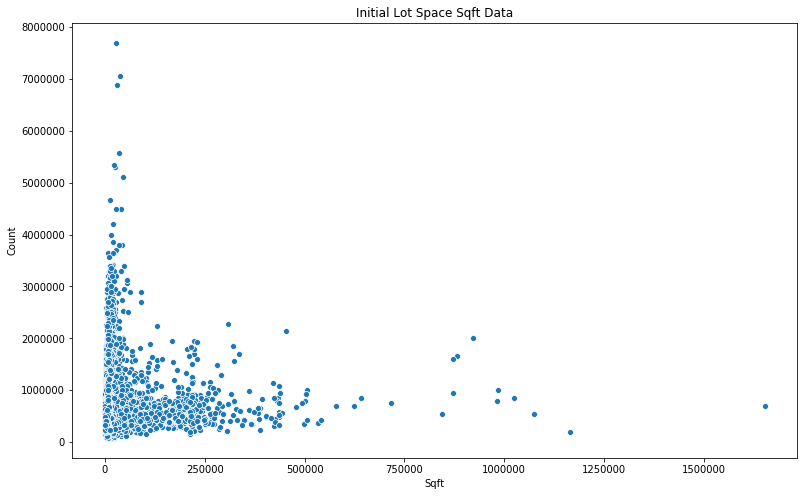

In [37]:
plt.figure(figsize= (13, 8))
sns.scatterplot(x= data.sqft_lot, y= data.price)
plt.title('Initial Lot Space Sqft Data');
plt.xlabel('Sqft');
plt.ylabel('Count');

#### KDE plot for Lot Space
-Looks like it is a highly skewed.

#### floors
Total floors (levels) in house
The range is 1 to 3.5 floor. 

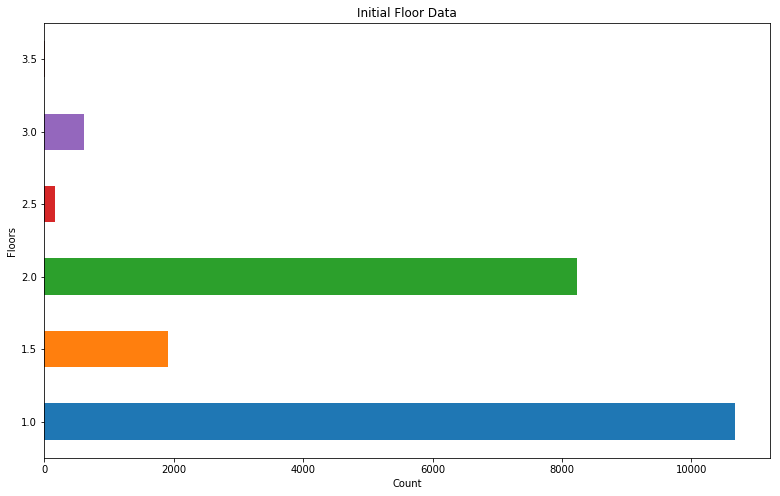

In [38]:
a=data.floors.value_counts(sort=False);
plt.figure(figsize= (13, 8))
a.sort_index().plot(kind= 'barh')
plt.title('Initial Floor Data');
plt.xlabel('Count');
plt.ylabel('Floors');

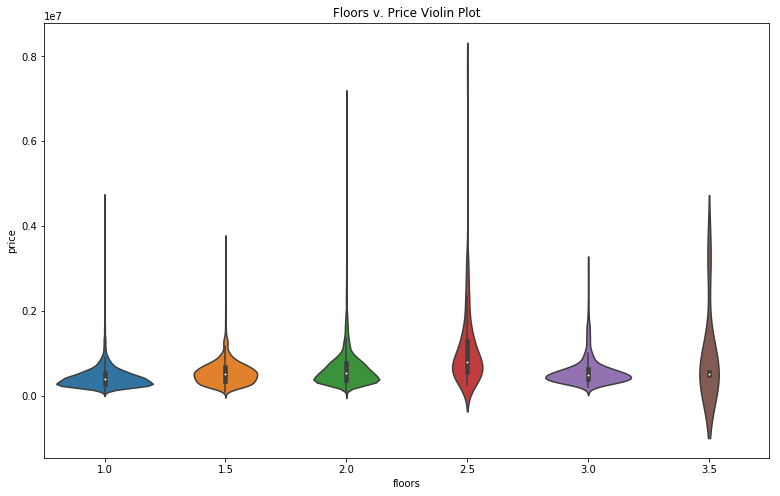

In [39]:
plt.figure(figsize= (13, 8))
sns.violinplot(x='floors', y='price', data= data)
plt.title('Floors v. Price Violin Plot');

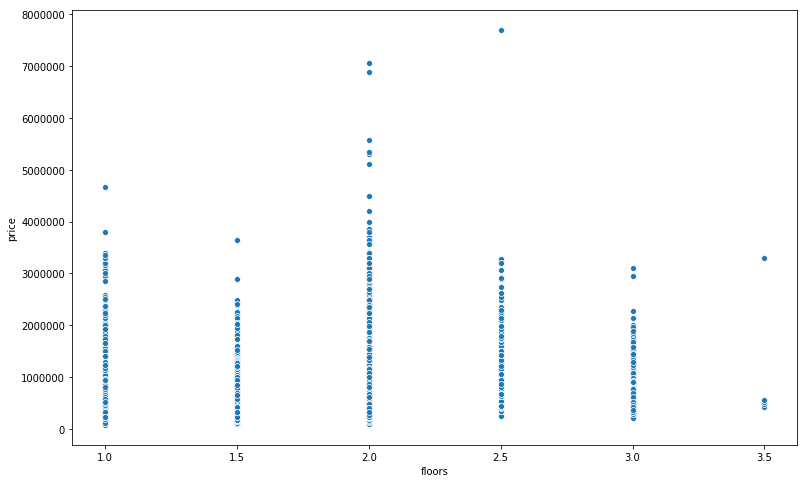

In [40]:
scat_plot(data, 'floors')

#### bin_floors


In [41]:
bins= [0, 1.5, 2.5, 3.5]

In [42]:
a= binning(data.floors, bins).astype(str)


In [43]:
count = 1
for i in a.unique():
    b = a.loc[a == i]
    a.iloc[b.index] = count
    count += 1
data['bin_floors'] = a

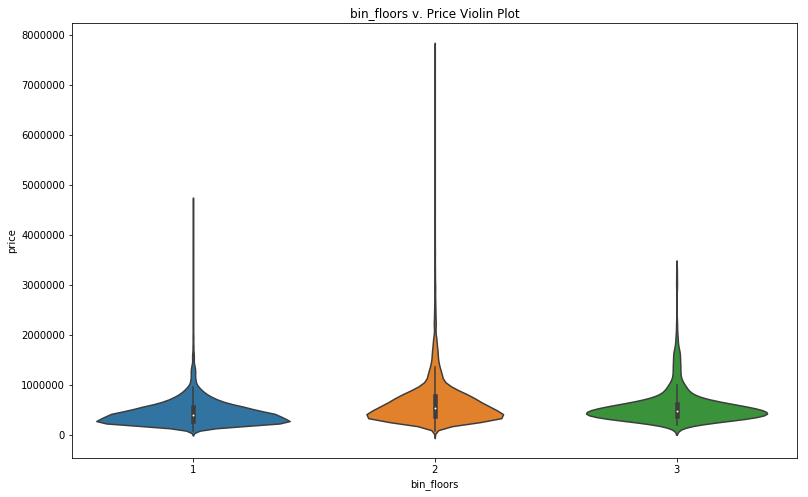

In [44]:
plt.figure(figsize= (13, 8))
sns.violinplot(x='bin_floors', y='price', data= data)
plt.title('bin_floors v. Price Violin Plot');

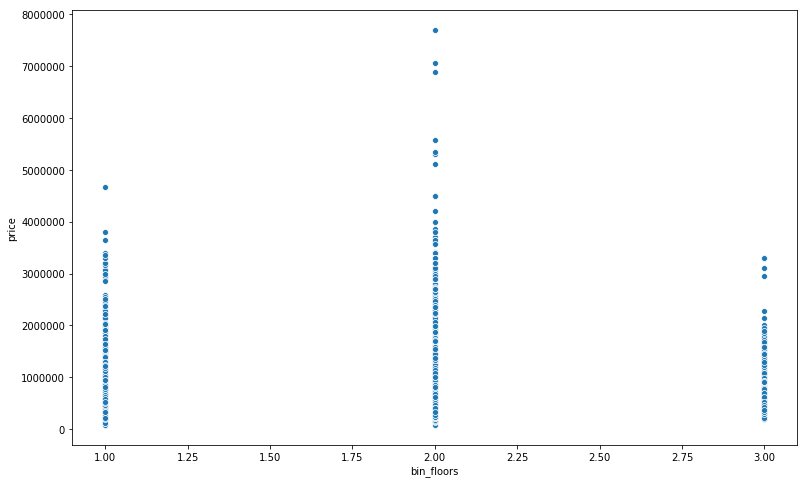

In [45]:
scat_plot(data, 'bin_floors')

#### waterfront
House which has a view to a waterfront



In [46]:
data.waterfront.value_counts()

0.0    21451
1.0      146
Name: waterfront, dtype: int64

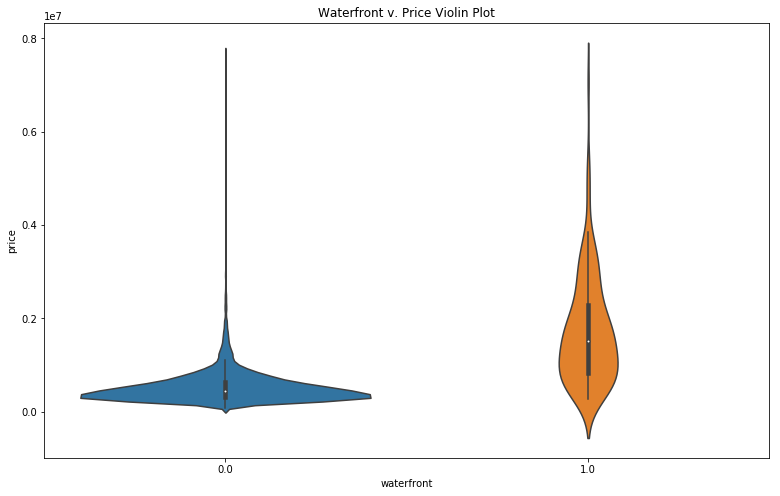

In [47]:
plt.figure(figsize= (13, 8))
sns.violinplot(x='waterfront', y='price', data= data)
plt.title('Waterfront v. Price Violin Plot');

#### view
Has been viewed
The range is 0 to 4.

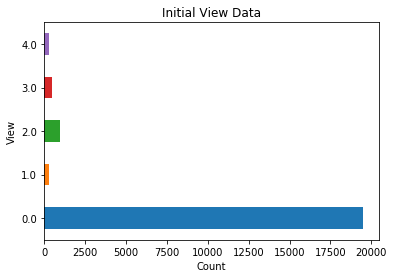

In [48]:
a = data.view.value_counts()
a.sort_index().plot(kind= 'barh')
plt.title('Initial View Data');
plt.xlabel('Count');
plt.ylabel('View');

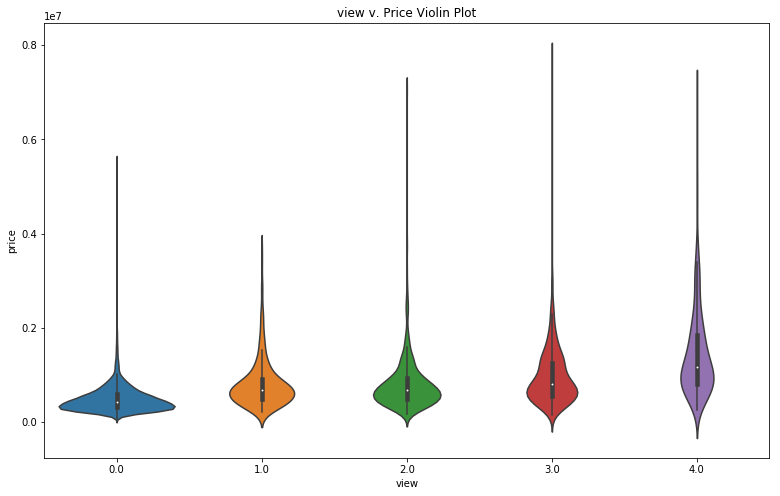

In [49]:
plt.figure(figsize= (13, 8))
sns.violinplot(x='view', y='price', data= data)
plt.title('view v. Price Violin Plot');

#### view Analysis
High skewedness

#### condition
How good the condition is ( Overall 
The range is 1 to 5.

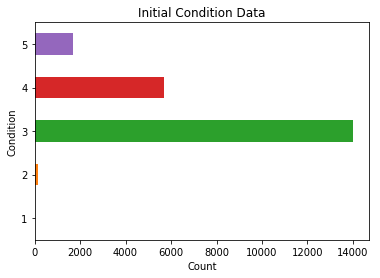

In [50]:
a = data.condition.value_counts()
a.sort_index().plot(kind= 'barh')
plt.title('Initial Condition Data');
plt.xlabel('Count');
plt.ylabel('Condition');

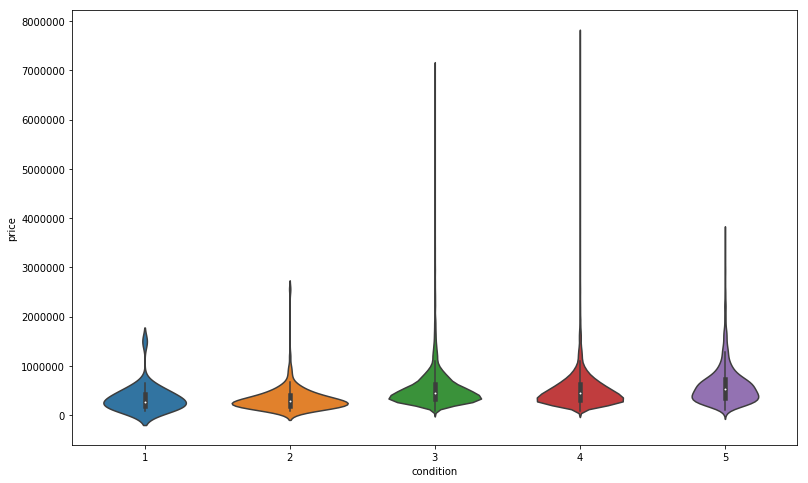

In [51]:
viol_plot(data, 'condition')

#### Analysis of Condition
High skewness in the high count values.

#### grade
overall grade given to the housing unit, based on King County grading system

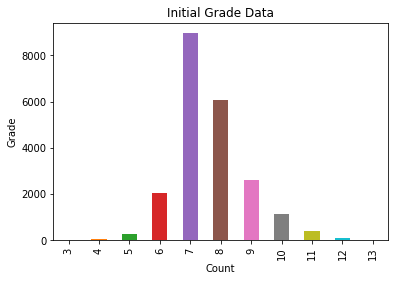

In [52]:
a = data.grade.value_counts()
a.sort_index().plot(kind= 'bar')
plt.title('Initial Grade Data');
plt.xlabel('Count');
plt.ylabel('Grade');

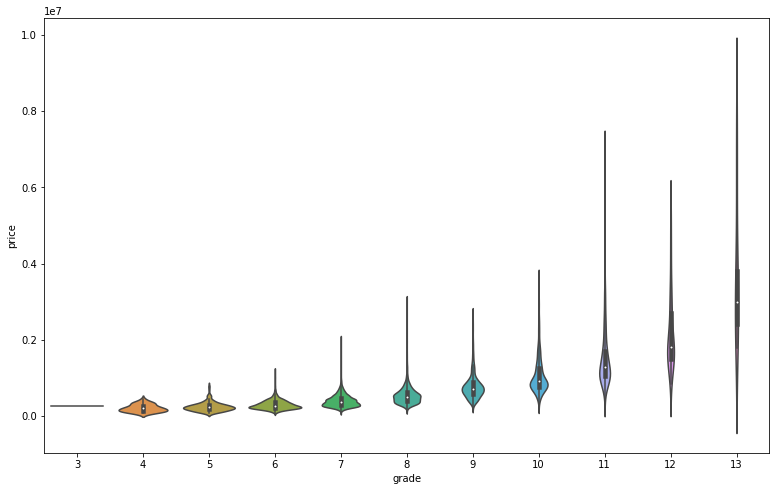

In [53]:
viol_plot(data, 'grade')

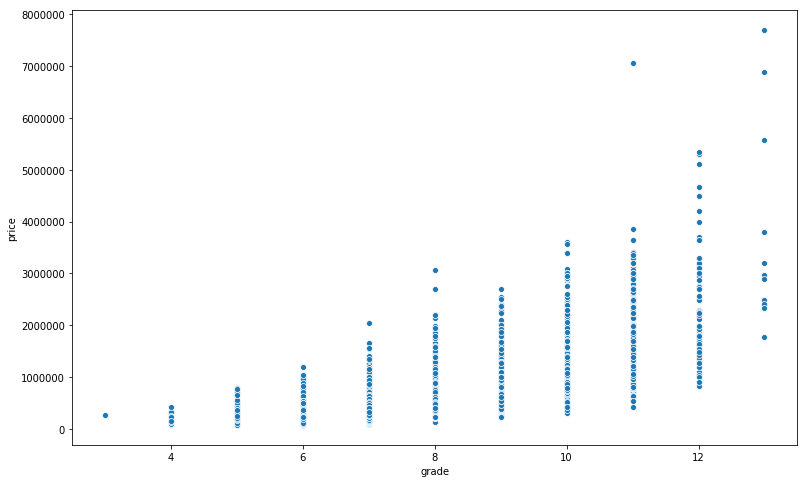

In [54]:
scat_plot(data, 'grade')

#### Analysis of Grade.
skewness increase as the grade increases
High Heteroscedasticity 

#### Analysis seem to increase as the grade goes up.

#### sqft_above
Square footage of house apart from basement

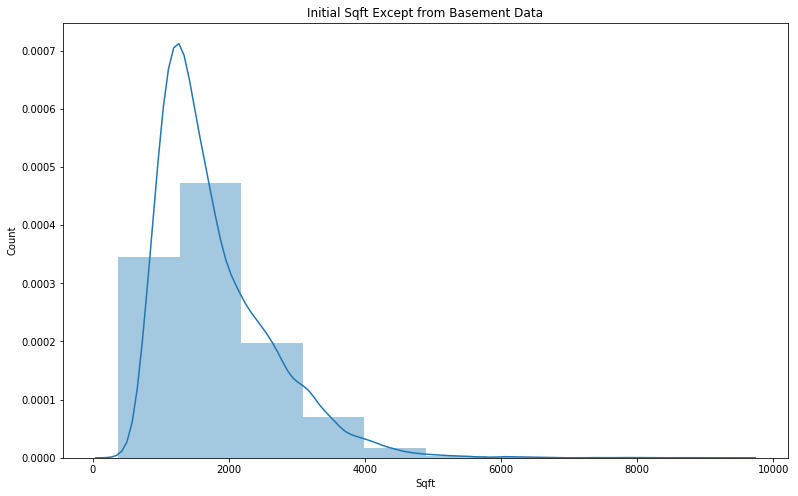

In [55]:

plt.figure(figsize= (13, 8))
sns.distplot(data.sqft_above, bins=10)
plt.title('Initial Sqft Except from Basement Data');
plt.xlabel('Sqft');
plt.ylabel('Count');

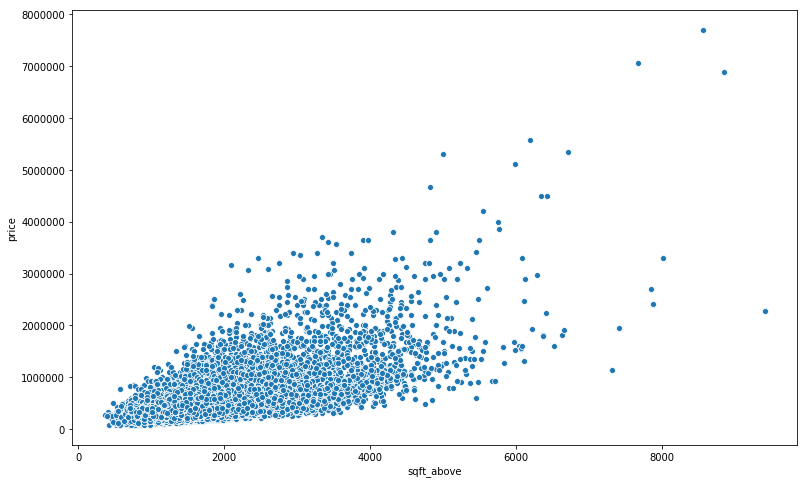

In [56]:
scat_plot(data, 'sqft_above')

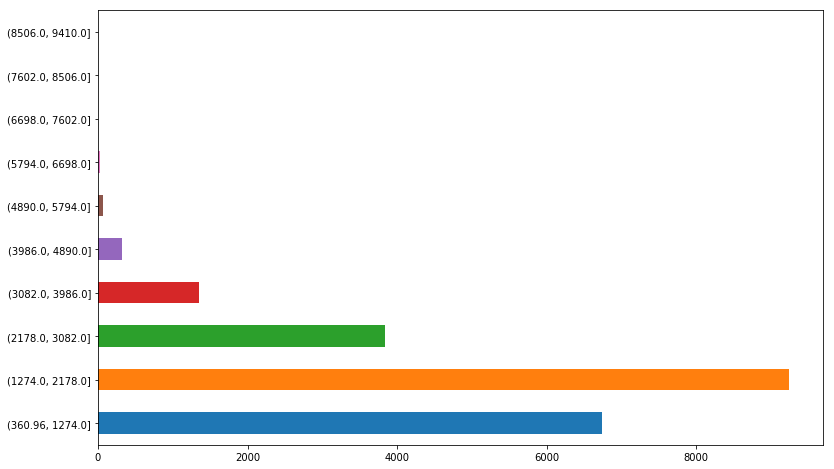

In [57]:
data['binning_sqft_above'] = binning(data.sqft_above, 10)

bar_hist_plot(data.binning_sqft_above)
data = data.drop(columns= 'binning_sqft_above')

#### Analysis of sqft_above
-High Heteroscedasticity 

#### sqft_basement
Square footage of the basement.  ? is the place hold value and the feature is formated as a string. See Data Scrubbing 

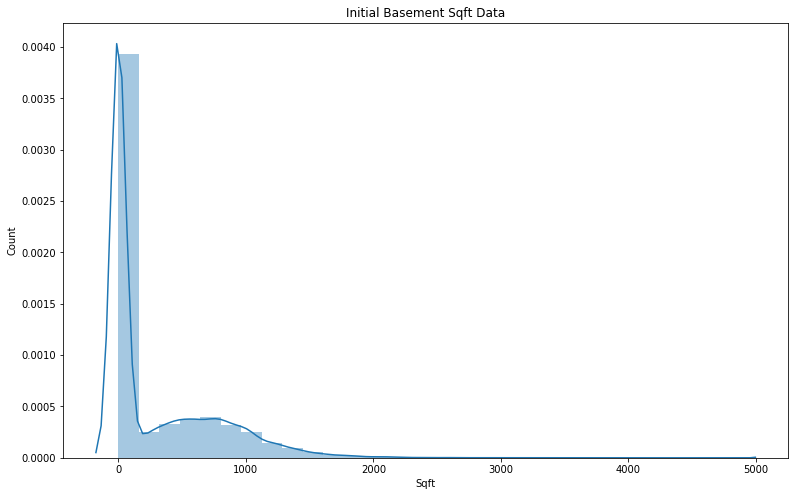

In [58]:
plt.figure(figsize= (13, 8))
sns.distplot(data.sqft_basement, bins=30)
plt.title('Initial Basement Sqft Data');
plt.xlabel('Sqft');
plt.ylabel('Count');

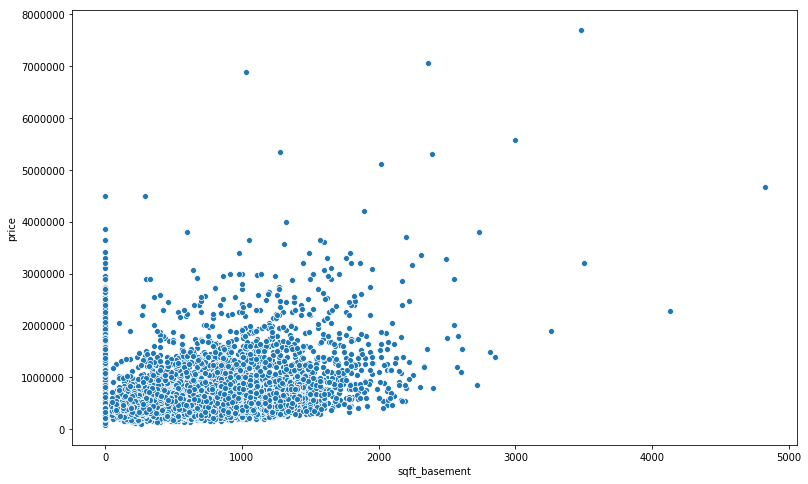

In [59]:
scat_plot(data, 'sqft_basement')

#### Analysis of sqft basement
-High Heteroscedasticity


#### yr_built
Built Year
The range is 1900 to 2015

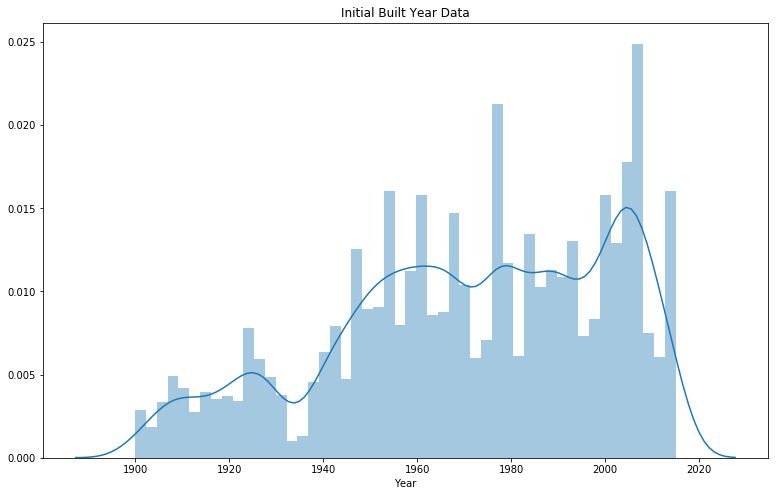

In [60]:
plt.figure(figsize= (13, 8))
sns.distplot(data.yr_built, bins=50)
plt.title('Initial Built Year Data');
plt.xlabel('Year');


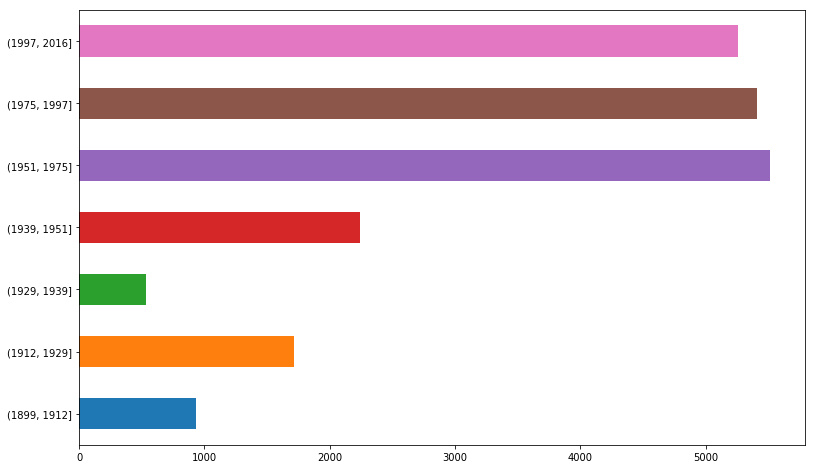

In [61]:
data.yr_built.describe()
[1899, 1951, 1975, 1997, 2015]
pd.cut(data.yr_built, [1899, 1912, 1929, 1939, 1951, 1975, 1997, 2016])

bar_hist_plot(pd.cut(data.yr_built, [1899, 1912, 1929, 1939, 1951, 1975, 1997, 2016]))


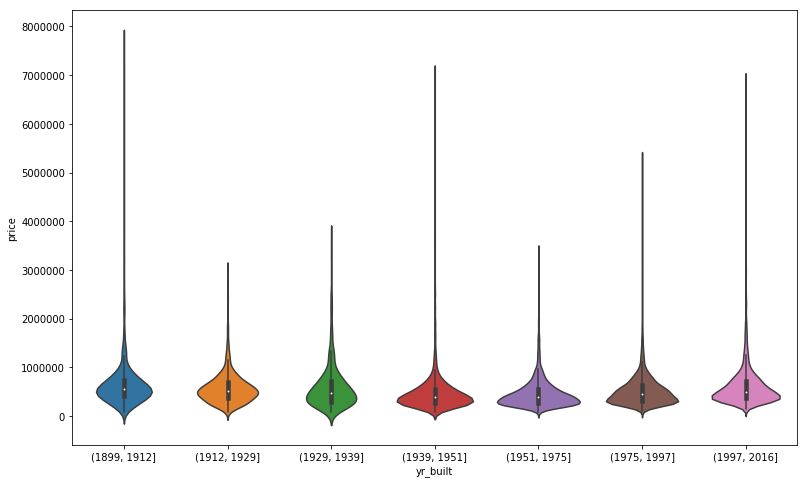

In [62]:
plt.figure(figsize=(13,8))
sns.violinplot(x= pd.cut(data.yr_built, [1899, 1912, 1929, 1939, 1951, 1975, 1997, 2016]), y= data.price);



#### yr_renovated
Year when house was renovated. The 744 have renovations.

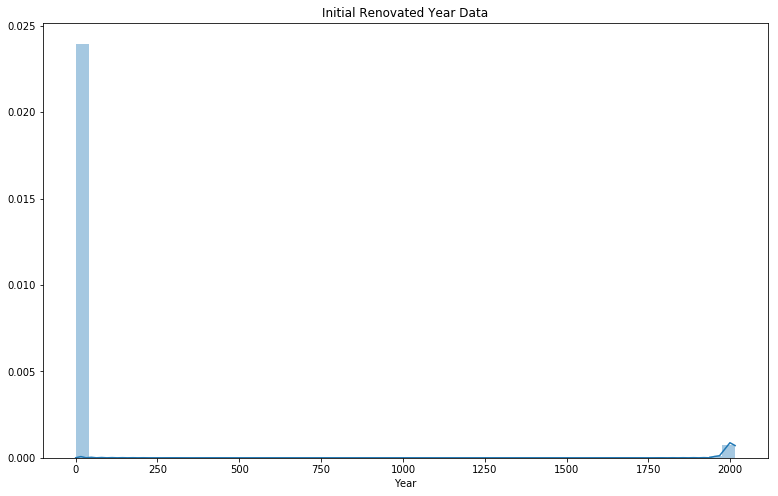

In [63]:
plt.figure(figsize= (13, 8))
sns.distplot(data.yr_renovated, bins=50)
plt.title('Initial Renovated Year Data');
plt.xlabel('Year');

#### zipcode

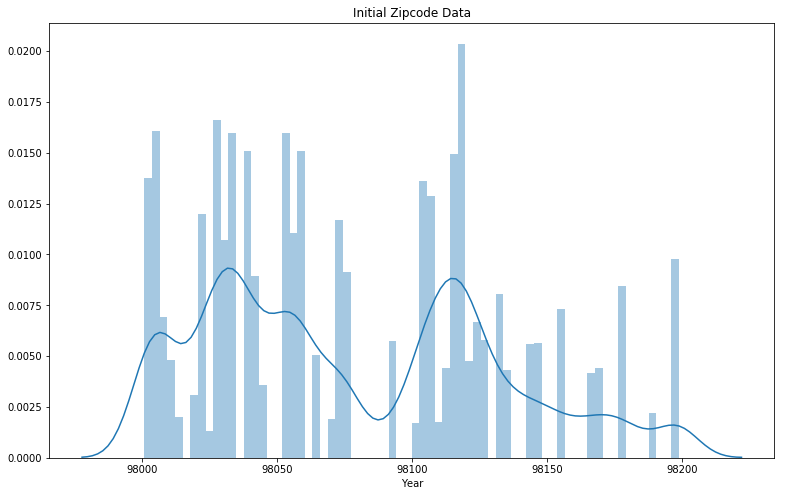

In [64]:
plt.figure(figsize= (13, 8))
sns.distplot(data.zipcode, bins=70)
plt.title('Initial Zipcode Data');
plt.xlabel('Year');

count    2.159700e+04
mean     5.402966e+05
std      2.344425e+05
min      2.342840e+05
25%      3.594963e+05
50%      4.936253e+05
75%      6.452442e+05
max      2.161300e+06
Name: zip_mean, dtype: float64

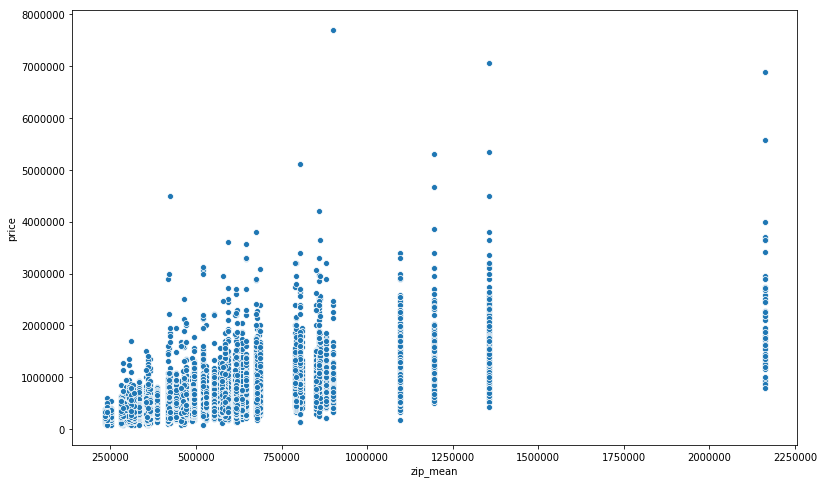

In [65]:
a=data.groupby(['zipcode'])['price'].mean()
data['zip_mean'] = data.zipcode.apply(lambda x: a[x])
scat_plot(data, 'zip_mean')
data['zip_mean'].describe()

count    2.159700e+04
mean     4.859554e+05
std      1.966655e+05
min      2.350000e+05
25%      3.350000e+05
50%      4.459500e+05
75%      5.720000e+05
max      1.895000e+06
Name: zip_median, dtype: float64

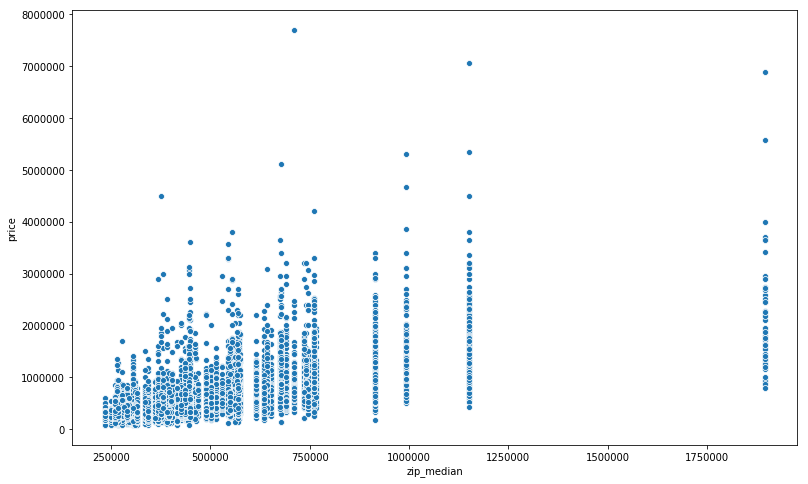

In [66]:
a=data.groupby(['zipcode'])['price'].median()
data['zip_median'] = data.zipcode.apply(lambda x: a[x])
scat_plot(data, 'zip_median')
data['zip_median'].describe()

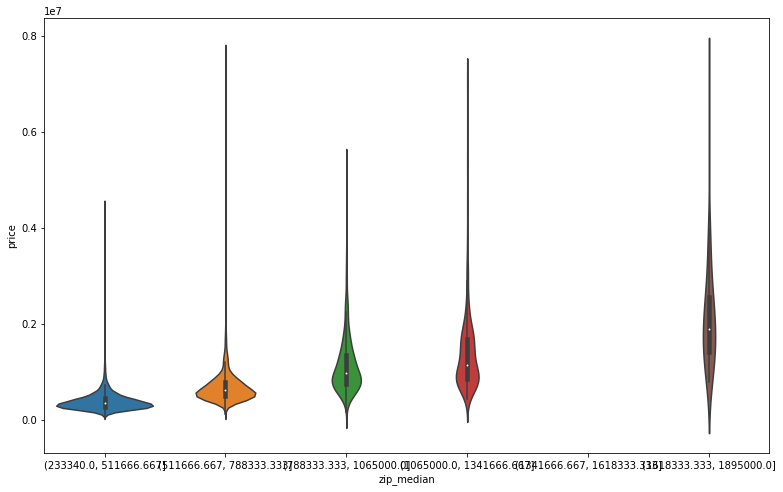

In [67]:
a= binning(data.zip_median, 6)
viol2(x=a, y=data.price)

count    2.159700e+04
mean     6.180254e+05
std      2.811627e+05
min      2.685000e+05
25%      4.052125e+05
50%      5.517500e+05
75%      7.190000e+05
max      2.560000e+06
Name: zip_75q, dtype: float64

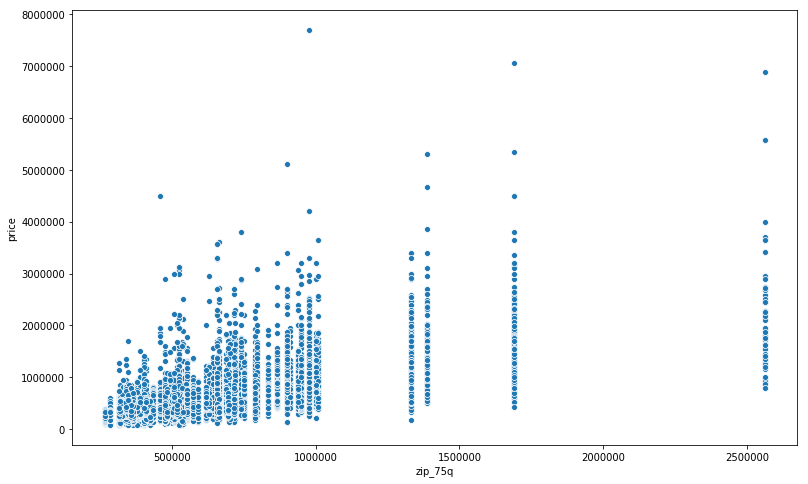

In [68]:
a=data.groupby(['zipcode'])['price'].quantile(.75)
data['zip_75q'] = data.zipcode.apply(lambda x: a[x])
scat_plot(data, 'zip_75q')
data['zip_75q'].describe()

In [69]:
a=data.groupby(['zipcode'])['price'].count()
data['zip_count'] = data.zipcode.apply(lambda x: a[x])

#### lat
Latitude coordinate. The range is 47.1559 to 47.7776

In [70]:
print(max(data.lat), min(data.lat))

47.7776 47.1559


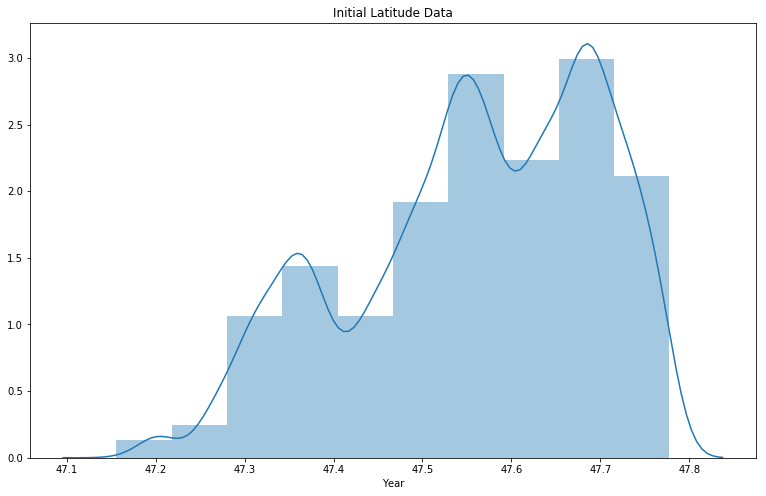

In [71]:
plt.figure(figsize= (13, 8))
sns.distplot(data.lat, bins=10)
plt.title('Initial Latitude Data');
plt.xlabel('Year');

In [72]:
a= data.groupby(['zipcode'])['lat'].median()
data['zip_median_lat'] = data.zipcode.apply(lambda x: a[x])
data['zip_EW'] = (data['zip_median_lat'] >= data.lat)*1


a= data.groupby(['zipcode', 'zip_EW'])['price'].median()
b=[]
for index in range(0,len(data)):
    b.append(a[data.zipcode.iloc[index]][data.zip_EW.iloc[index]])
data['sub_zip_median'] = b    



a= data.groupby(['zipcode', 'zip_EW'])['price'].quantile(.75)
b=[]
for index in range(0,len(data)):
    b.append(a[data.zipcode.iloc[index]][data.zip_EW.iloc[index]])
data['sub_zip_75q'] = b 


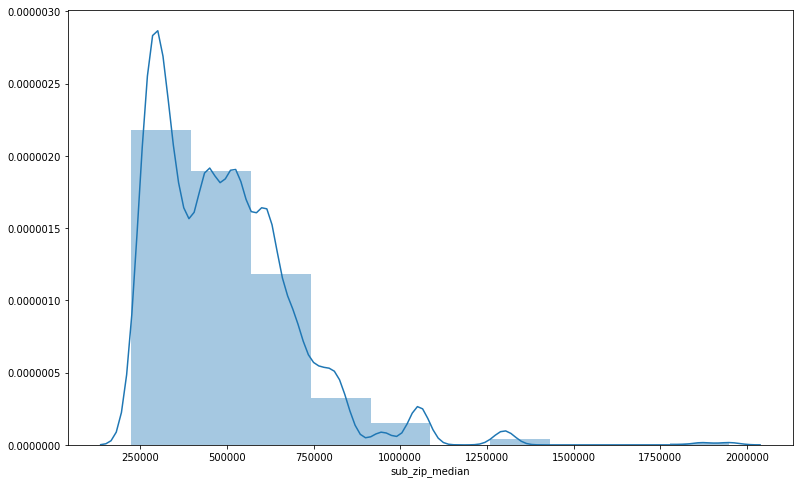

In [73]:
plt.figure(figsize= (13, 8))
sns.distplot(data['sub_zip_median'], bins=10);


#### long
Longitude coordinate

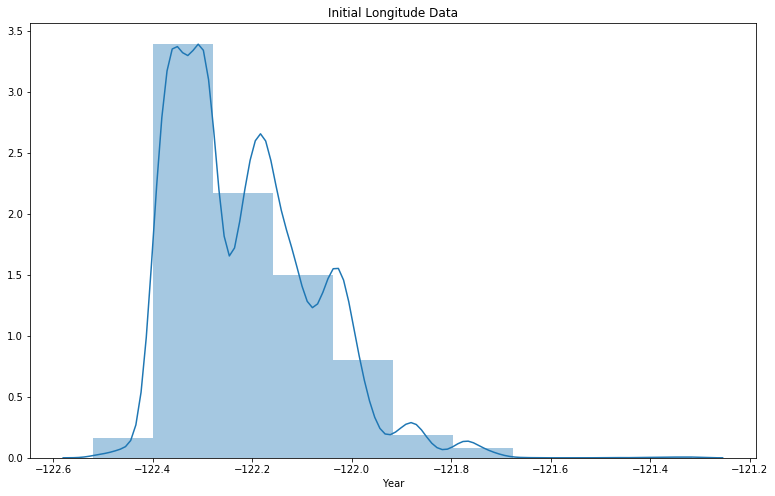

In [76]:
plt.figure(figsize= (13, 8))
sns.distplot(data.long, bins=10)
plt.title('Initial Longitude Data');
plt.xlabel('Year');

In [77]:
data['bin_lat'] = binning(data.lat, equal_bin10(data.lat, quantile_step=25))
data['bin_lat']  = data['bin_lat'].astype(str)
data['bin_long'] = binning(data.long, equal_bin10(data.long, quantile_step=25))
data['bin_long'] = data['bin_long'].astype(str)
column = 'bin_lat'
a = []
count = 1
for index, value in enumerate(data[column]):
    for i in data[column].unique():
        if i == value:
            a.append(count)
        count += 1
    count = 1
data[column] = a  
column = 'bin_long'
a = []
count = 1
for index, value in enumerate(data[column]):
    for i in data[column].unique():
        if i == value:
            a.append(count)
        count += 1
    count = 1
data[column] = a
data['zone'] = data['bin_lat']*10 + data['bin_long']

In [78]:
data['bin_long'].nunique()

25

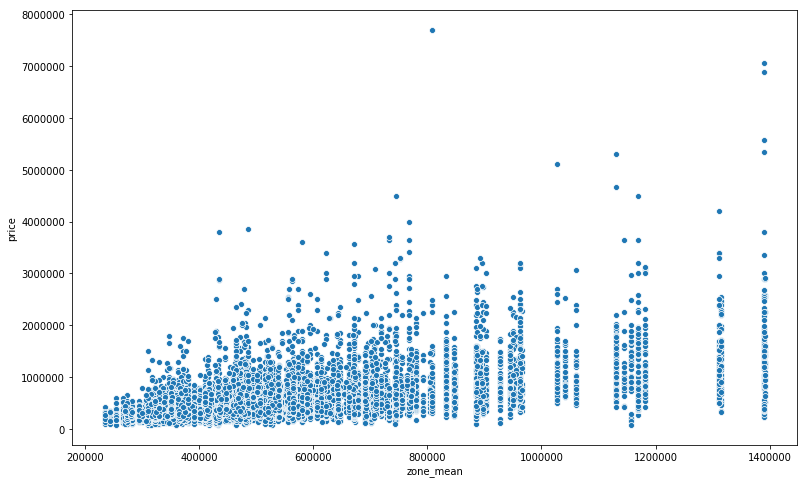

In [79]:

a= data.groupby(['zone'])['price'].mean()
data['zone_mean'] = data.zone.apply(lambda x: a[x])
scat_plot(data, 'zone_mean')
data['log_zone_mean'] = np.log(data['zone_mean'])

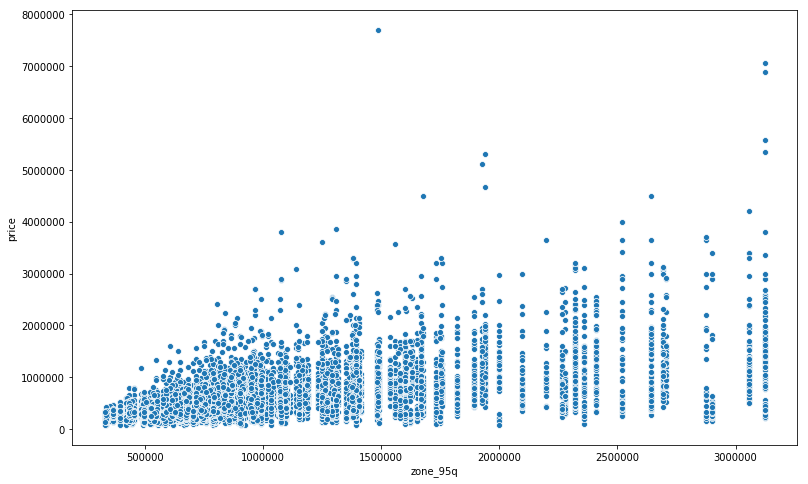

In [80]:
a= data.groupby(['zone'])['price'].quantile(.95)
data['zone_95q'] = data.zone.apply(lambda x: a[x])
scat_plot(data, 'zone_95q')

In [81]:
data['log_zone_95q'] = np.log(data['zone_95q'])

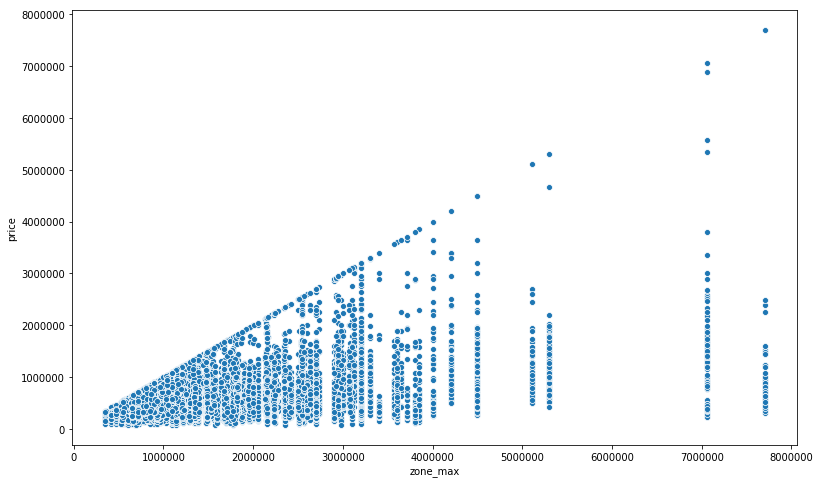

In [82]:
a= data.groupby(['zone'])['price'].max()
data['zone_max'] = data.zone.apply(lambda x: a[x])
scat_plot(data, 'zone_max')



In [83]:
a= data.groupby(['zone'])['price'].count()
data['zone_count'] = data.zone.apply(lambda x: a[x])

#### sqft_living15
The square footage of interior housing living space for the nearest 15 neighbors. The range is 399 to 6210 sq ft

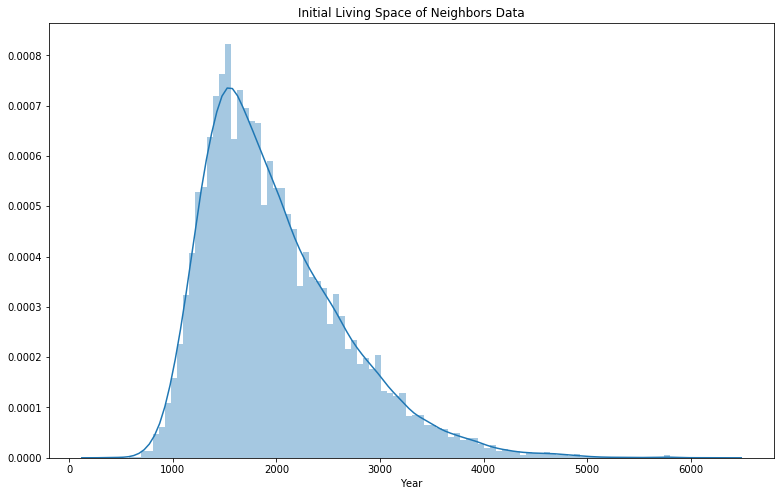

In [84]:
plt.figure(figsize= (13, 8))
sns.distplot(data.sqft_living15, bins=100)
plt.title('Initial Living Space of Neighbors Data');
plt.xlabel('Year');

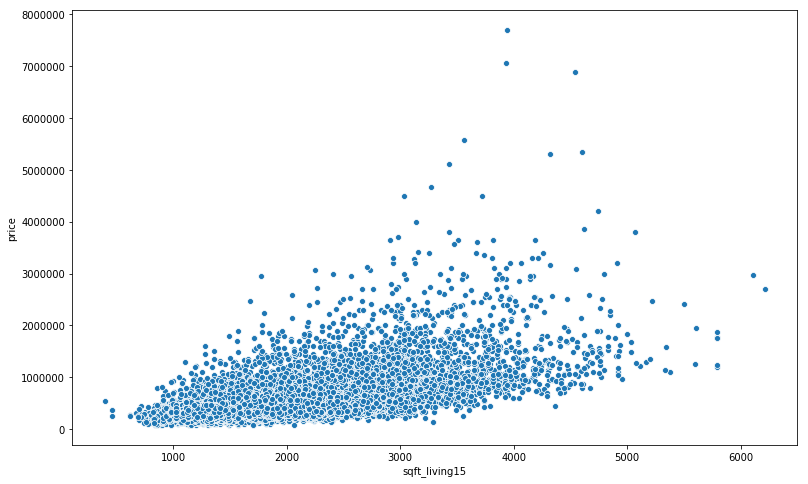

In [85]:
scat_plot(data, 'sqft_living15')

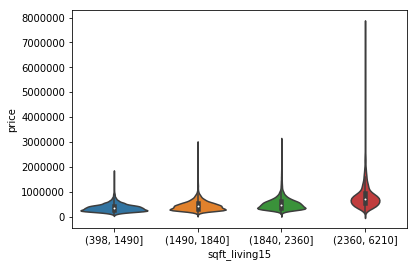

In [86]:
data.sqft_living15.describe()
sns.violinplot(x= binning(data.sqft_living15, [398, 1490, 1840, 2360, 6210]), y= data.price);

#### sqft_lot15
The square footage of the land lots of the nearest 15 neighbors. The range is 651 to 871,200 sq ft.

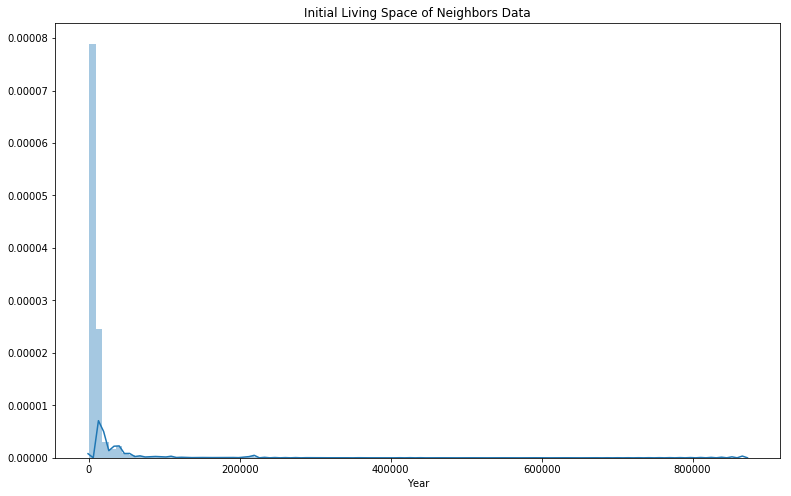

In [87]:
plt.figure(figsize= (13, 8))
sns.distplot(data.sqft_lot15, bins=100)
plt.title('Initial Living Space of Neighbors Data');
plt.xlabel('Year');

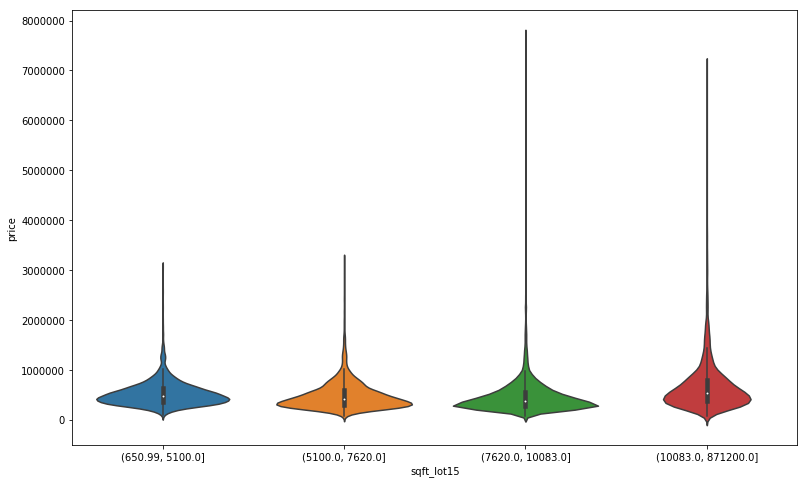

In [88]:

viol2(binning(data.sqft_lot15, equal_bin(data.sqft_lot15)), data.price)



#### change_date  (flip)


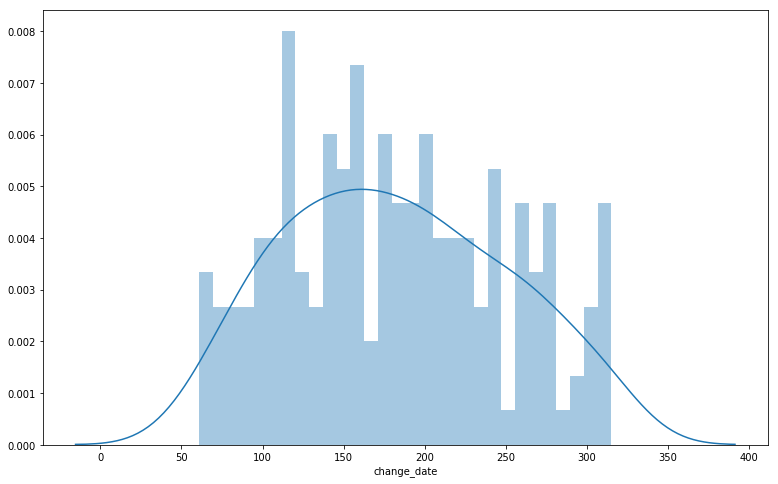

In [89]:
plt.figure(figsize= (13, 8))
sns.distplot(flip.change_date, bins=30);



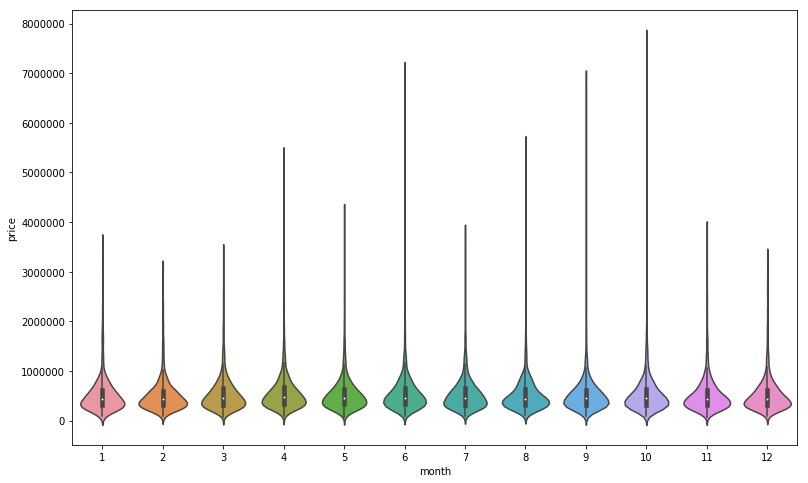

In [90]:
plt.figure(figsize= (13, 8))
sns.violinplot(x= data.month, y= data.price);

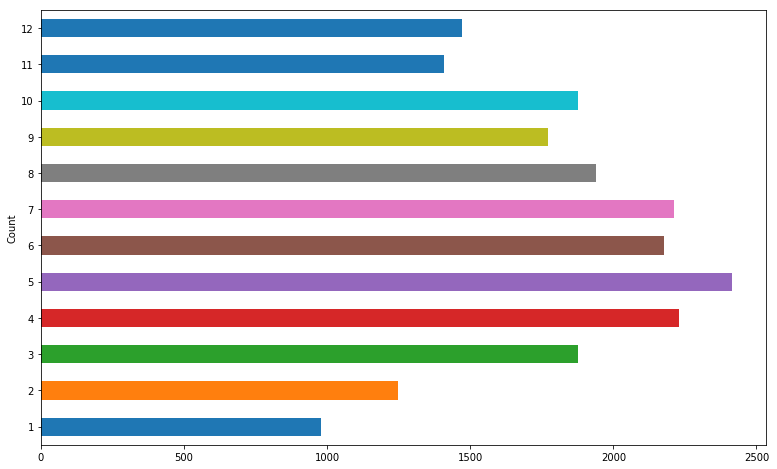

In [91]:
plt.figure(figsize= (13, 8))
a = data.month.value_counts()
a.sort_index().plot(kind= 'barh');
plt.ylabel('Count');

In [97]:
data['log_grade'] = np.log(data["grade"])


#### Creating a Possible Flipped Sale Database
We identified 177 resales of property that were sold in the period of study. We two meanful features:

change_date  The days between sales.

change_price The cost differential between the previous sale and current sale price.

Condition and grade were examined, but there was no change between any of the sales. 


In [98]:
multiple = data.id.value_counts()
len(multiple.loc[multiple > 1])
resales = len(multiple.loc[multiple > 1])
# 176, The number of time a home has been resold in the time period.
resales/ len(data.id)
# Far less then 1% of homes have been sold in the time period.
multiple = multiple.loc[multiple > 1]
multiple = multiple.to_dict()
data['num_sales'] = data.id.map(multiple)
data['num_sales'] = data['num_sales'].fillna(1)
flip = data.loc[data.num_sales > 1]
data = data.drop(columns= 'num_sales')
flip = flip.sort_values('date')

# adding new column examine. 
flip['change_date'] = flip_diff(flip, 'date')

#flip = flip.change_date.apply(lambda x: x.days)      

flip['change_price'] = flip_diff(flip, 'price')

# Removing initial sales
flip = flip.dropna()

# converting timedelta to days
flip.change_date = flip.change_date.apply(lambda x: x.days)

# 
flip['percent_change'] = flip.change_price/(flip.price- flip.change_price)


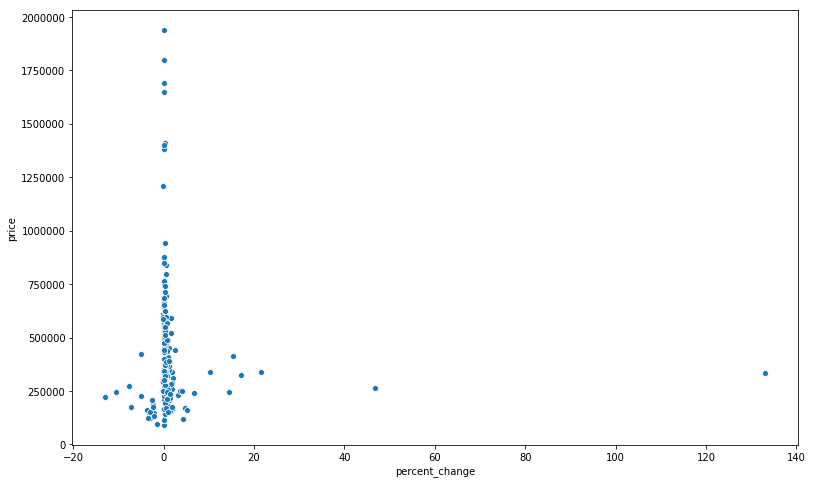

In [99]:
scat_plot(flip, 'percent_change')

In [100]:
data['scaled_log_grade'] = (data['log_grade']-np.mean(data['log_grade']))/np.sqrt(np.var(data['log_grade']))


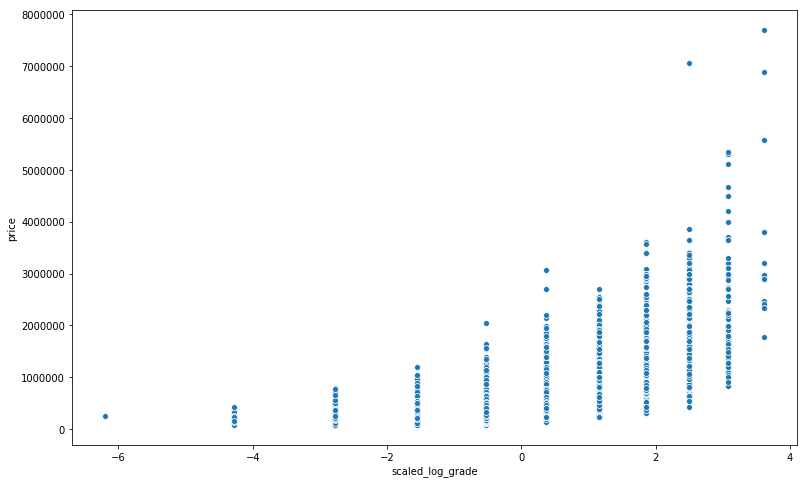

In [101]:
scat_plot(data, 'scaled_log_grade')

0.054498309950456084

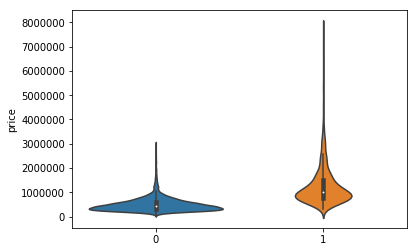

In [102]:
sns.violinplot(x = (1 *(data.price > data.zone_95q)), y = data.price)

a = 1 *(data.price > data.zone_95q)
a.sum()/len(data)


### Exploration (Analysis)

#### Confusion Matrix

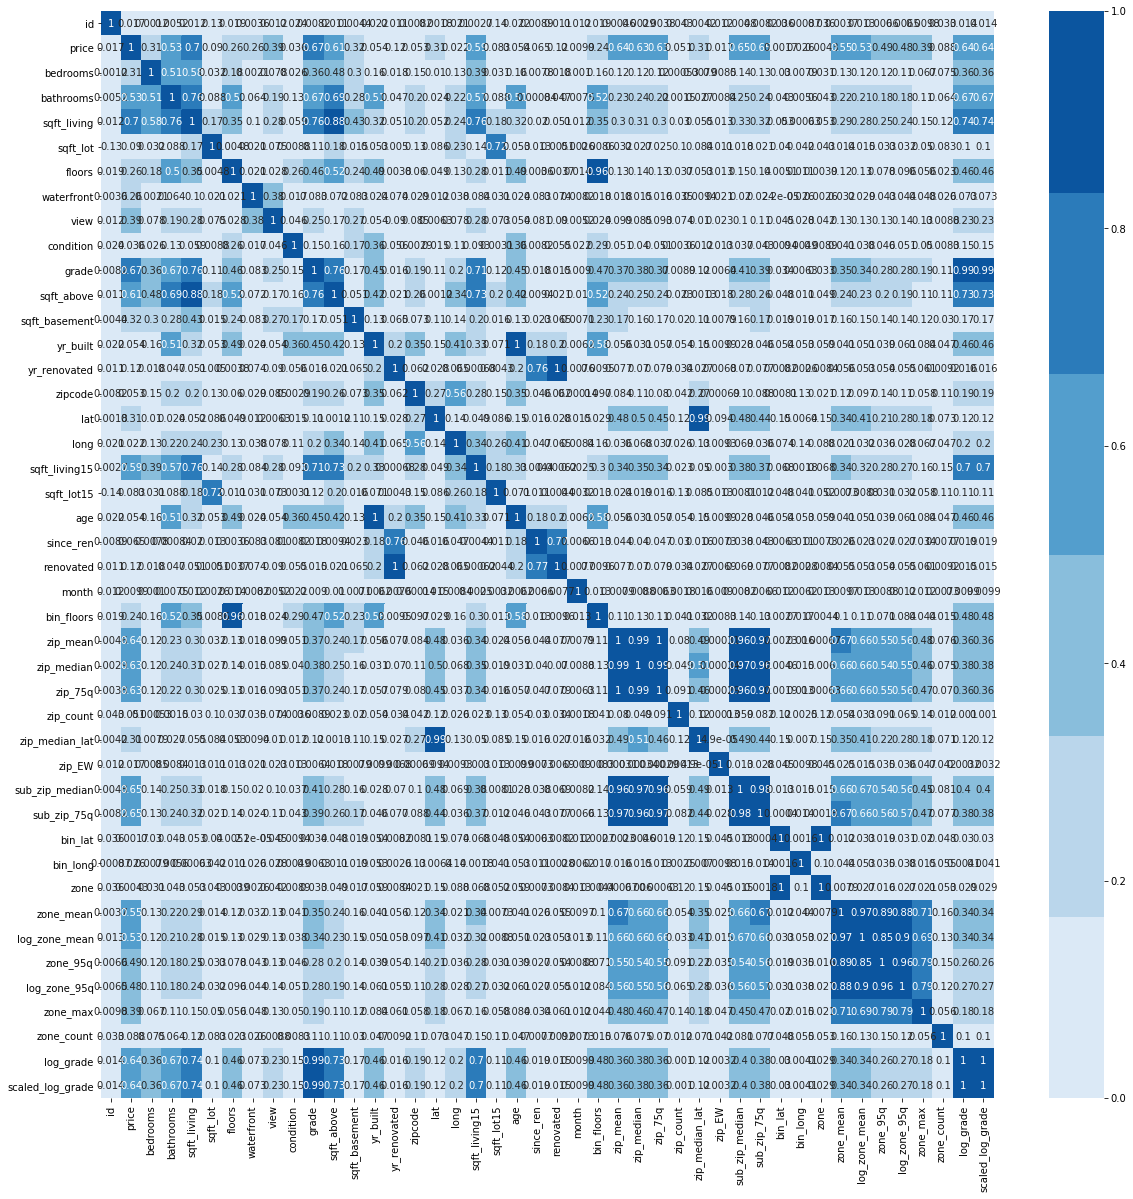

In [103]:
make_heatmap(data=data, figsize=(20, 20))

In [104]:
data.corr().price.abs().sort_values()


bin_lat             0.001708
zone                0.004323
month               0.009928
id                  0.016772
zip_EW              0.017120
long                0.022036
bin_long            0.026289
condition           0.036056
zip_count           0.050969
zipcode             0.053402
yr_built            0.053953
age                 0.053953
since_ren           0.064950
sqft_lot15          0.082845
zone_count          0.087549
sqft_lot            0.089876
renovated           0.117543
yr_renovated        0.117855
bin_floors          0.237264
floors              0.256804
waterfront          0.264306
lat                 0.306692
bedrooms            0.308787
zip_median_lat      0.310784
sqft_basement       0.321108
zone_max            0.390955
view                0.393497
log_zone_95q        0.481499
zone_95q            0.485036
bathrooms           0.525906
log_zone_mean       0.532312
zone_mean           0.547987
sqft_living15       0.585241
sqft_above          0.605368
zip_median    

#### Scatter Matrix
Going to start OLS with sqft_living and add to the OLS going down the regression 

In [105]:
columns= ['sqft_living ']

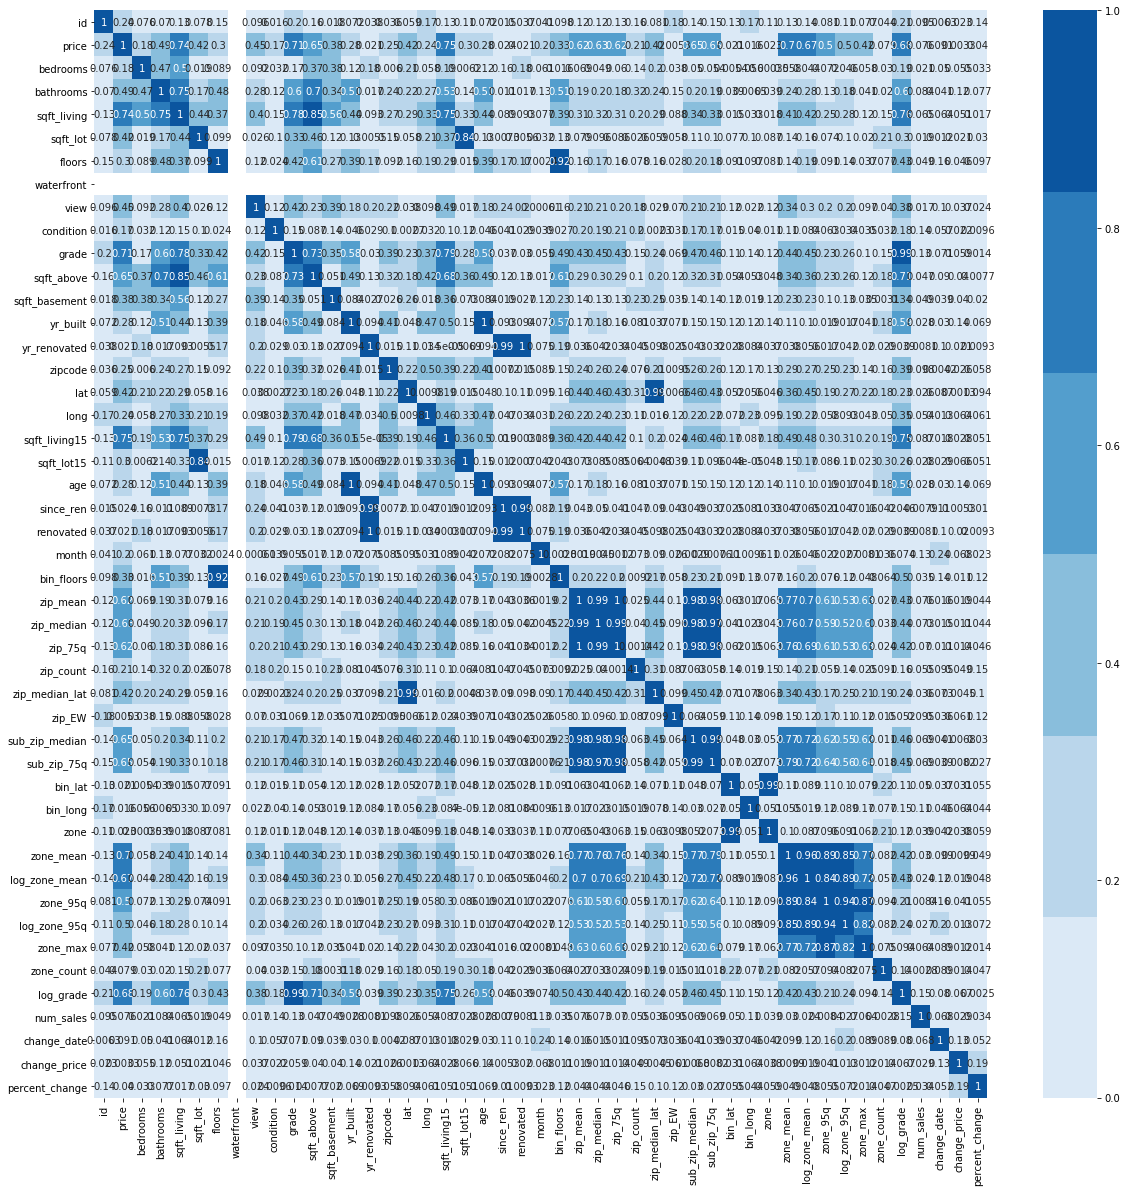

In [106]:
make_heatmap(data=flip, figsize=(20, 20))

#### Modeling / Cross Validation

In [107]:
test= []

In [108]:
make_ols_model(df=data, target='price', columns_to_use='sqft_living' , add_constant=True)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        18:17:41   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.399e+04   4410.023     -9.975      

(<statsmodels.regression.linear_model.OLS at 0x2487b752b38>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2487b7525c0>)

#### Data OLS Test 1

R squared is low

cond no. is high. I will remove constant to see if the improves.

In [109]:
make_ols_model(df=data, target='price', columns_to_use='sqft_living' , add_constant=False)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                 1.124e+05
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        18:17:41   Log-Likelihood:            -3.0011e+05
No. Observations:               21597   AIC:                         6.002e+05
Df Residuals:                   21596   BIC:                         6.002e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   263.1647      0.785    335.319      

(<statsmodels.regression.linear_model.OLS at 0x2487a32e5f8>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2487a32e208>)

#### Data OLS Test 2
R squared improved

Linearity good (only variable).
F - statistic is high.
Skewing is a problem. -Will try log transform.


In [110]:
data['log_sqft_living'] = np.log(data["sqft_living"])

In [111]:
make_ols_model(df=data, target='price', columns_to_use='log_sqft_living' , add_constant=False)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                 5.390e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        18:17:41   Log-Likelihood:            -3.0631e+05
No. Observations:               21597   AIC:                         6.126e+05
Df Residuals:                   21596   BIC:                         6.126e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living    7.3e+04    314.426    2

(<statsmodels.regression.linear_model.OLS at 0x248796e7160>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x248796e7518>)

#### Data OLS Test 3
R squared worst

Linearity good (only variable).

F - statistic is high.

Skewing is less of a problem. -Will try log transform.

In [112]:
columns= ['log_sqft_living', 'grade']
make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                 4.457e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        18:17:41   Log-Likelihood:            -3.0217e+05
No. Observations:               21597   AIC:                         6.044e+05
Df Residuals:                   21595   BIC:                         6.044e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living -1.498e+05   2233.777    -

(<statsmodels.regression.linear_model.OLS at 0x2487b6bbb00>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2487b6bb908>)

#### Data OLS Test 4
R squared better

Linearity good.

Normality is better, but not good.

F - statistic is high but better

Skewing got worst but only by a little. -Will try log transform.

In [113]:
data['log_grade'] = np.log(data["grade"])
columns= ['log_sqft_living', 'log_grade']
make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                 2.988e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        18:17:41   Log-Likelihood:            -3.0550e+05
No. Observations:               21597   AIC:                         6.110e+05
Df Residuals:                   21595   BIC:                         6.110e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living -1.792e+05   6163.081    -

(<statsmodels.regression.linear_model.OLS at 0x2487b6985c0>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2487b698518>)

#### Data OLS Test 5
R squared worse

Linearity good.

Normality is better, but not good.

F - statistic is passing

Skewing got better. -Adding basementsqft

In [114]:

columns= ['log_sqft_living', 'log_grade', 'sqft_basement']
make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                 2.420e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        18:17:42   Log-Likelihood:            -3.0392e+05
No. Observations:               21597   AIC:                         6.078e+05
Df Residuals:                   21594   BIC:                         6.079e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living -2.695e+05   5932.474    -

(<statsmodels.regression.linear_model.OLS at 0x2487b6bb940>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2487b6bb0b8>)

#### Data OLS Test 8
R squared worse

Linearity got worse.

Normality is better, but not good.

F - statistic got worse. Not passing

Skewing got better. -Will make basement a categorical feature

In [115]:
data['basement'] = data.sqft_basement.replace(to_replace= 0, value= np.nan)
data.basement = data.basement/data.basement
data.basement = data.basement.fillna(0)
columns= ['log_sqft_living', 'log_grade', 'basement']
make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                 2.106e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        18:17:42   Log-Likelihood:            -3.0506e+05
No. Observations:               21597   AIC:                         6.101e+05
Df Residuals:                   21594   BIC:                         6.101e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living -2.191e+05   6180.225    -

(<statsmodels.regression.linear_model.OLS at 0x248795dfbe0>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x248795df160>)

#### Data OLS Test 9
R squared better

Normality is worse. 


Skewing got worst but only by a little. -Taking out basement and add lat next

In [116]:

columns= ['log_sqft_living', 'grade', 'lat']

ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                 3.553e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        18:17:42   Log-Likelihood:            -3.0059e+05
No. Observations:               21597   AIC:                         6.012e+05
Df Residuals:                   21594   BIC:                         6.012e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living   2.03e+05   6394.031     

In [117]:
current= [results.rsquared, results.condition_number]
current

[0.831521778529237, 178.25252875884587]

#### Data OLS Test 10
R squared better

Normality same 

Skewing got worst but only by a little. -Try log transform

In [118]:
data['log_lat'] = np.log(data.lat)
columns= ['log_sqft_living', 'log_grade', 'log_lat']
ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
print('\nR2', current[0], results.rsquared, '\nCond. No.',current[1], results.condition_number) 

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                 3.369e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        18:17:42   Log-Likelihood:            -3.0107e+05
No. Observations:               21597   AIC:                         6.021e+05
Df Residuals:                   21594   BIC:                         6.022e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living  2.665e+05   6581.381     

#### Data OLS Test 11
R squared very bad

Normality same 


I going to see if we can create better location feature. Going to replace lat with zip_mean.

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                 4.457e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        18:17:42   Log-Likelihood:            -2.9852e+05
No. Observations:               21597   AIC:                         5.970e+05
Df Residuals:                   21594   BIC:                         5.971e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living -1.459e+05   1886.642    -

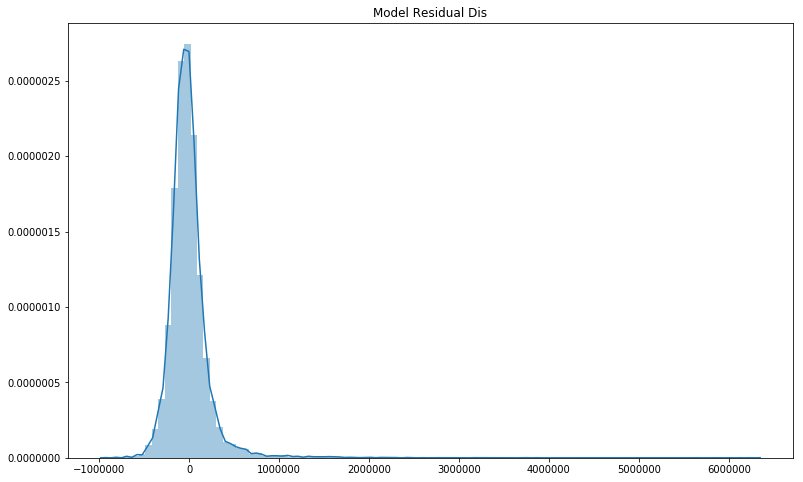

In [119]:
columns= ['log_sqft_living', 'grade', 'zip_mean']
ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
tests= [results.rsquared, results.condition_number]
print('\nR2', current[0], results.rsquared, '\nCond. No.',current[1], results.condition_number) 
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');

#### OLS Test 12
worst than test 9.

Cond. No. is out of control.

In [120]:

columns= ['log_sqft_living', 'grade', 'zip_median']
ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
tests= [results.rsquared, results.condition_number]
print('\nR2', current[0]-results.rsquared, '\nCond. No.',current[1]-results.condition_number) 

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                 4.326e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        18:17:42   Log-Likelihood:            -2.9880e+05
No. Observations:               21597   AIC:                         5.976e+05
Df Residuals:                   21594   BIC:                         5.976e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living -1.484e+05   1910.590    -

#### Test 13
Not much better than test 14. - tray higher quantile

In [121]:
columns= ['log_sqft_living', 'grade', 'zip_75q']
ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
tests= [results.rsquared, results.condition_number]
print('\nR2', current[0]-results.rsquared, '\nCond. No.',current[1]-results.condition_number) 

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                 4.468e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        18:17:42   Log-Likelihood:            -2.9850e+05
No. Observations:               21597   AIC:                         5.970e+05
Df Residuals:                   21594   BIC:                         5.970e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living -1.442e+05   1885.103    -

#### Test 14 
Better than 13. 

Linearity is still problem

In [122]:
columns= ['log_sqft_living', 'grade', 'sub_zip_median' ]
ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
tests= [results.rsquared, results.condition_number]
print('\nR2', current[0]-results.rsquared, '\nCond. No.',current[1]-results.condition_number) 

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                 4.411e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        18:17:42   Log-Likelihood:            -2.9862e+05
No. Observations:               21597   AIC:                         5.972e+05
Df Residuals:                   21594   BIC:                         5.973e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living -1.427e+05   1896.087    -

#### OLS Test 16
Not good. -Will go back to Test 10, and examine residuals

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                 4.457e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        18:17:43   Log-Likelihood:            -3.0217e+05
No. Observations:               21597   AIC:                         6.044e+05
Df Residuals:                   21595   BIC:                         6.044e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living -1.498e+05   2233.777    -

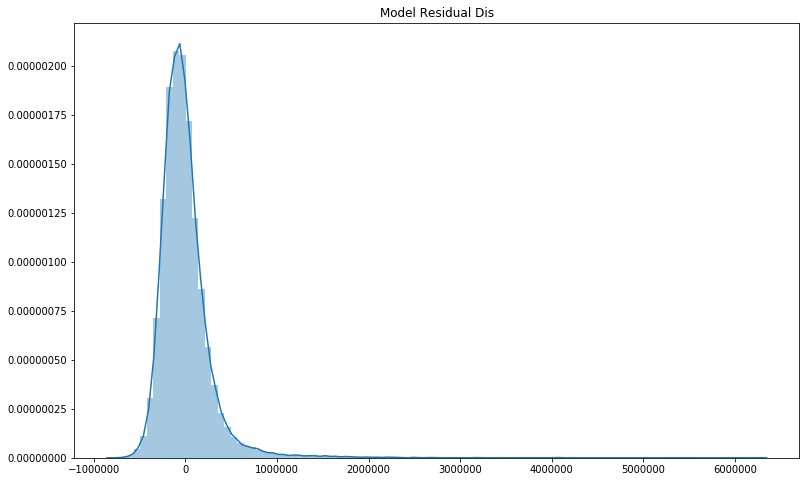

In [123]:

columns= ['log_sqft_living', 'grade']

ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');

Residual is very skewed to the lower end. 

In [124]:
len(a.loc[a.abs() > 2])/len(a)

0.0

#### OLS Test 17
-will add zone_mean- Binned values of lat and long (quantities in each bin) with the mean of the sales price in the area

##### Residual Check 1
Around 3% of the residuals are outside of 2 standard deviations . I will check the model to see if the regression improves.

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                 3.773e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        18:17:43   Log-Likelihood:            -3.0005e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21594   BIC:                         6.001e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living -1.592e+05   2029.334    -

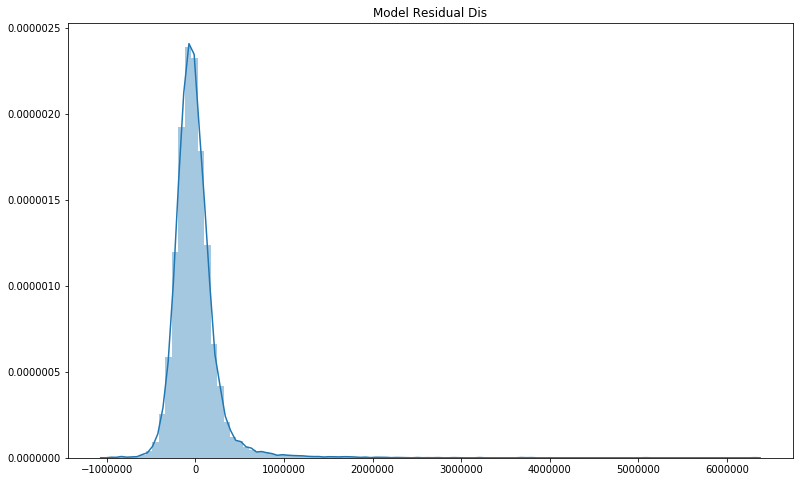

In [125]:
columns= ['log_sqft_living', 'grade', 'zone_mean']

ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');

In [126]:
a=results.resid/results.resid.std()
a = a.loc[a.abs() > 2]
len(a)/len(results.resid)

0.031208038153447238

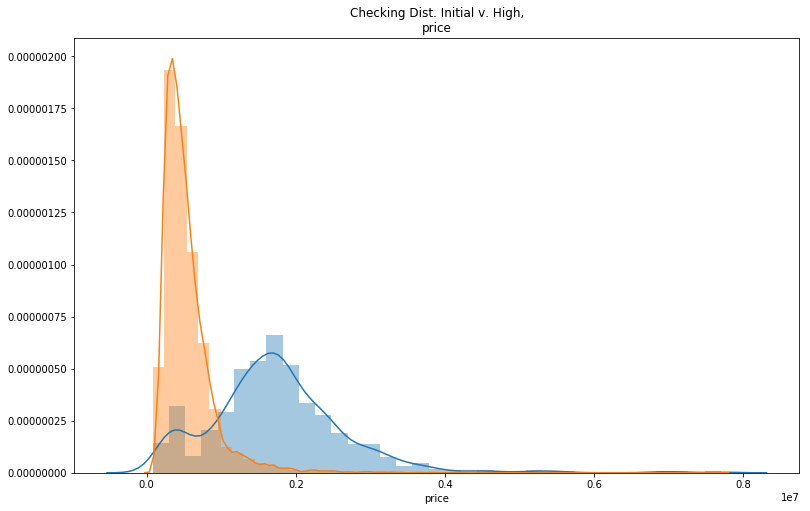

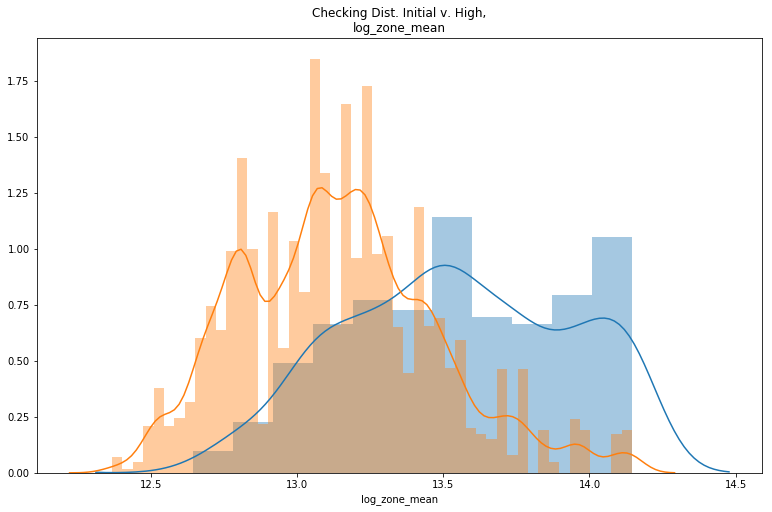

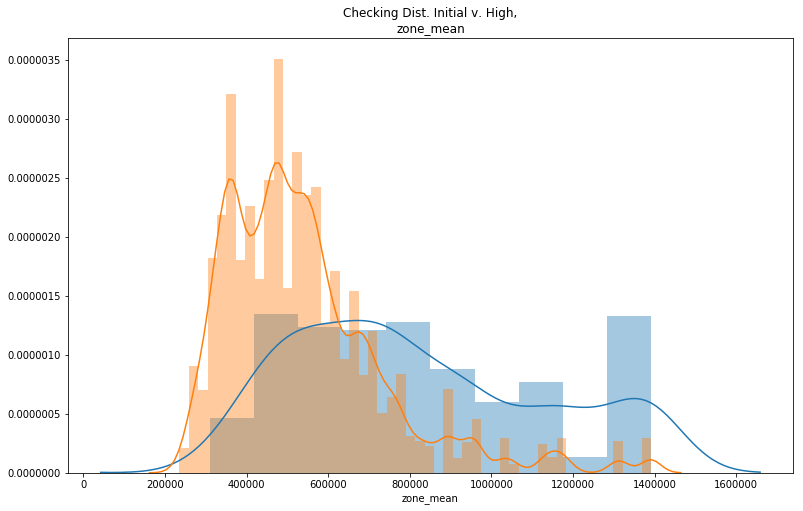

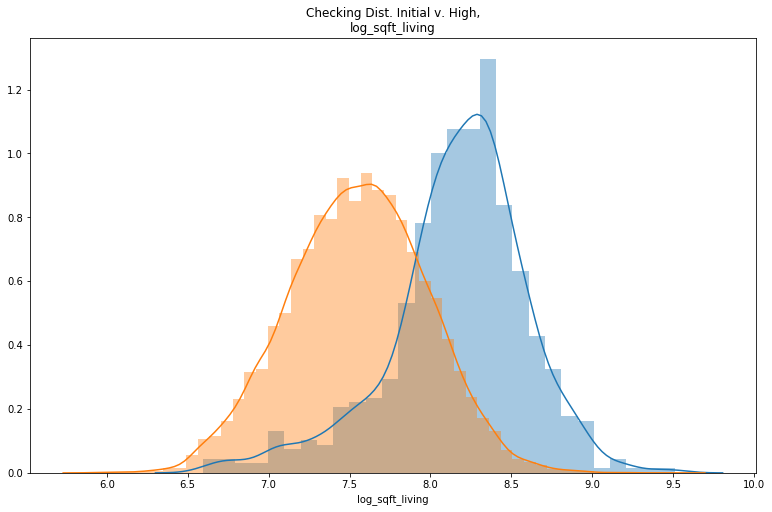

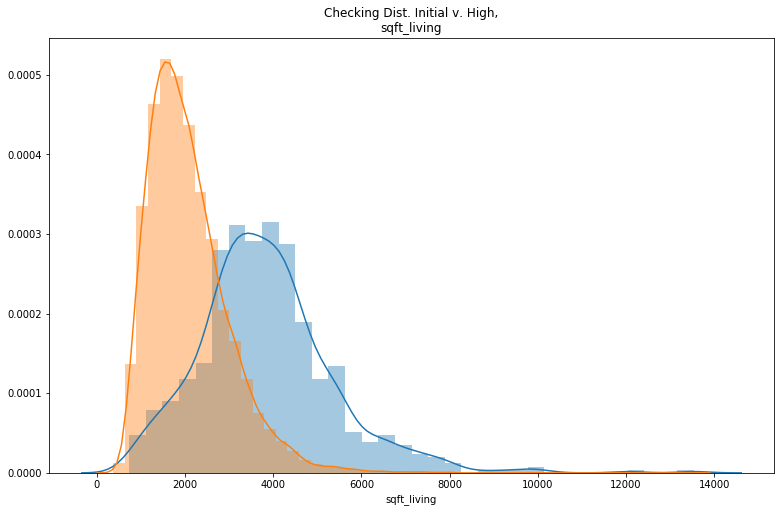

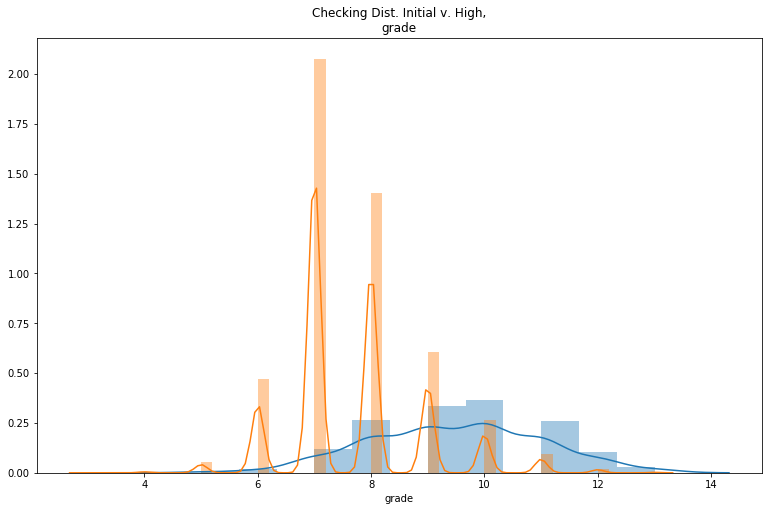

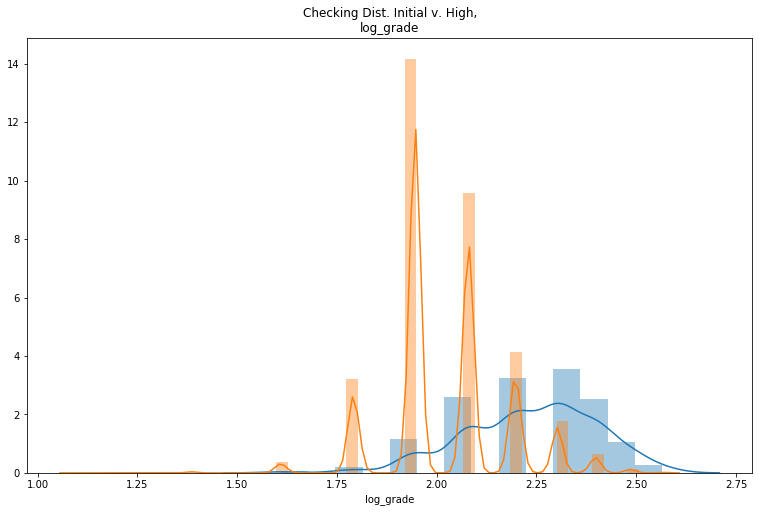

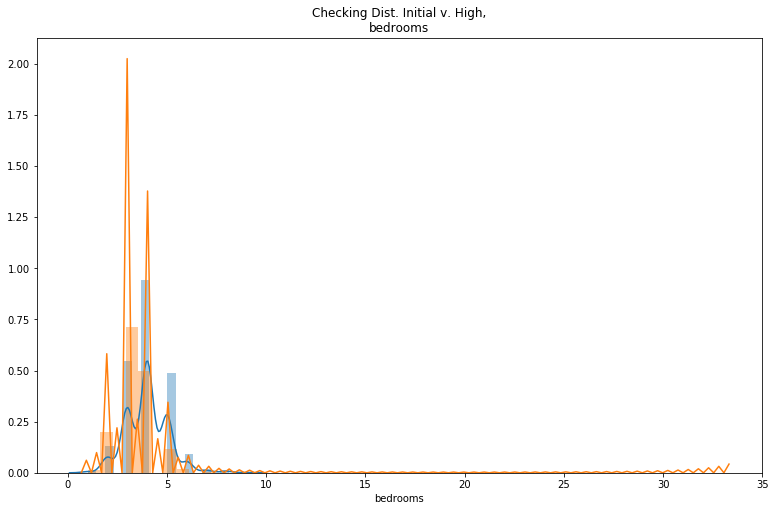

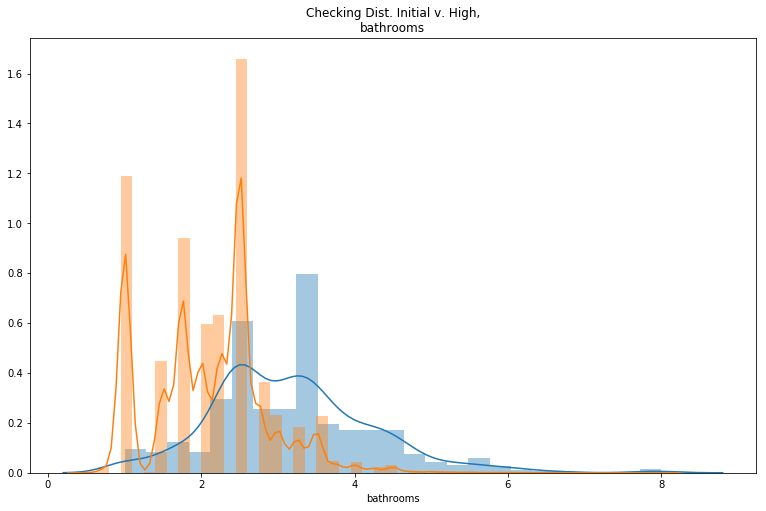

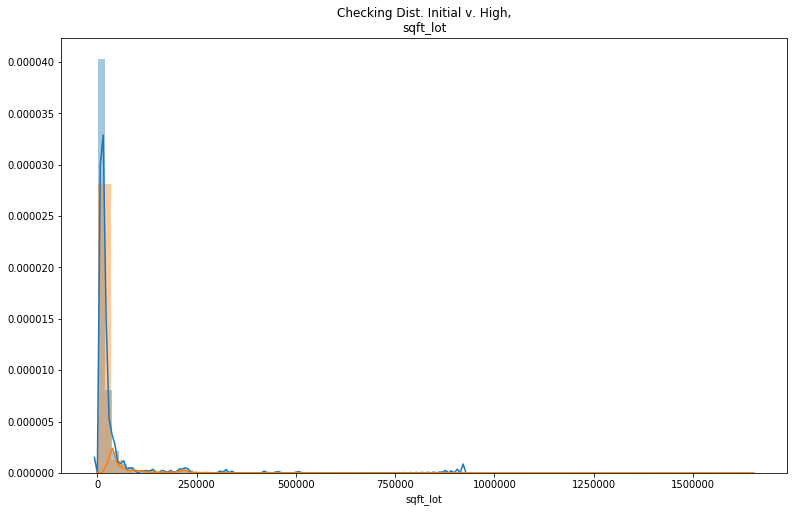

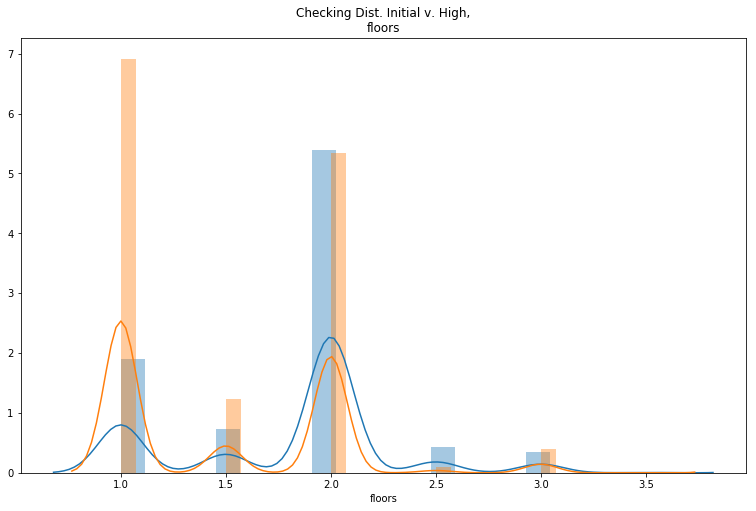

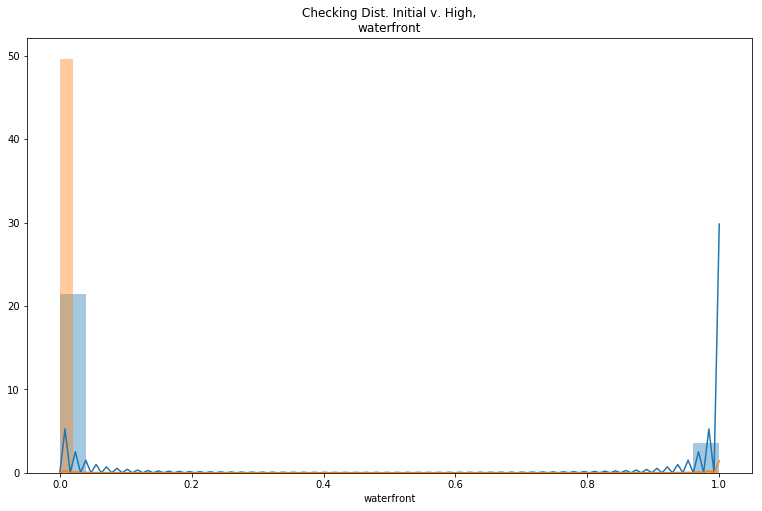

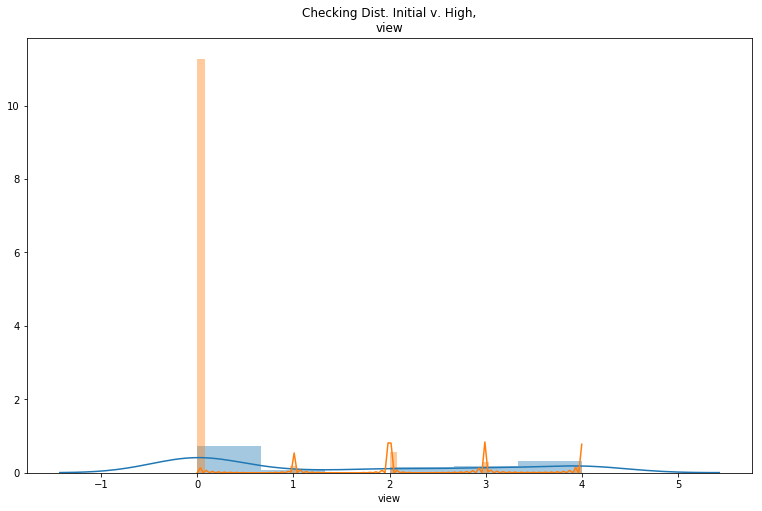

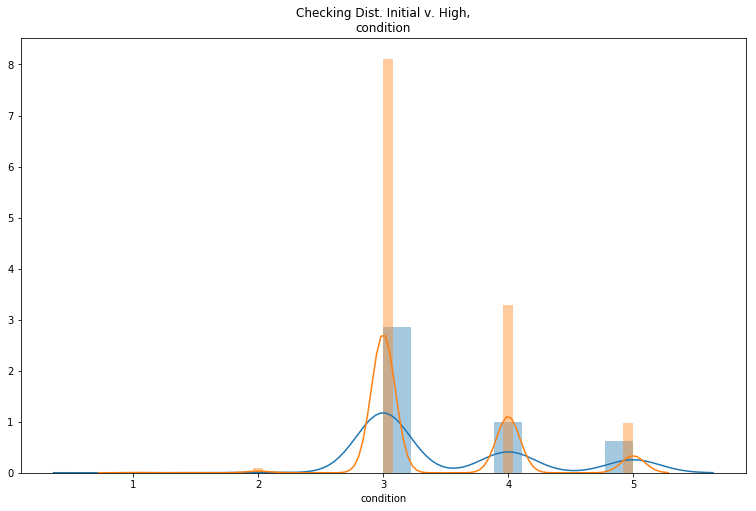

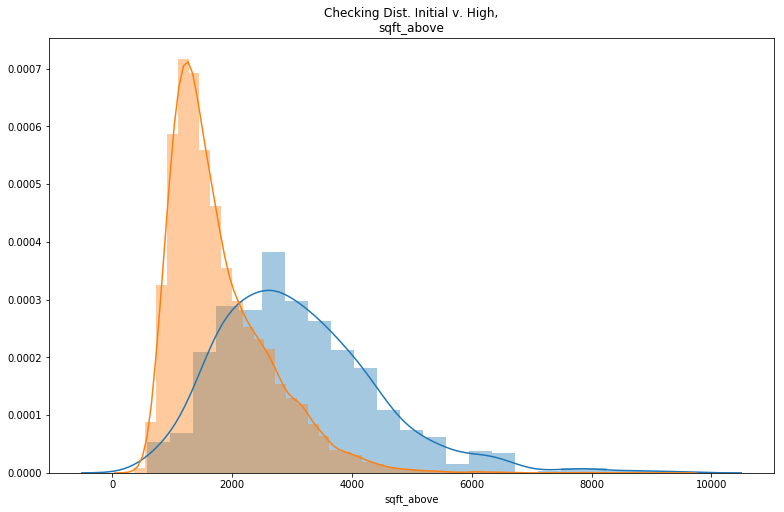

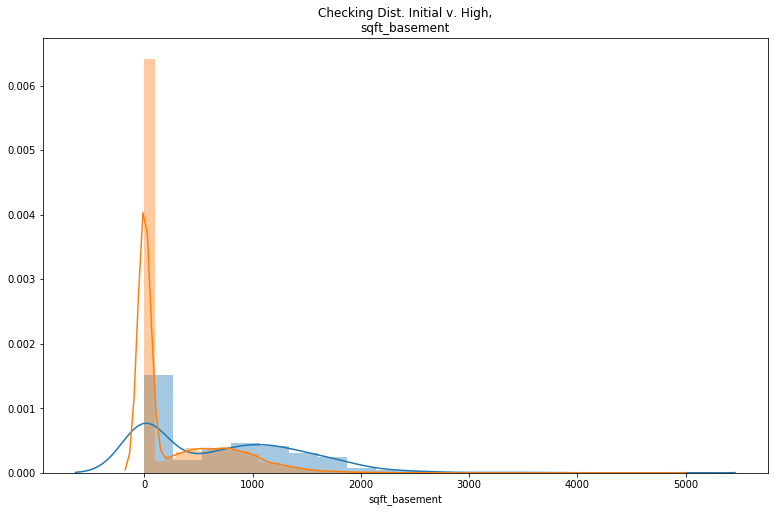

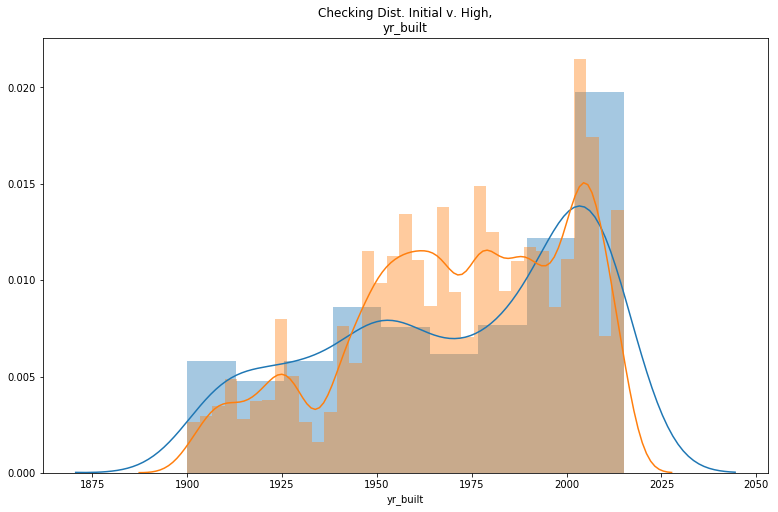

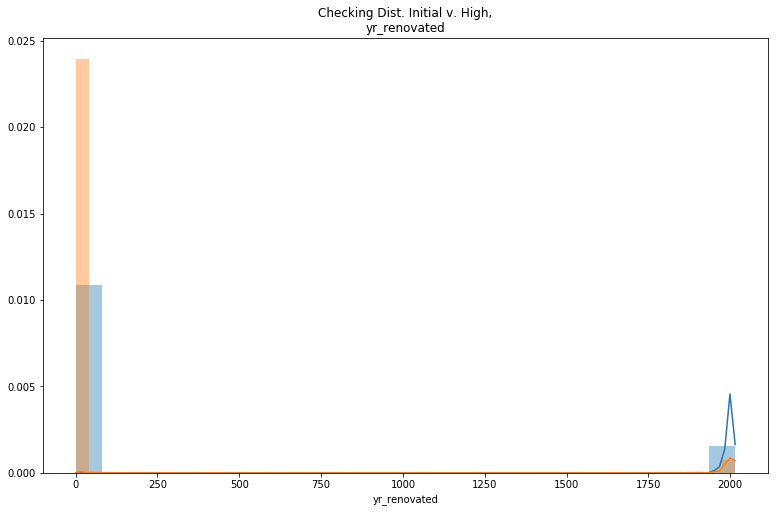

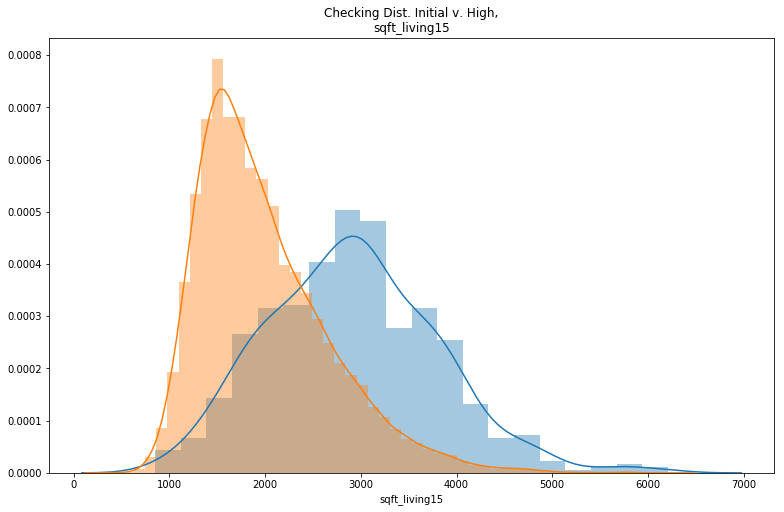

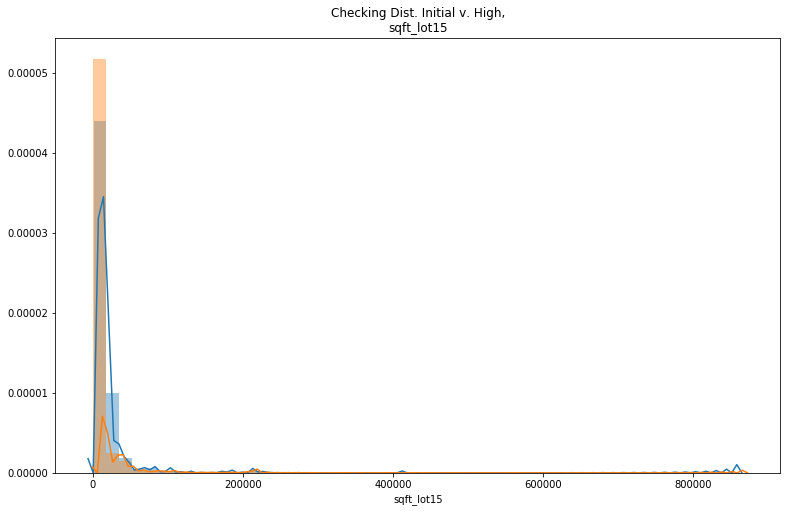

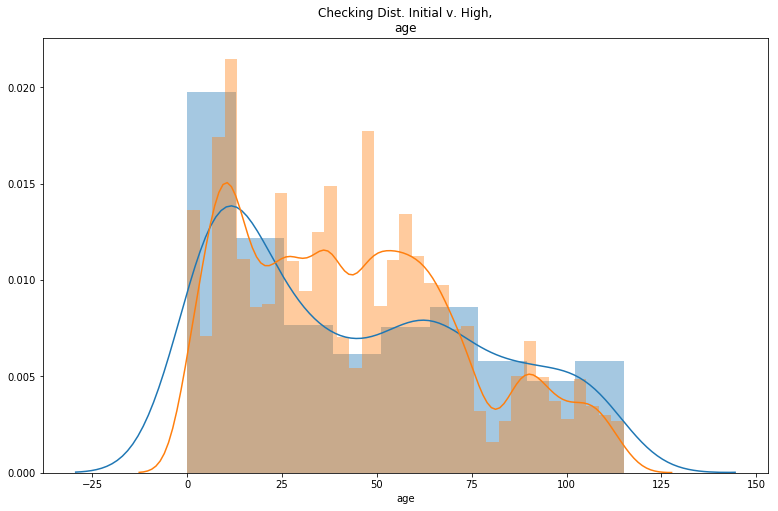

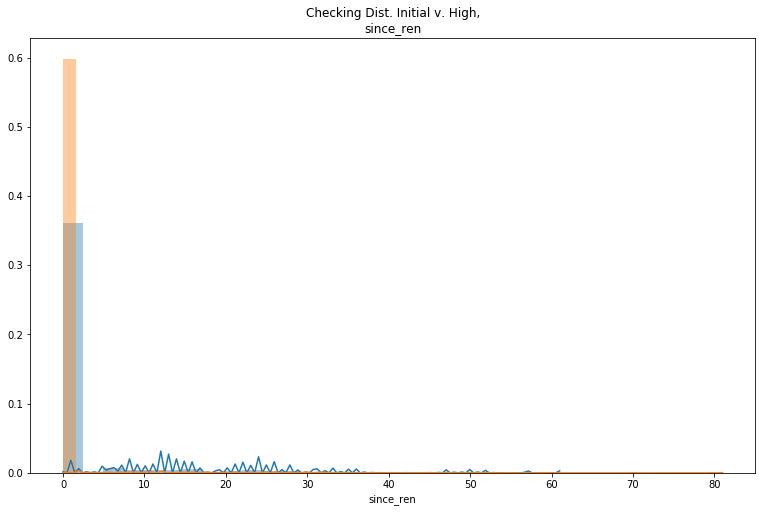

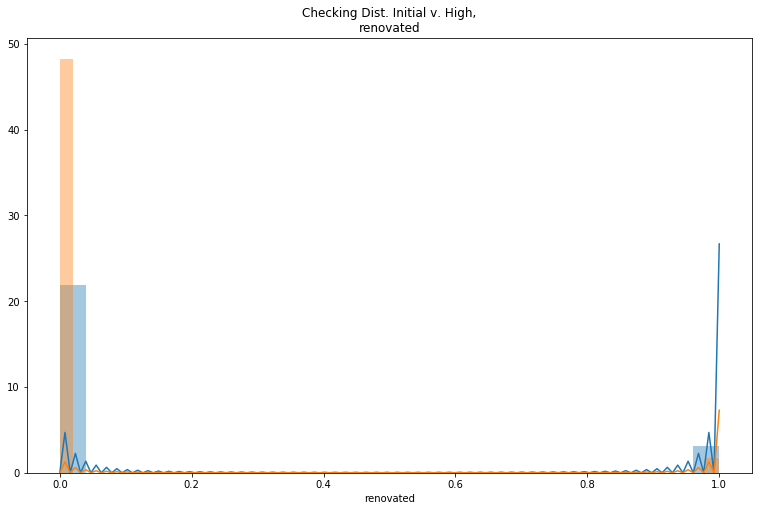

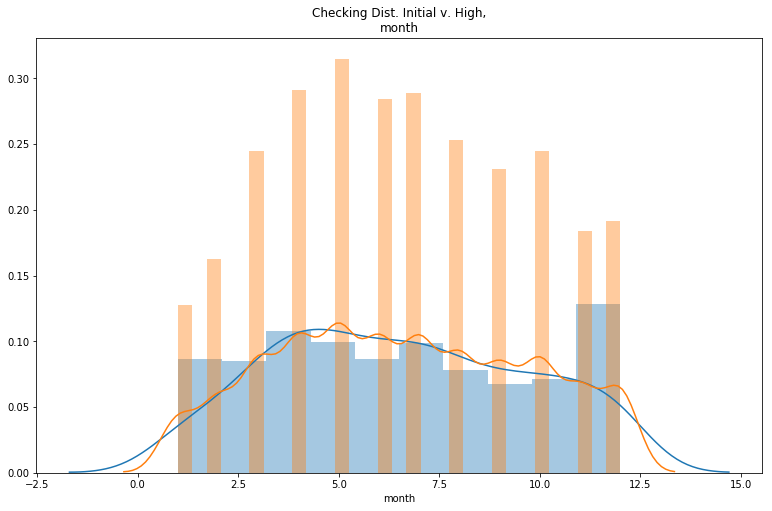

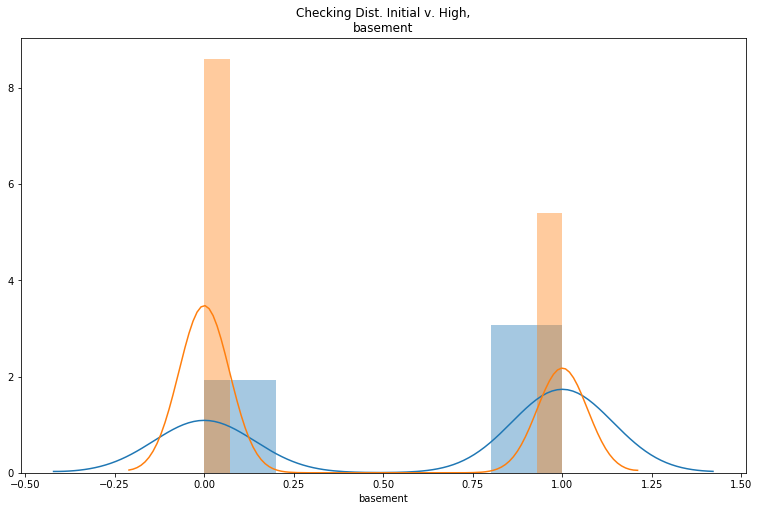

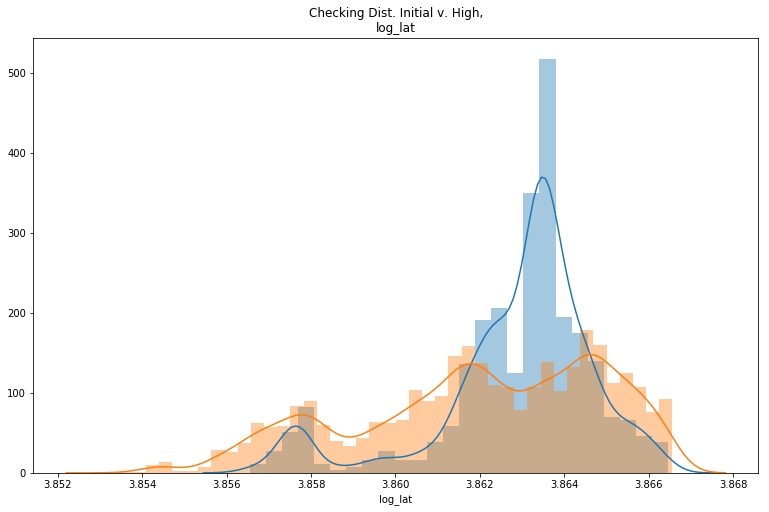

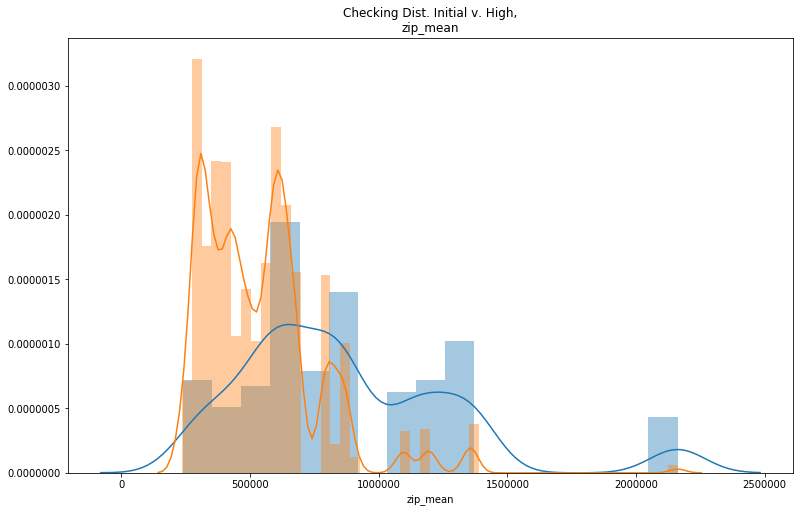

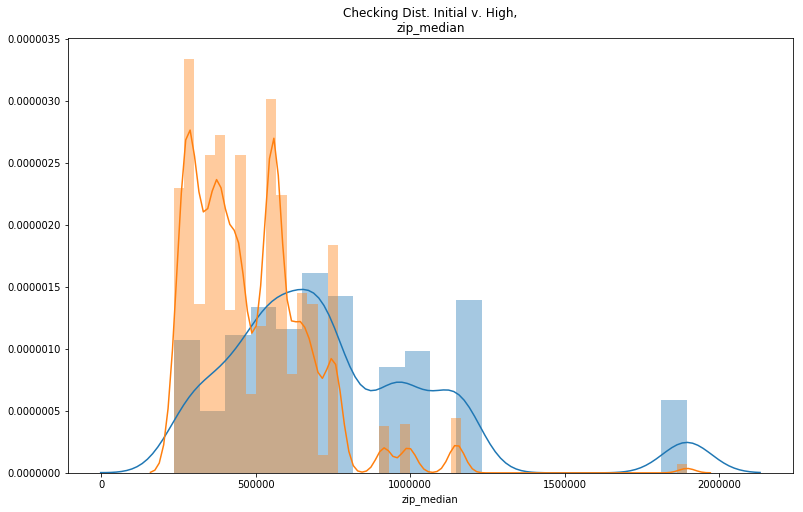

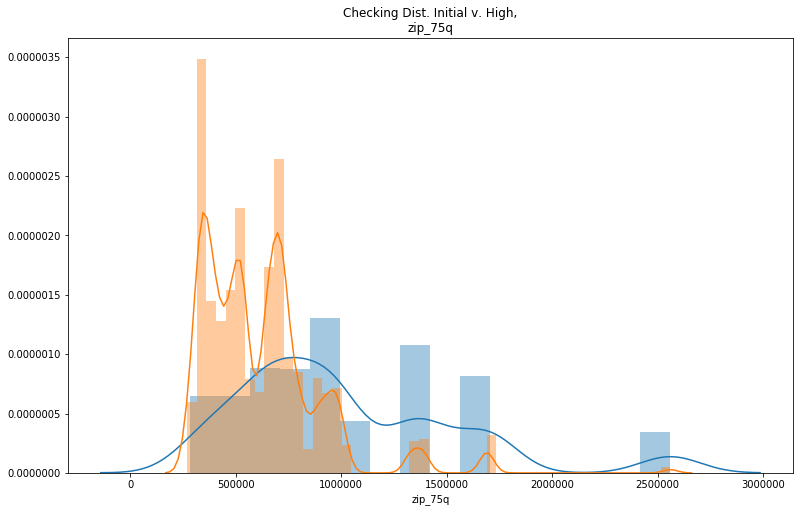

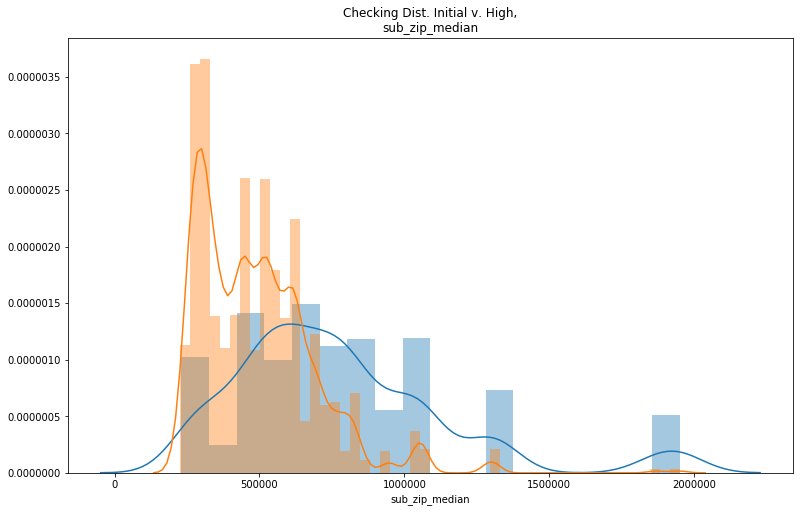

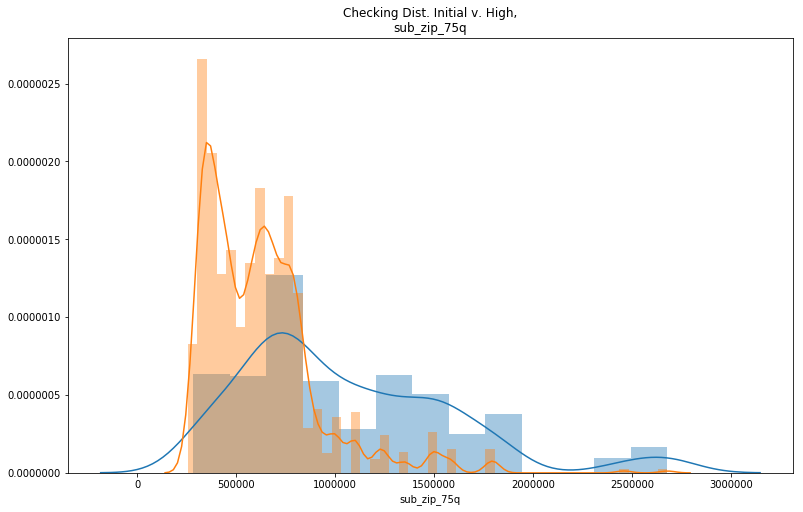

In [127]:
 
for col in ['price',
    'log_zone_mean',
    'zone_mean', 
    'log_sqft_living',
    'sqft_living',
    'grade',
    'log_grade',
    'bedrooms', 
    'bathrooms',
    'sqft_lot',
    'floors',
    'waterfront',
    'view',
    'condition',
    'sqft_above',
    'sqft_basement',
    'yr_built',
    'yr_renovated',
    'sqft_living15',
    'sqft_lot15',
    'age',
    'since_ren',
    'renovated',
    'month',
    'basement',
    'log_lat',
    'zip_mean',
    'zip_median',
    'zip_75q',
    'sub_zip_median',
    'sub_zip_75q']:
    resd_check(results, data, col)

#### OLS Test 18
-will log transform  zone_mean

##### Residual Check 1
Around 3% of the residuals are outside of 2 standard deviations . I will check the model to see if the regression improves.

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                 3.060e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        18:17:55   Log-Likelihood:            -3.0192e+05
No. Observations:               21597   AIC:                         6.038e+05
Df Residuals:                   21594   BIC:                         6.039e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_sqft_living -1.825e+04   6167.426     

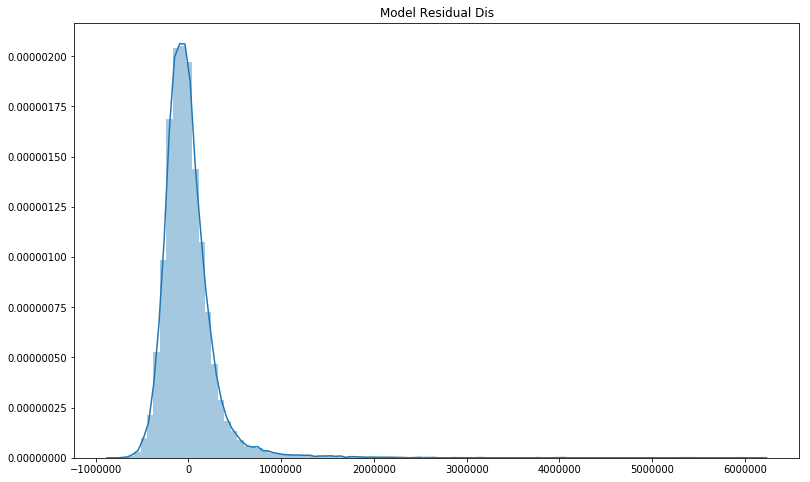

In [128]:
columns= ['log_sqft_living', 'grade', 'log_zone_mean']

ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');

#### Test 19
Linearity good. R squared acceptable. Take out outilier (3%) shouold get better.

Going to min_max scale the log_zone_mean

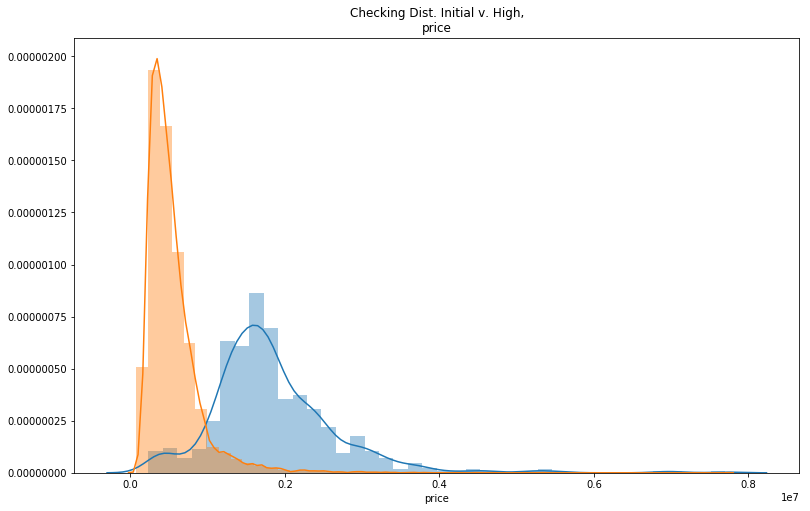

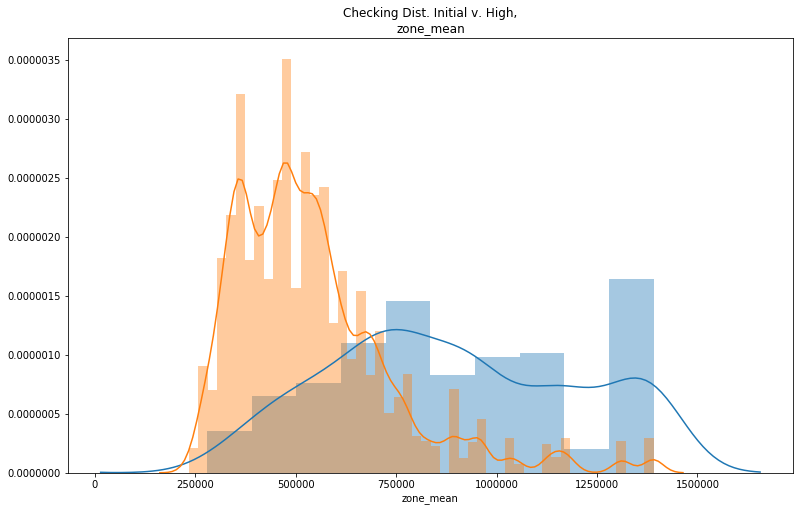

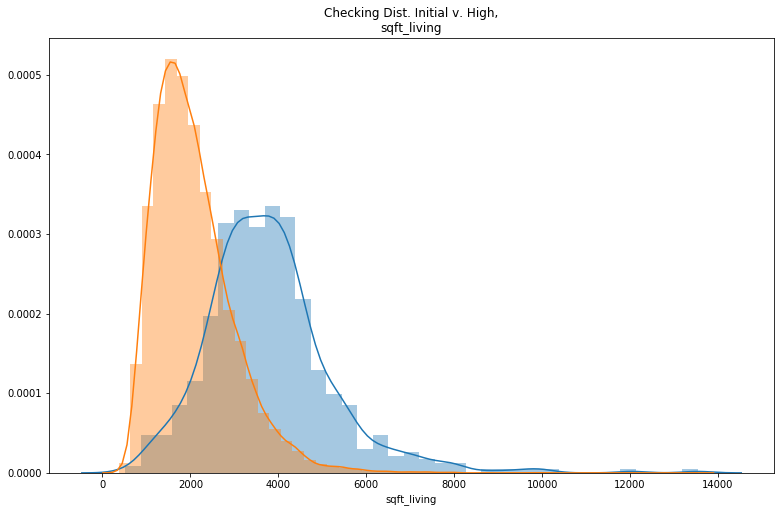

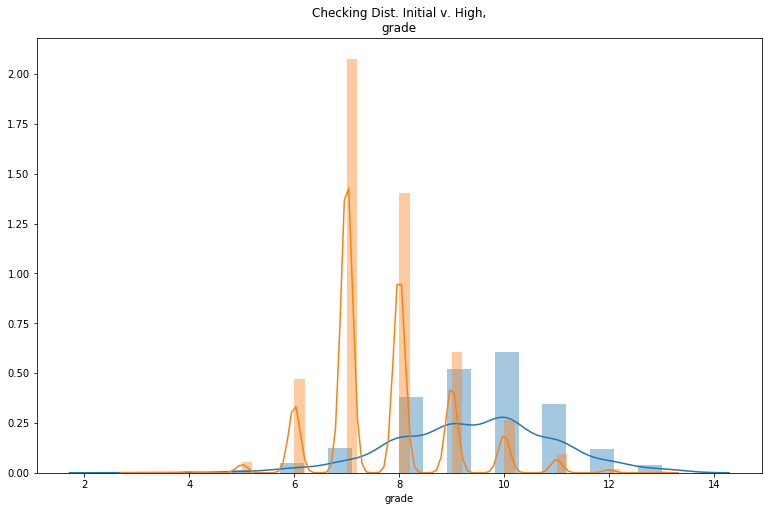

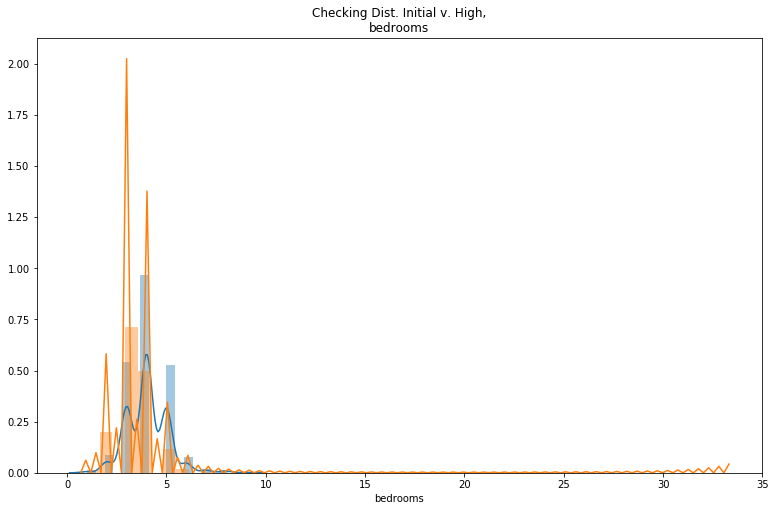

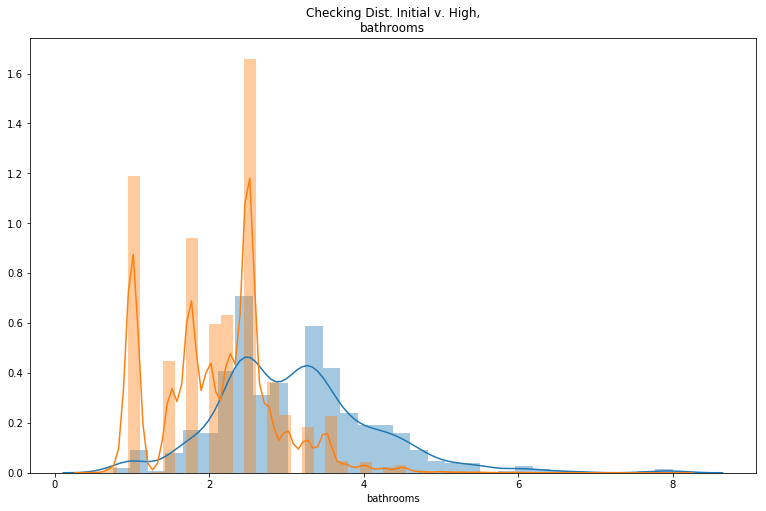

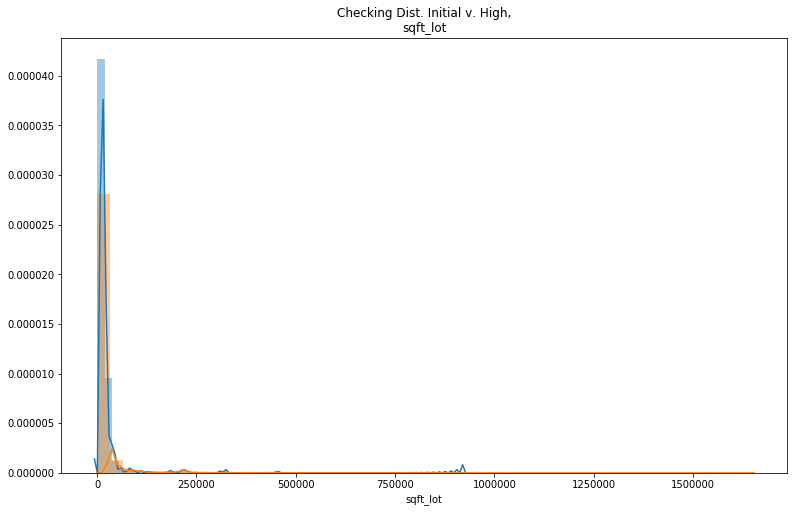

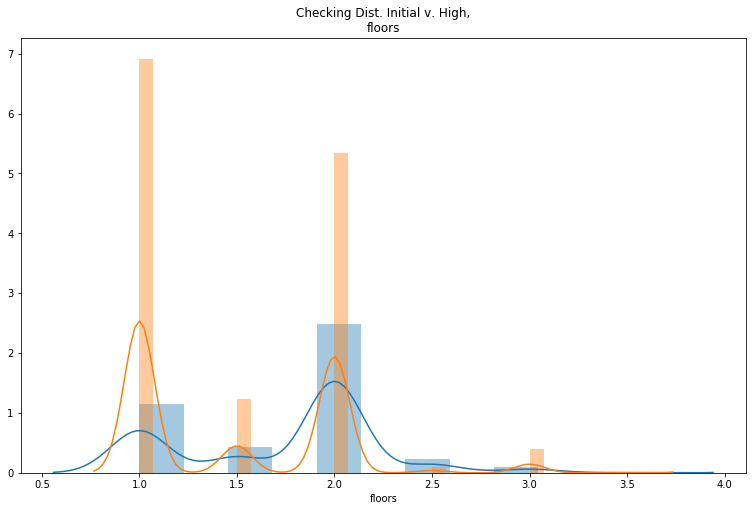

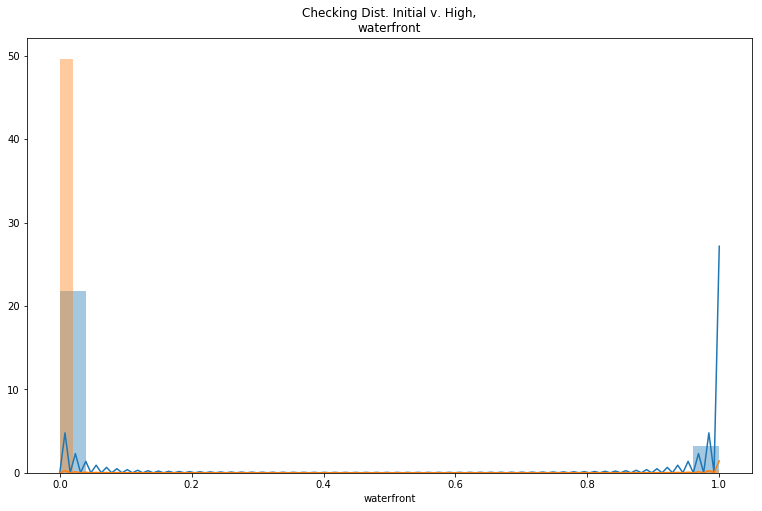

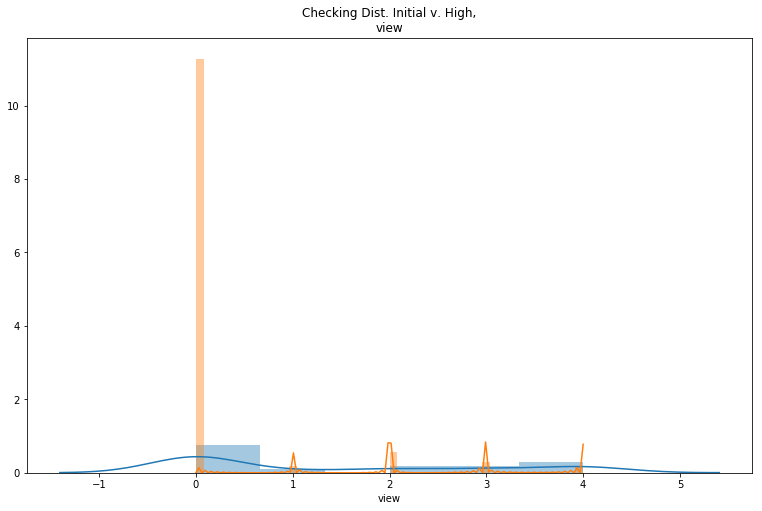

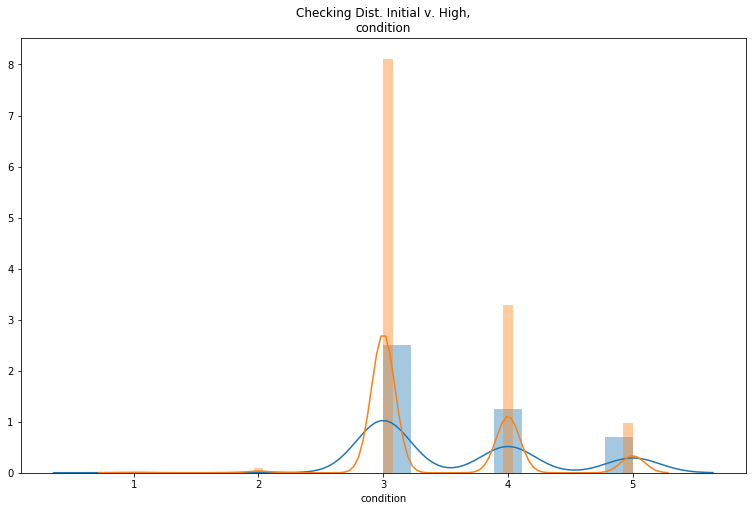

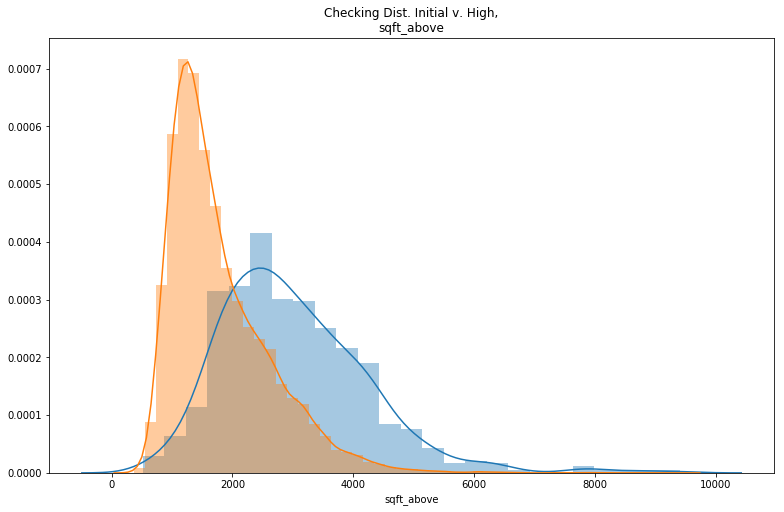

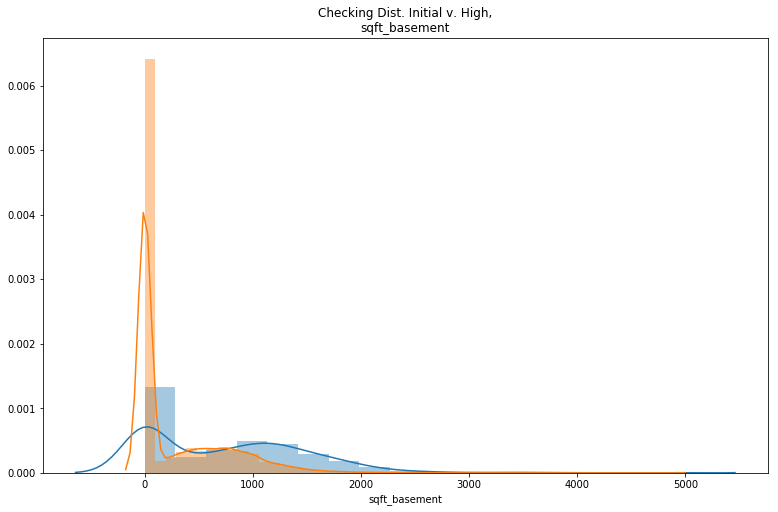

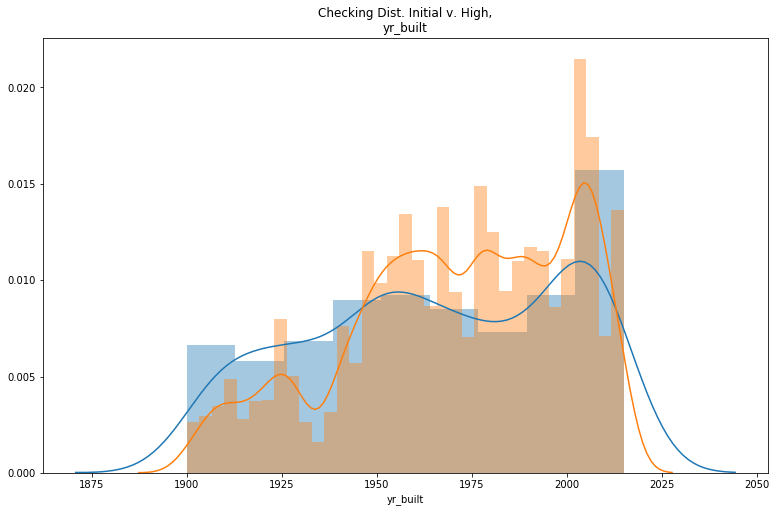

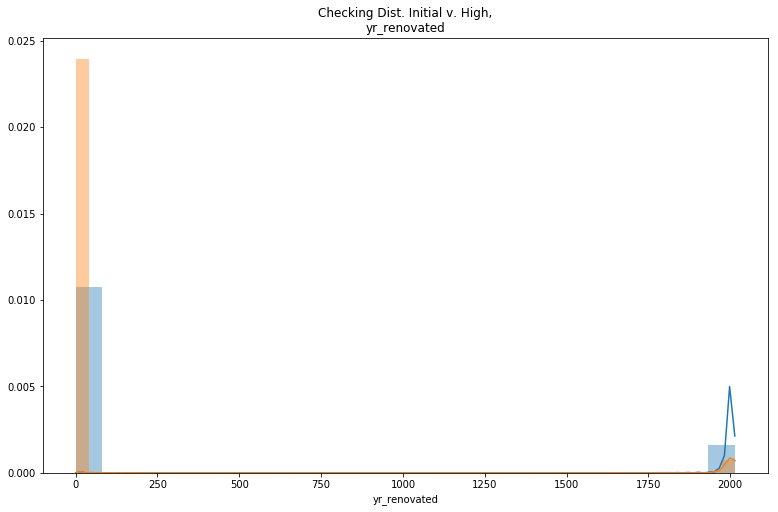

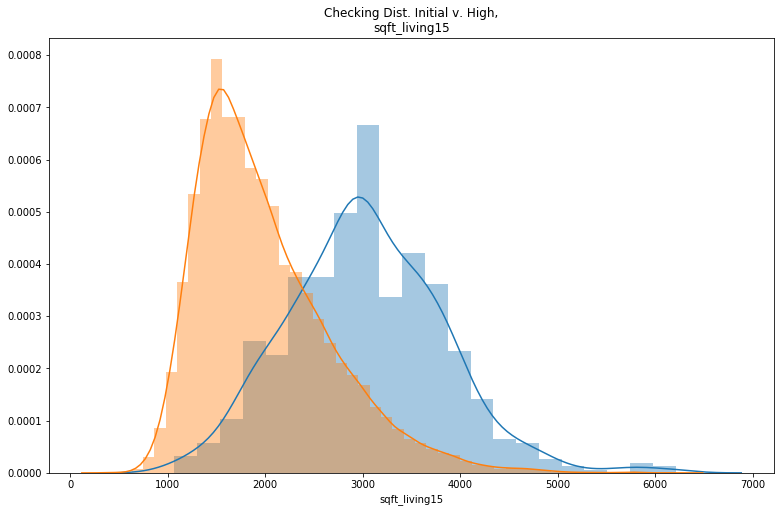

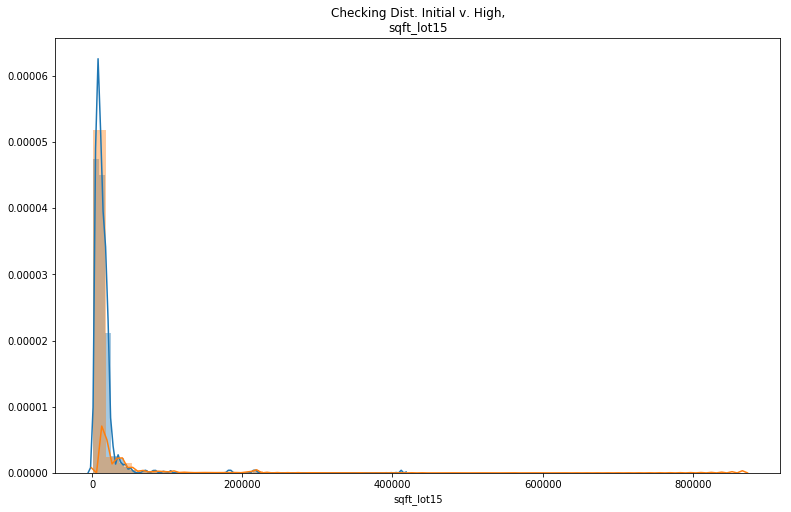

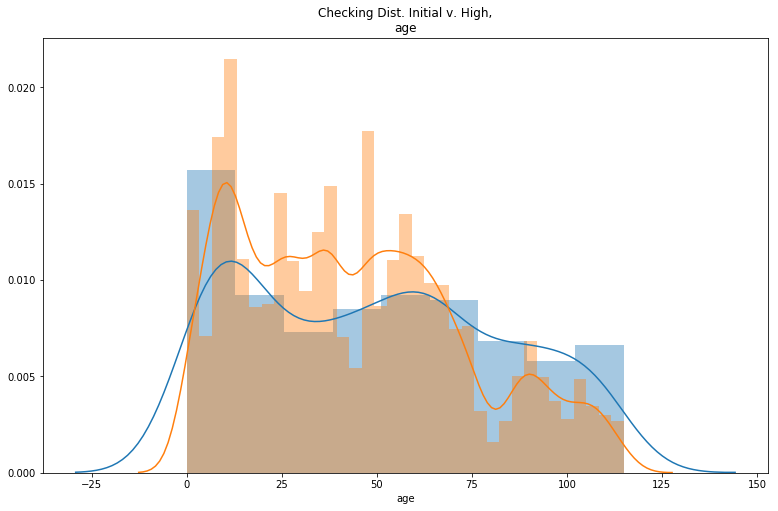

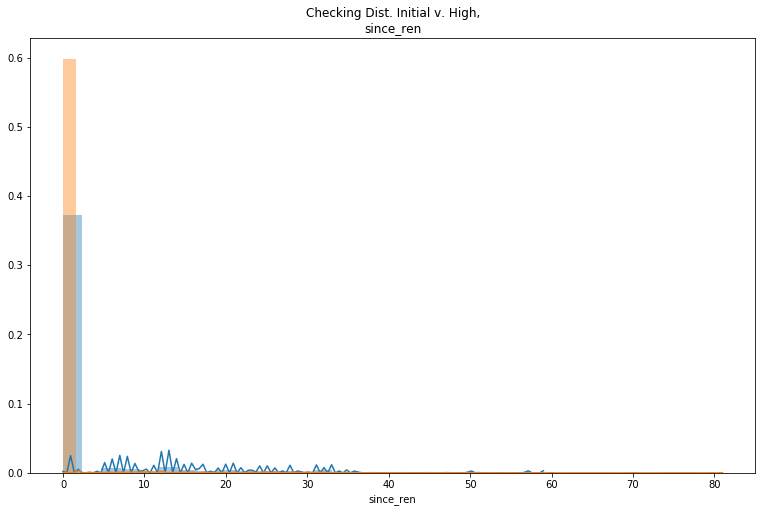

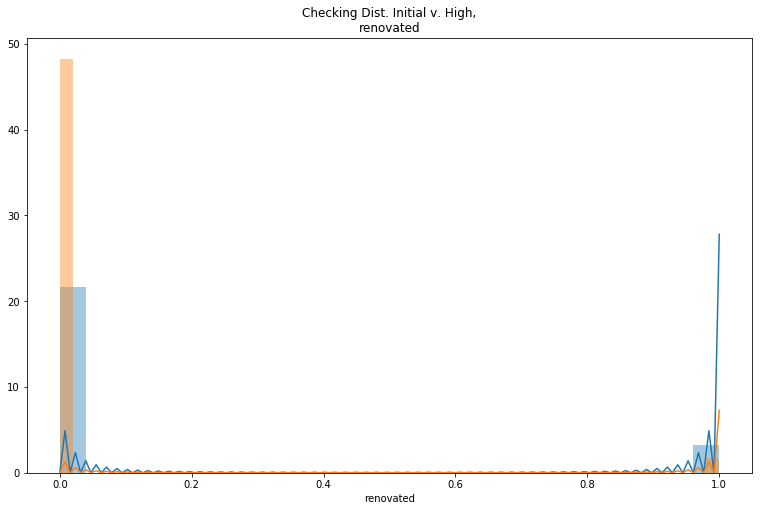

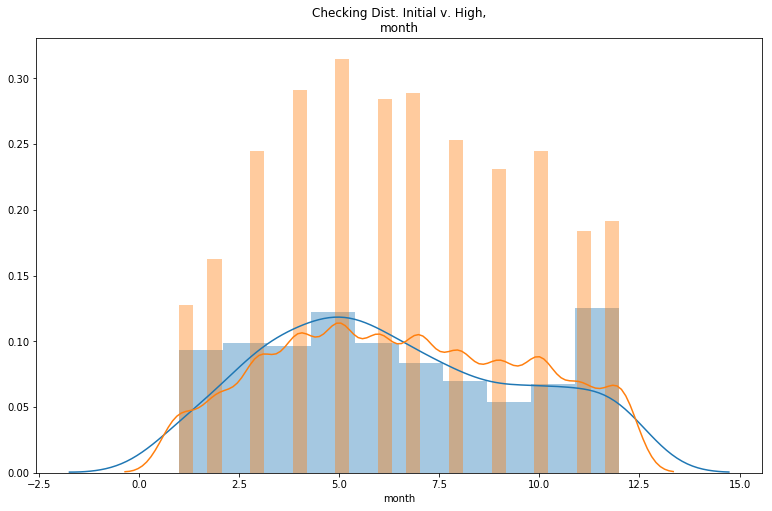

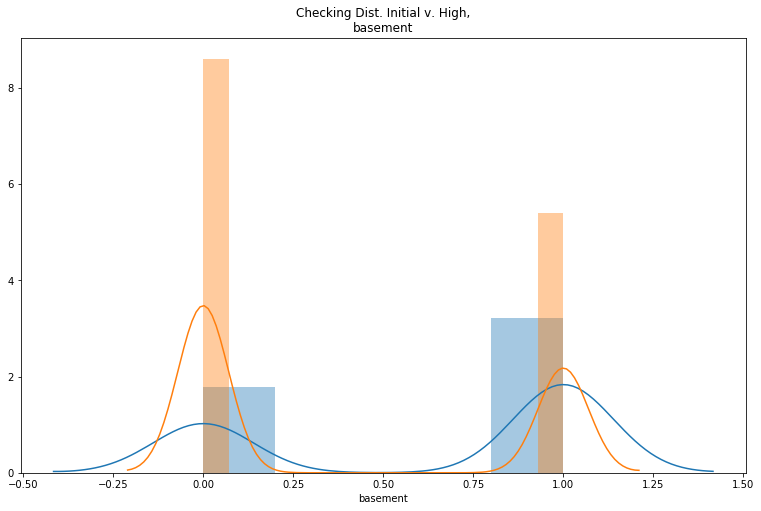

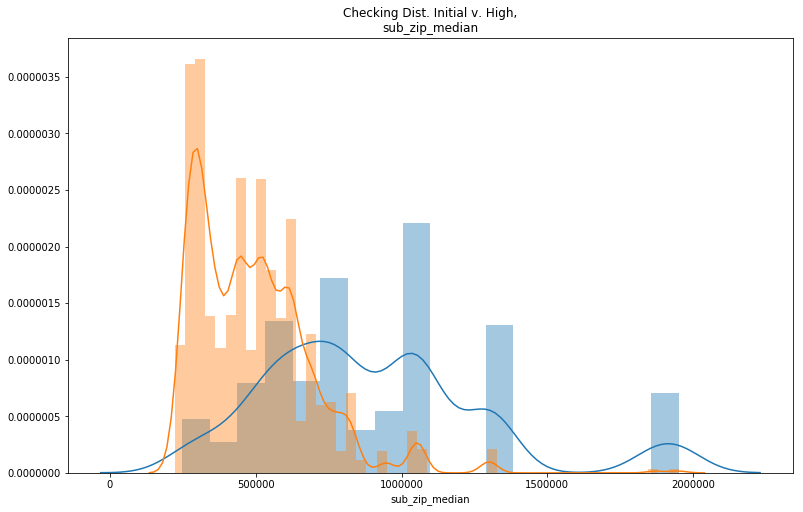

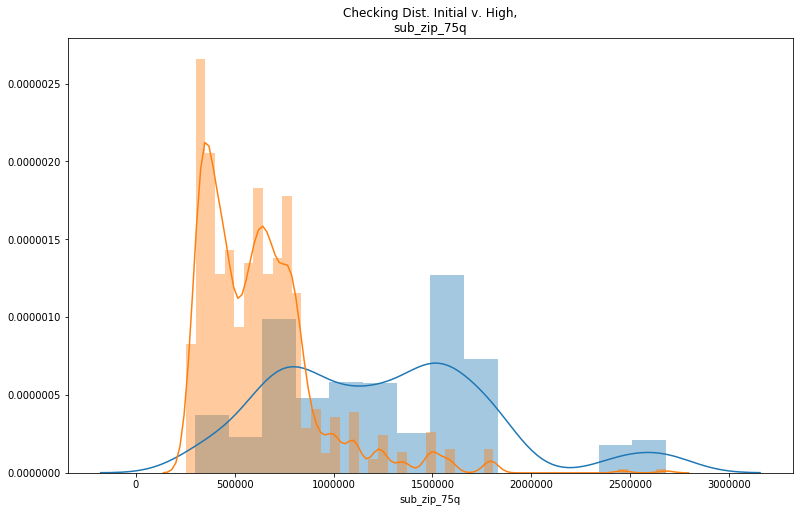

In [129]:
for col in ['price',
'zone_mean', 
'sqft_living',
'grade',
'bedrooms', 
'bathrooms',
'sqft_lot',
'floors',
'waterfront',
'view',
'condition',
'sqft_above',
'sqft_basement',
'yr_built',
'yr_renovated',
'sqft_living15',
'sqft_lot15',
'age',
'since_ren',
'renovated',
'month',
'basement',
'sub_zip_median',
'sub_zip_75q']:
    resd_check(results, data, col)

count    21597.000000
mean         0.434736
std          0.189408
min          0.000000
25%          0.285129
50%          0.428124
75%          0.544492
max          1.000000
Name: min_max_log_zone_mean, dtype: float64

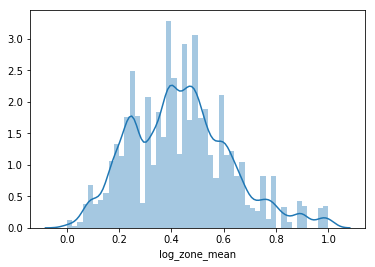

In [130]:
sns.distplot(min_max(data.log_zone_mean))
data['min_max_log_zone_mean'] =min_max(data.log_zone_mean)
data.min_max_log_zone_mean.describe()

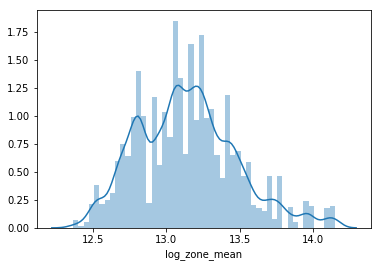

In [131]:
sns.distplot((data.log_zone_mean))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                 3.722e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        18:18:05   Log-Likelihood:            -3.0017e+05
No. Observations:               21597   AIC:                         6.004e+05
Df Residuals:                   21594   BIC:                         6.004e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
log_sqft_living       -1.513e+

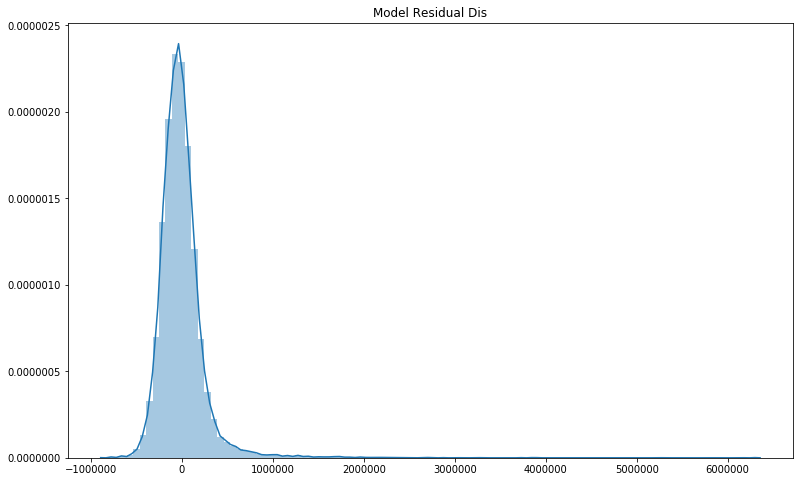

In [132]:
columns= ['log_sqft_living', 'grade', 'min_max_log_zone_mean']

ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');

#### Test 20
Going to min_max scale the grade

In [133]:
data['min_max_grade'] = min_max(data.grade)

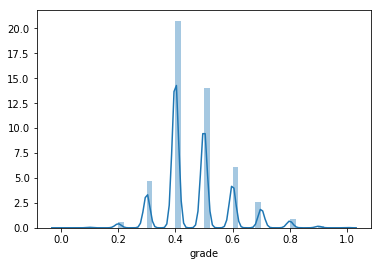

In [134]:
sns.distplot(min_max(data.grade))


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                 4.071e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        20:36:59   Log-Likelihood:            -2.9936e+05
No. Observations:               21597   AIC:                         5.987e+05
Df Residuals:                   21594   BIC:                         5.987e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
log_sqft_living       -7.693e+

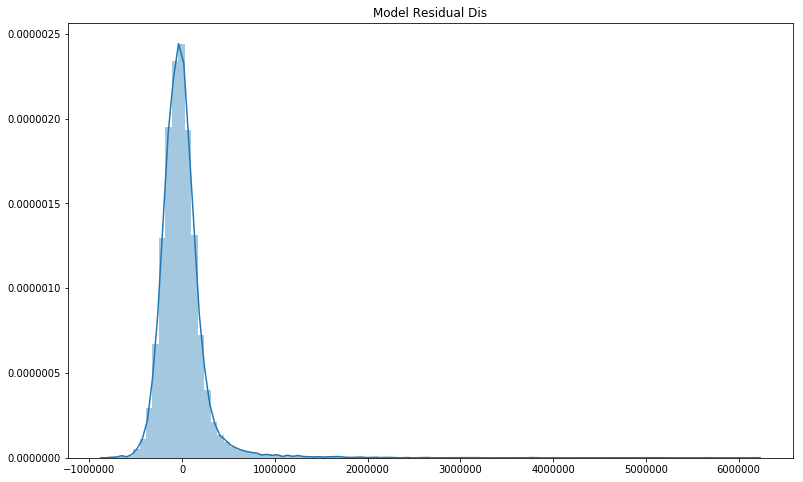

In [193]:
columns= ['log_sqft_living', 'min_max_grade', 'min_max_log_zone_mean']

ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');
data['residual'] = results.resid
keep_data = data.loc[data.residual.abs() <= data.residual.std()*2] # removed anything above 3 std deviation in the residuals. 
removed_data = data.loc[data.residual.abs() > data.residual.std()*2]  

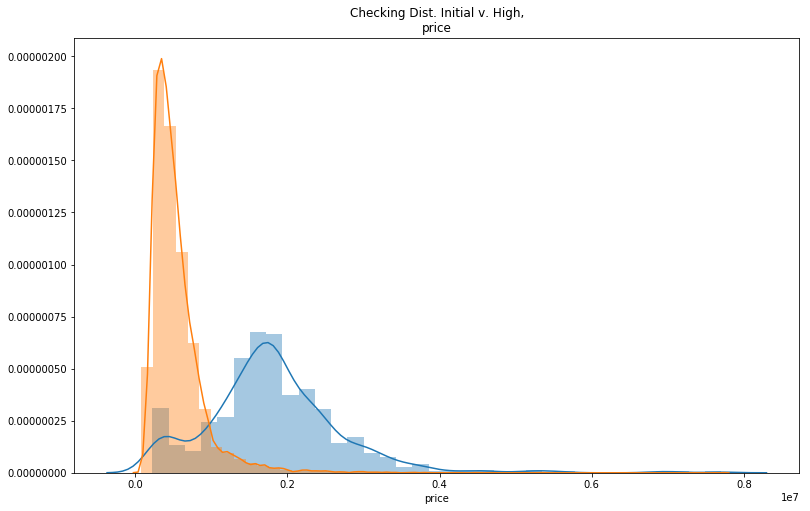

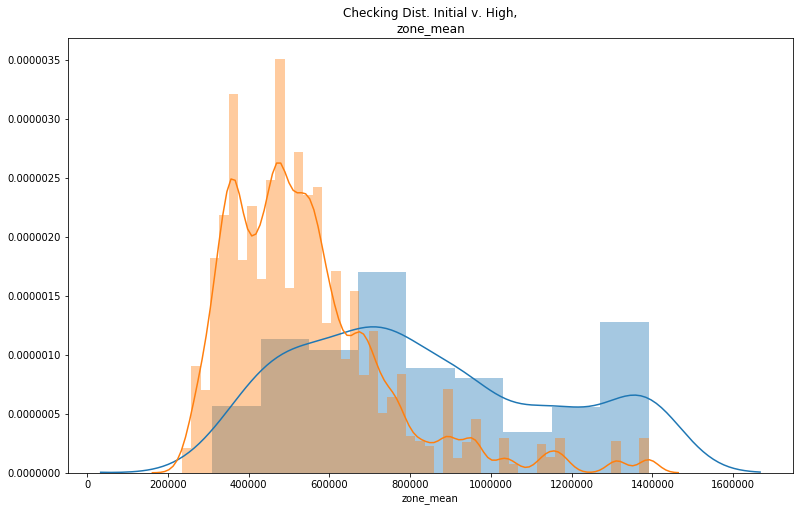

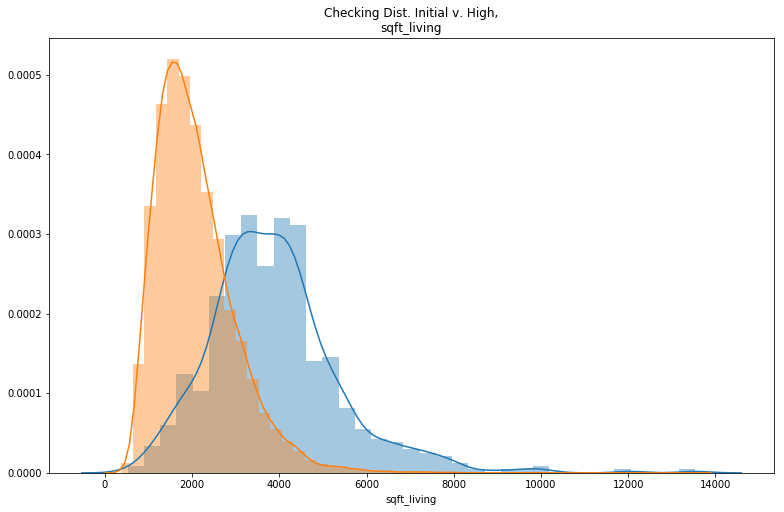

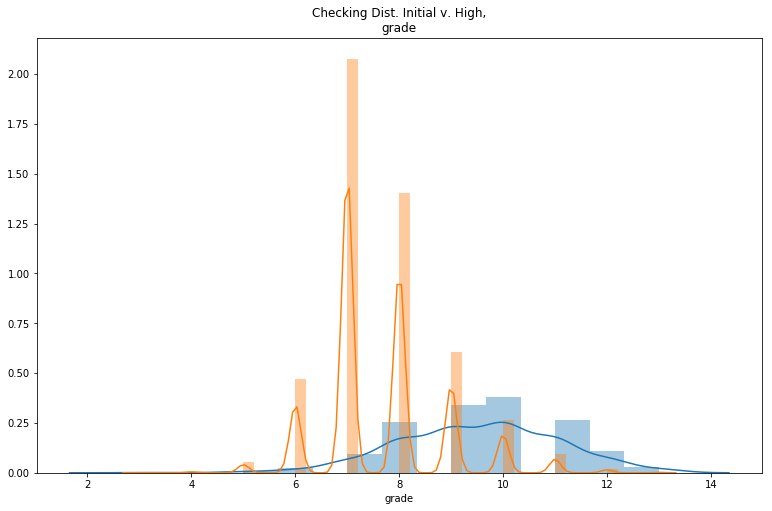

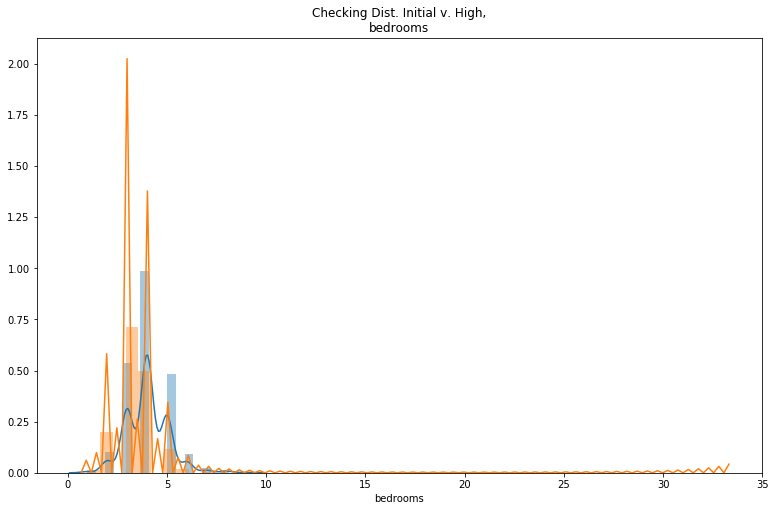

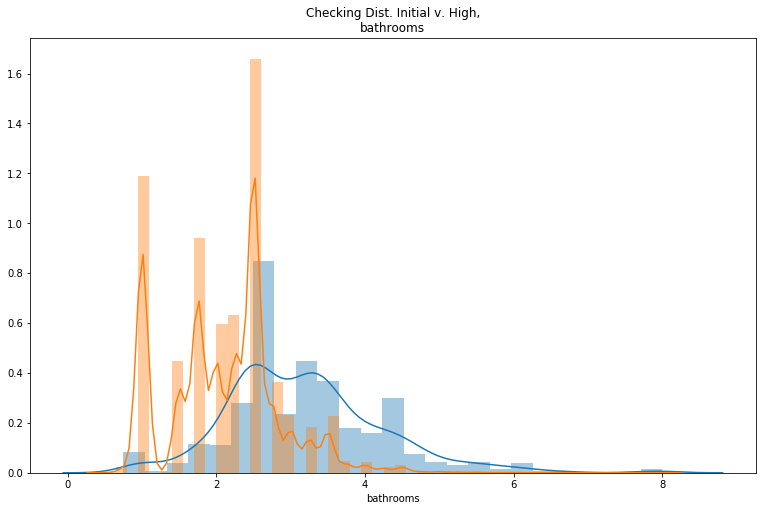

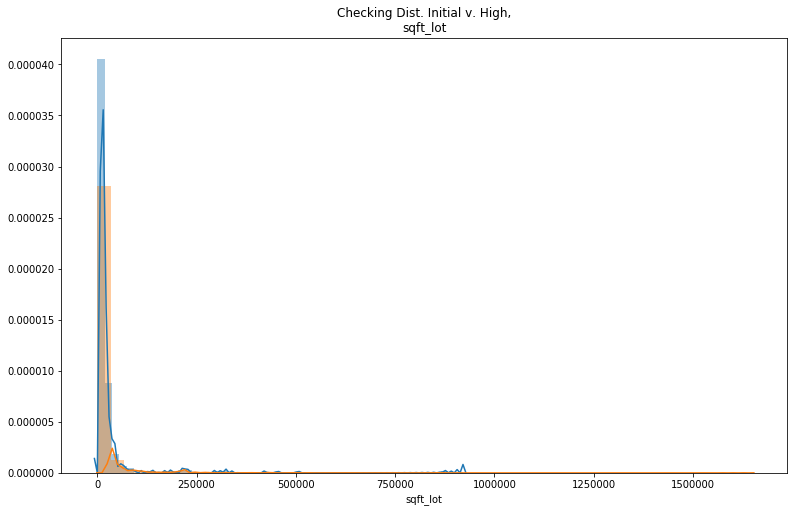

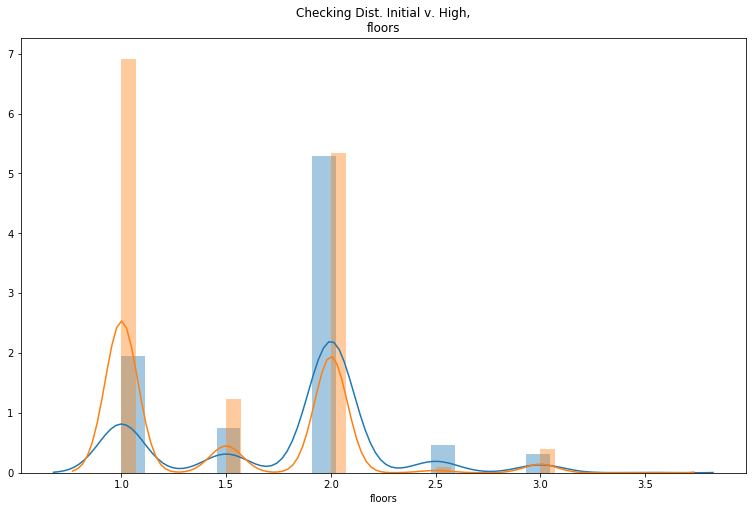

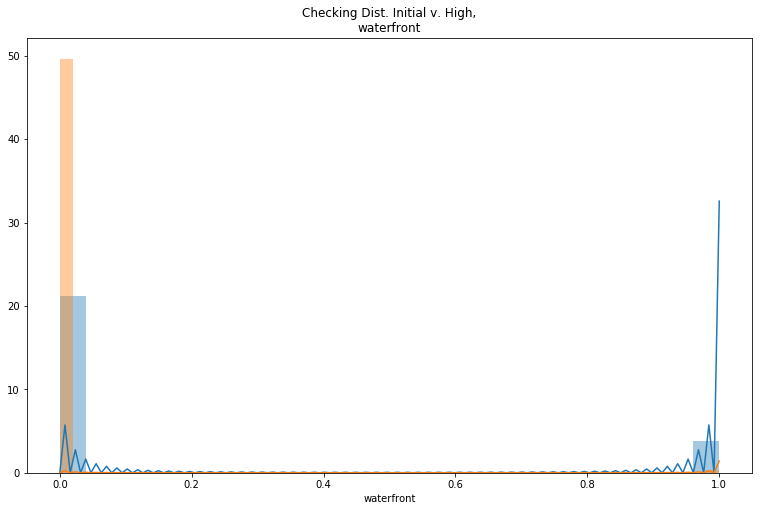

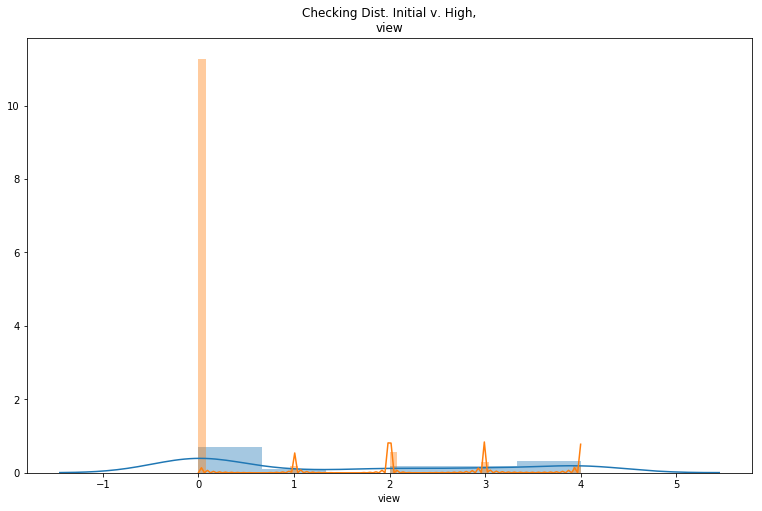

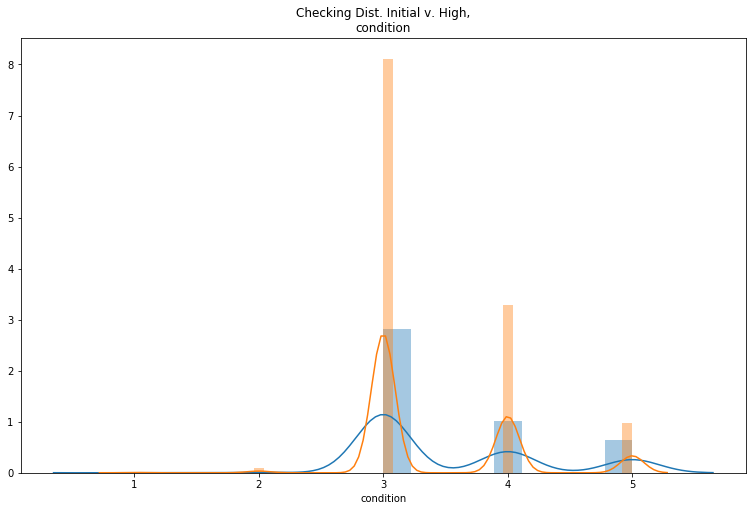

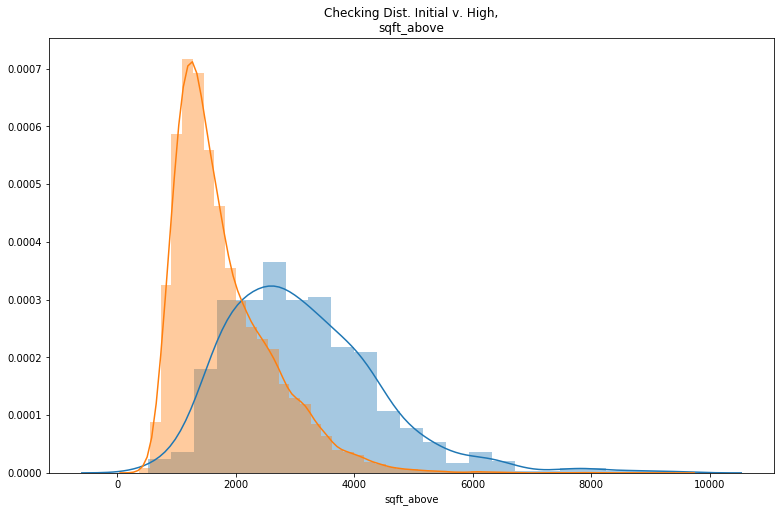

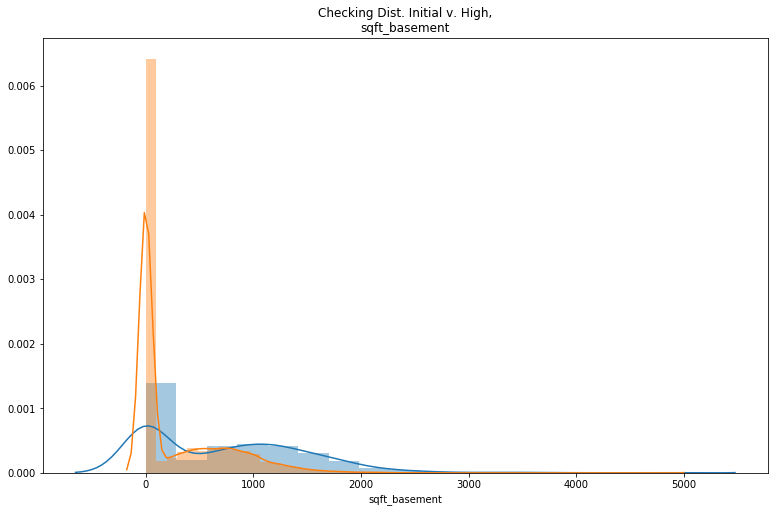

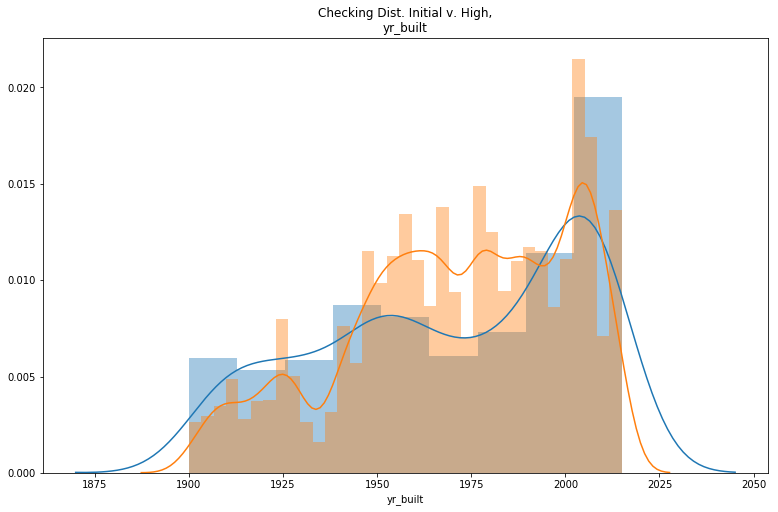

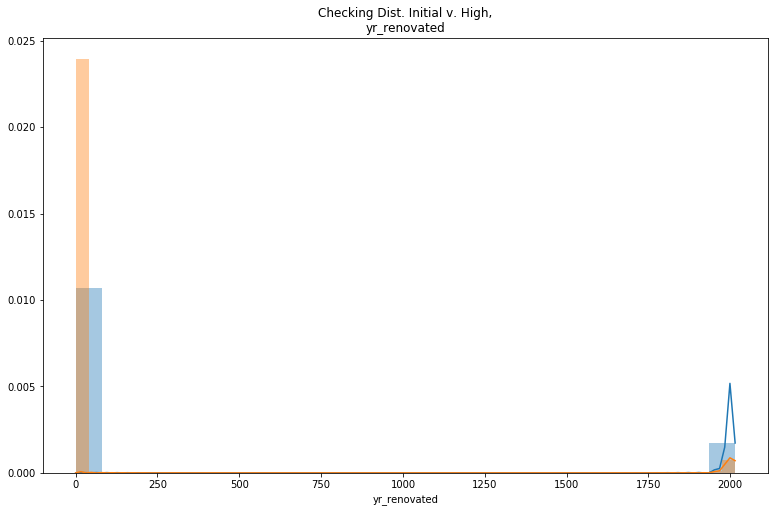

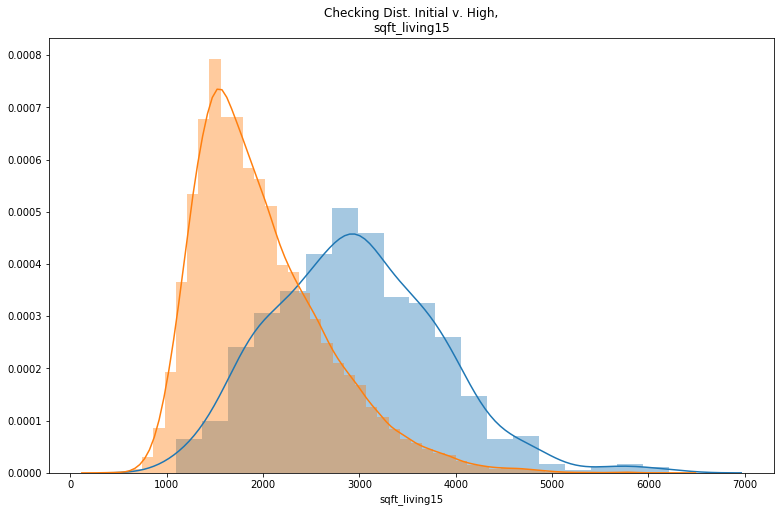

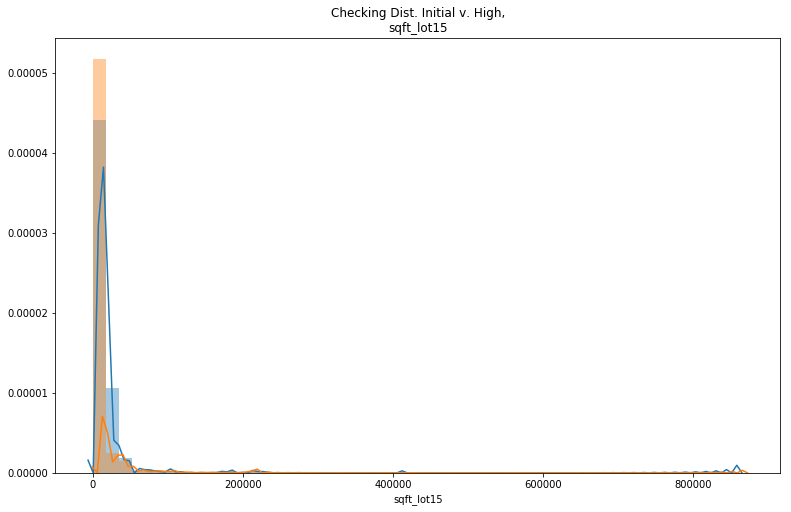

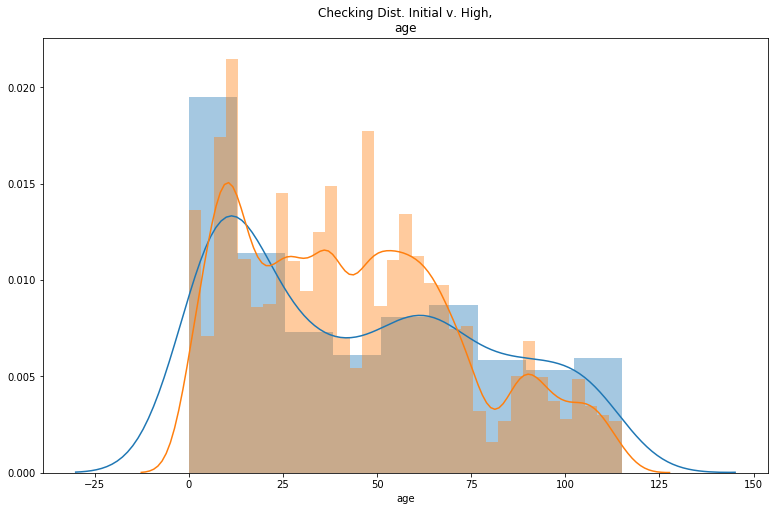

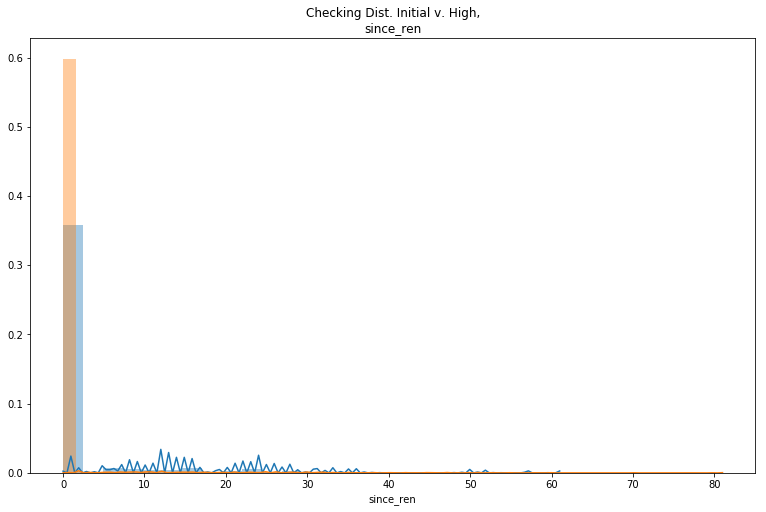

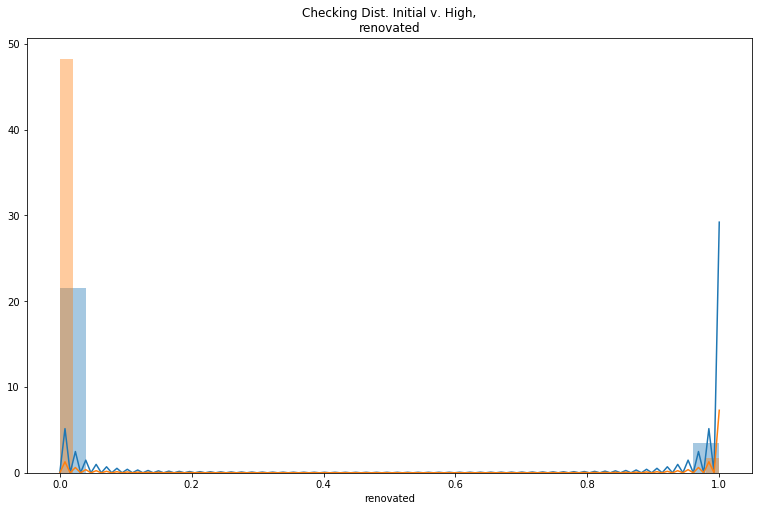

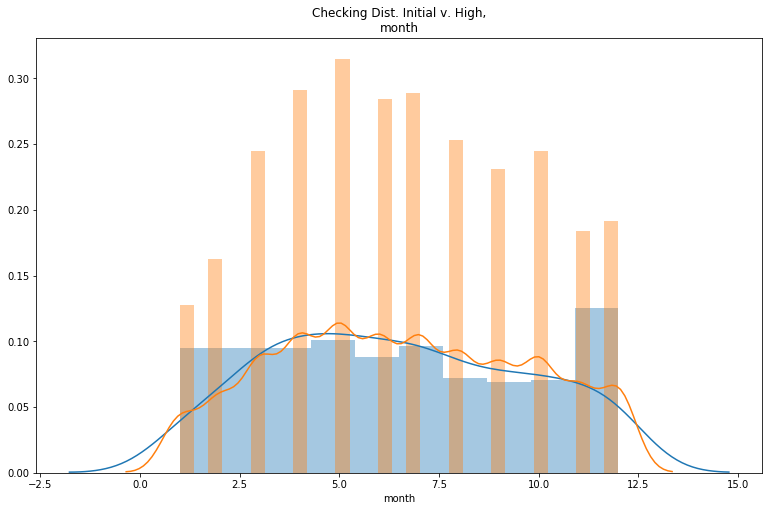

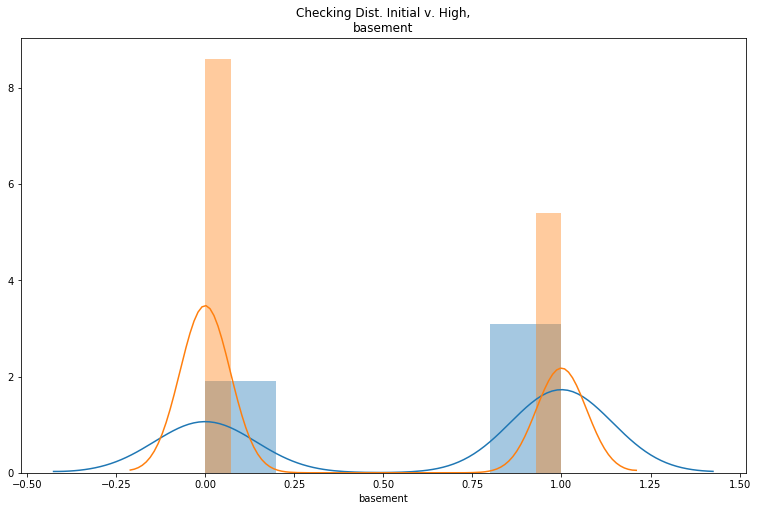

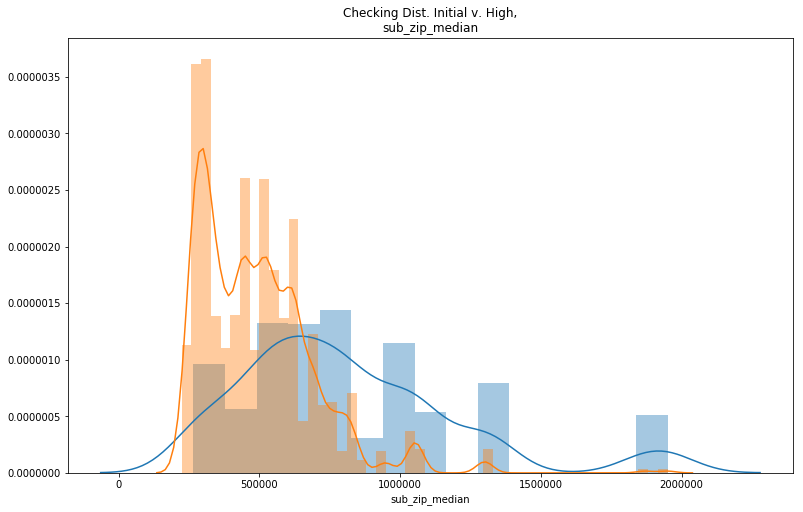

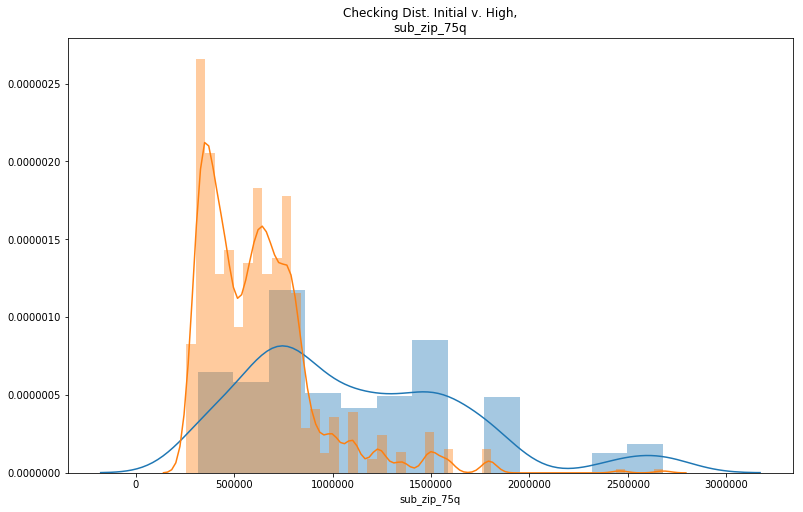

In [136]:
for col in ['price',
'zone_mean', 
'sqft_living',
'grade',
'bedrooms', 
'bathrooms',
'sqft_lot',
'floors',
'waterfront',
'view',
'condition',
'sqft_above',
'sqft_basement',
'yr_built',
'yr_renovated',
'sqft_living15',
'sqft_lot15',
'age',
'since_ren',
'renovated',
'month',
'basement',
'sub_zip_median',
'sub_zip_75q']:
    resd_check(results, data, col)

#### Test 21
Adding waterfront

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                 3.434e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        20:36:03   Log-Likelihood:            -2.9827e+05
No. Observations:               21597   AIC:                         5.965e+05
Df Residuals:                   21593   BIC:                         5.966e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
log_sqft_living        -7.42e+

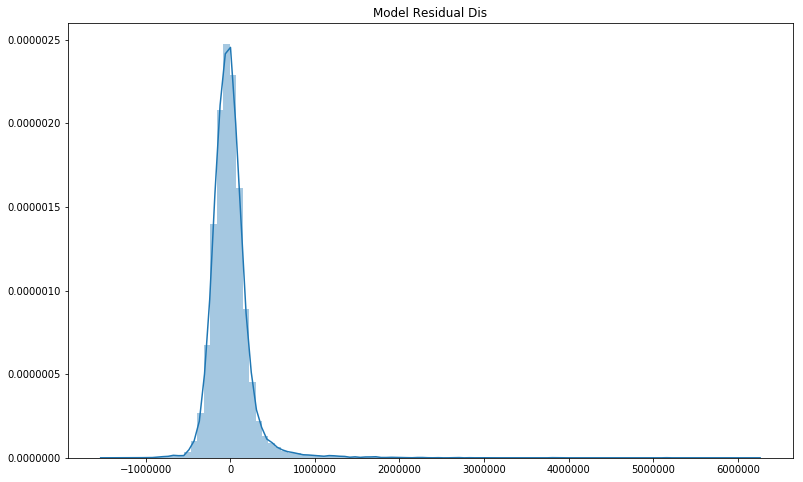

In [190]:
columns= ['log_sqft_living', 'min_max_grade', 'min_max_log_zone_mean', 'waterfront']

ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');
data['residual'] = results.resid
keep_data = data.loc[data.residual.abs() <= data.residual.std()*2] # removed anything above 3 std deviation in the residuals. 
removed_data = data.loc[data.residual.abs() > data.residual.std()*2]  

In [138]:
data.corr().loc[columns]

id     price  bedrooms  bathrooms  sqft_living  \
log_sqft_living       -0.001864  0.611839  0.621820   0.762135     0.954607   
min_max_grade          0.008188  0.667951  0.356563   0.665838     0.762779   
min_max_log_zone_mean  0.013413  0.532312  0.115965   0.214993     0.281800   
waterfront            -0.003599  0.264306 -0.002127   0.063629     0.104637   

                       sqft_lot    floors  waterfront      view  condition  \
log_sqft_living        0.150102  0.367564    0.078900  0.244804  -0.049620   
min_max_grade          0.114731  0.458794    0.082818  0.249082  -0.146896   
min_max_log_zone_mean -0.014861  0.131150    0.029324  0.131915   0.038159   
waterfront             0.021459  0.020797    1.000000  0.380543   0.016648   

                           ...        log_zone_95q  zone_max  zone_count  \
log_sqft_living            ...            0.216888  0.128795   -0.108029   
min_max_grade              ...            0.283163  0.189847   -0.105987   
min_max_log_zone_mean      ...            0.900440  0.691135   -0.134829   
waterfront                 ...            0.044270  0.047573   -0.025526   

                       log_grade  scaled_log_grade  log_sqft_living  basement  \
log_sqft_living         0.744356          0.744356         1.000000  0.233548   
min_max_grade           0.992855          0.992855         0.743038  0.050701   
min_max_log_zone_mean   0.335044          0.335044         0.261217  0.121546   
waterfront              0.073448          0.073448         0.078900  0.039220   

                        log_lat  min_max_log_zone_mean  min_max_grade  
log_sqft_living        0.038881               0.261217       0.743038  
min_max_grade          0.113687               0.343140       1.000000  
min_max_log_zone_mean  0.410482               1.000000       0.343140  
waterfront            -0.012111               0.029324       0.082818  

[4 rows x 49 columns]

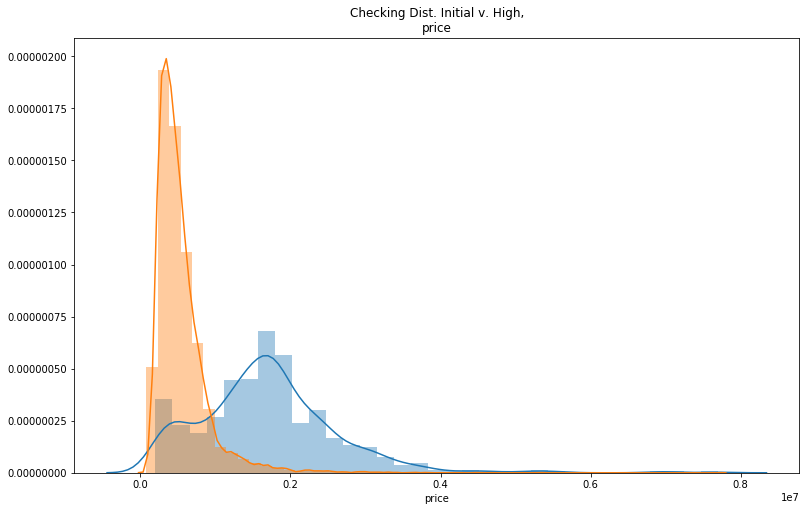

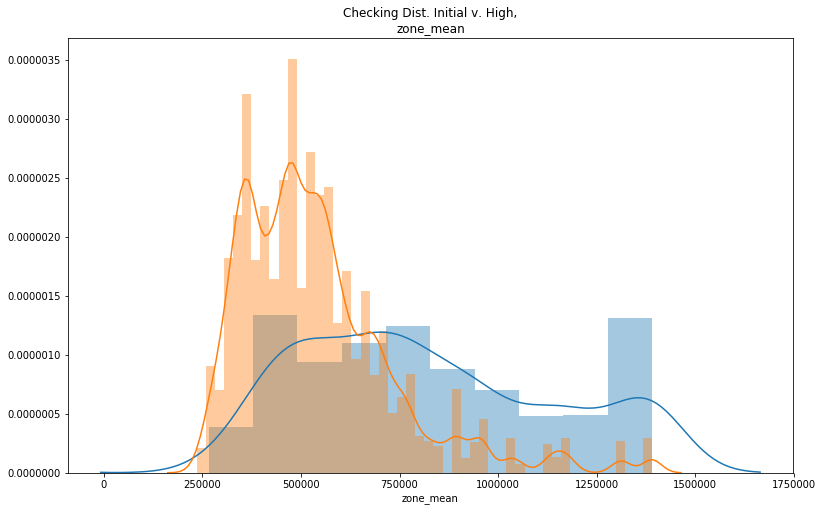

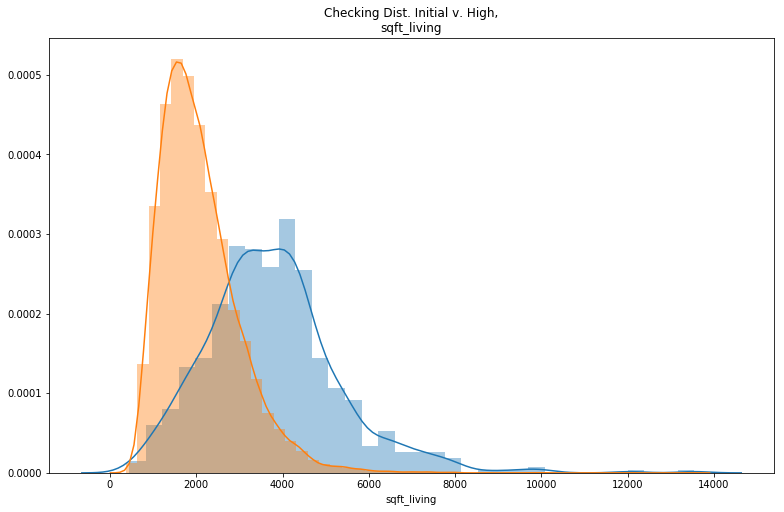

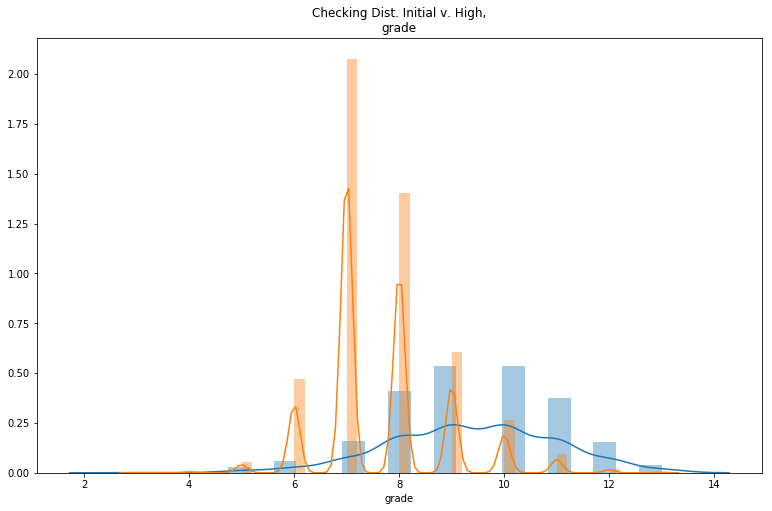

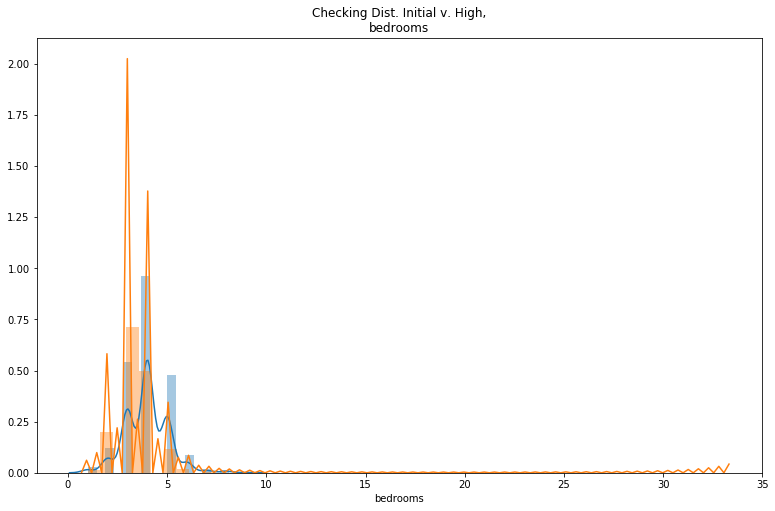

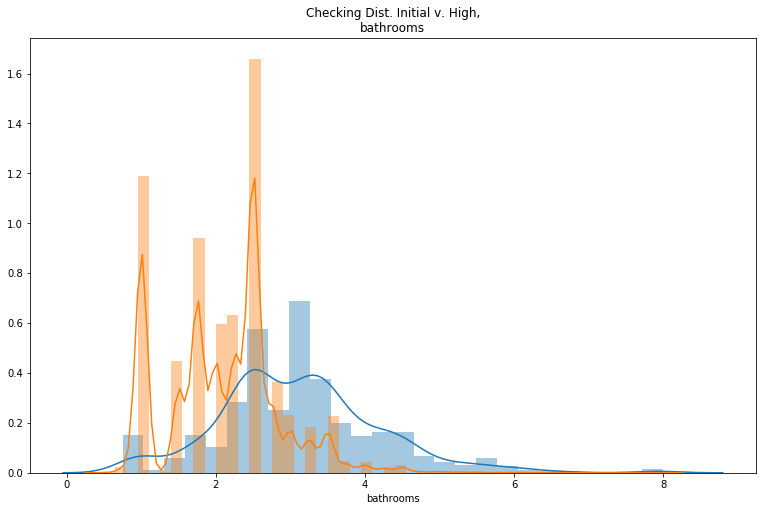

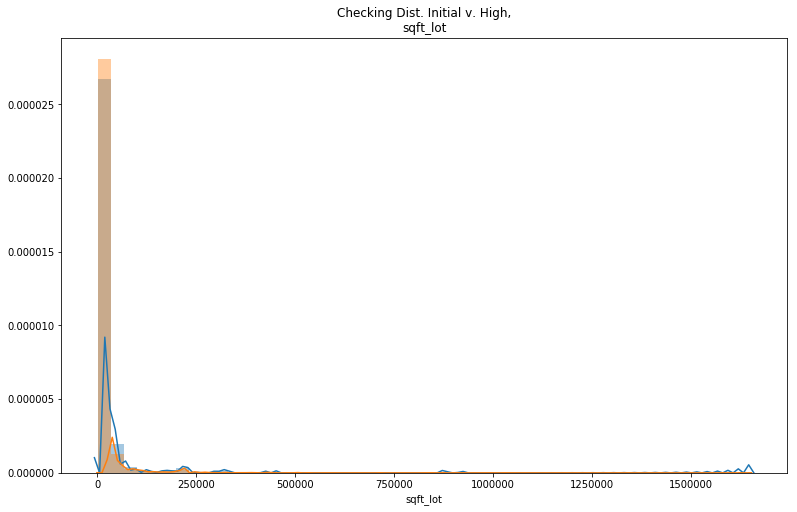

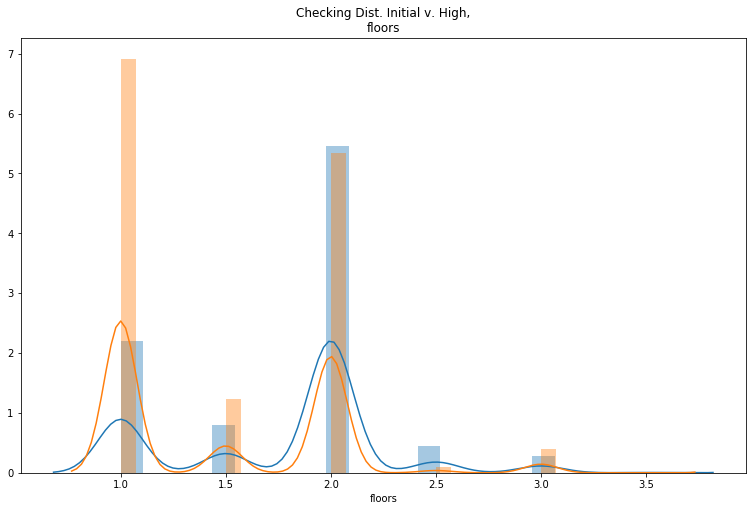

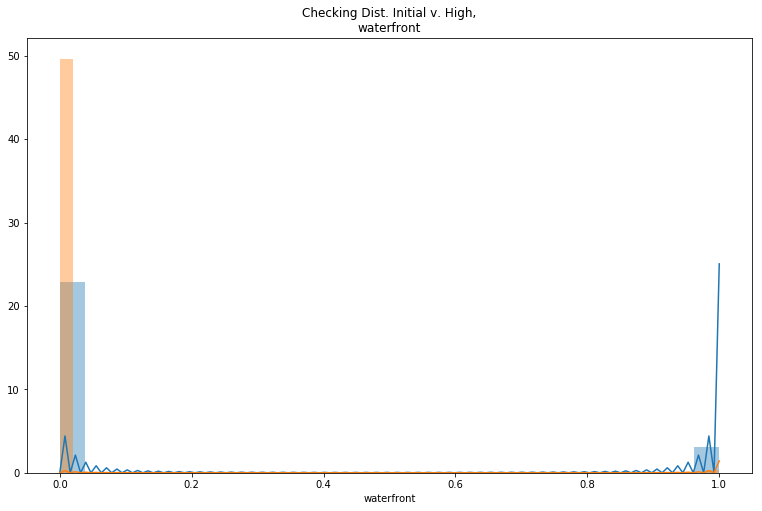

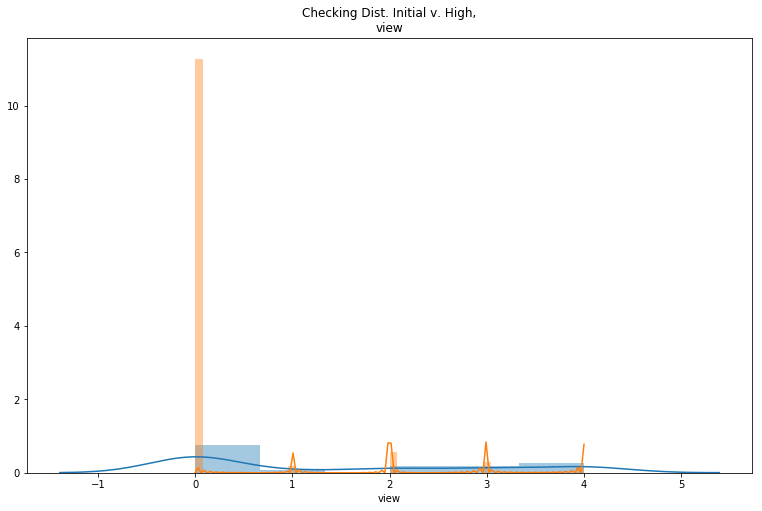

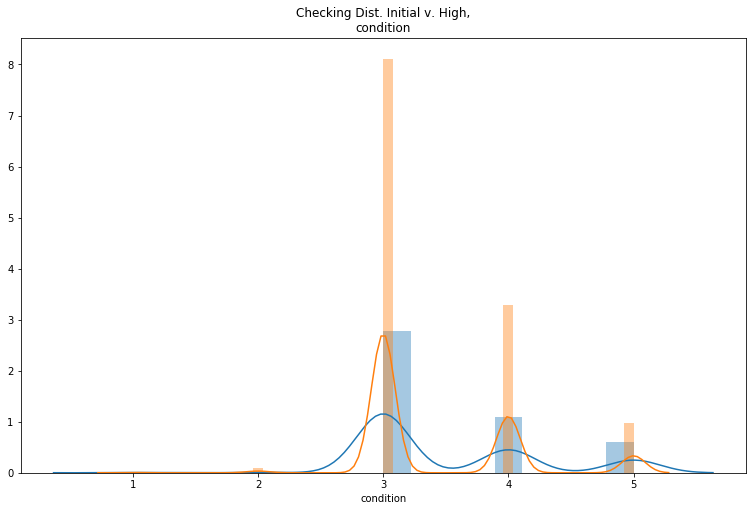

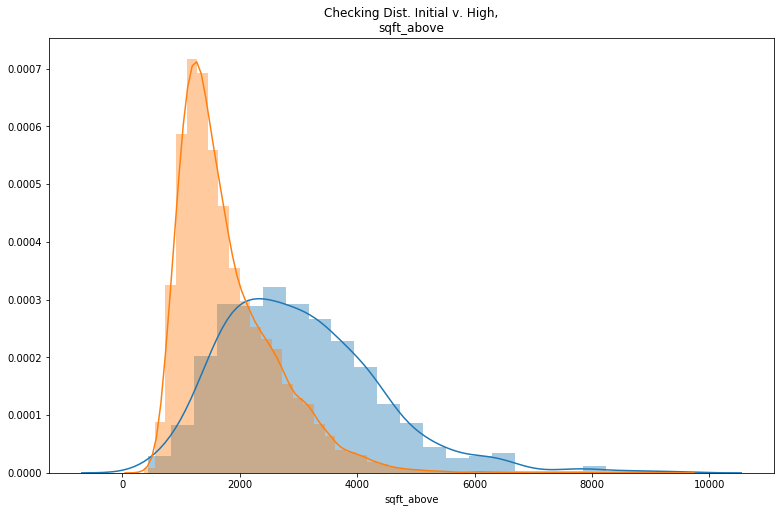

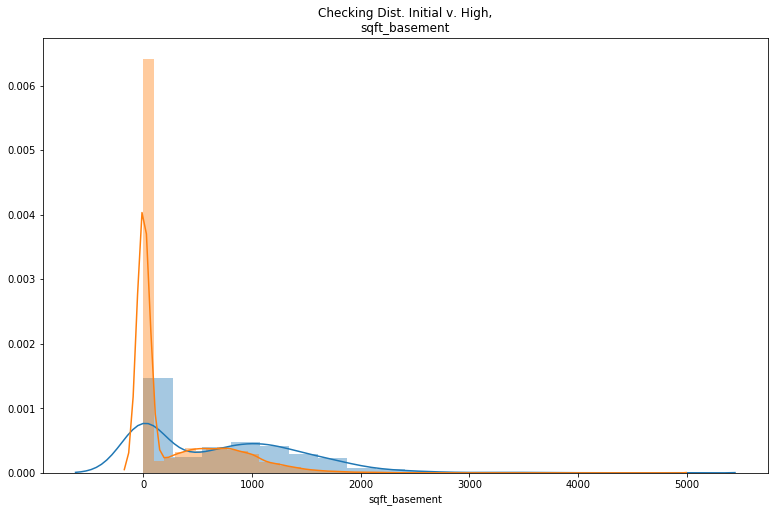

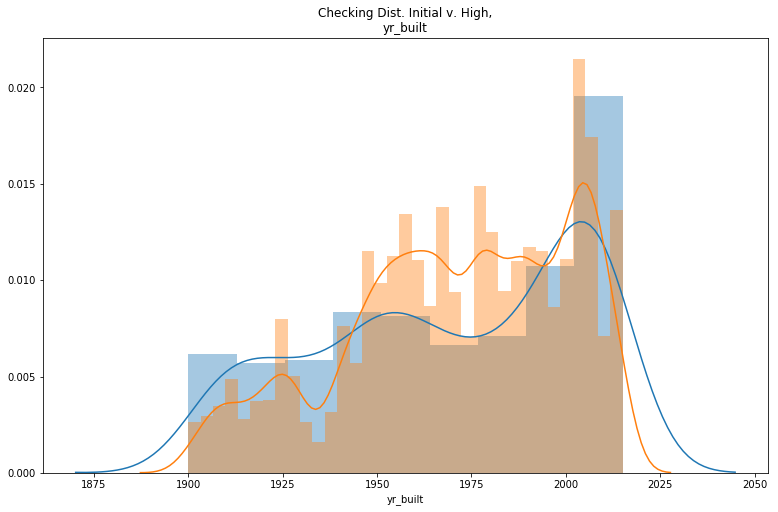

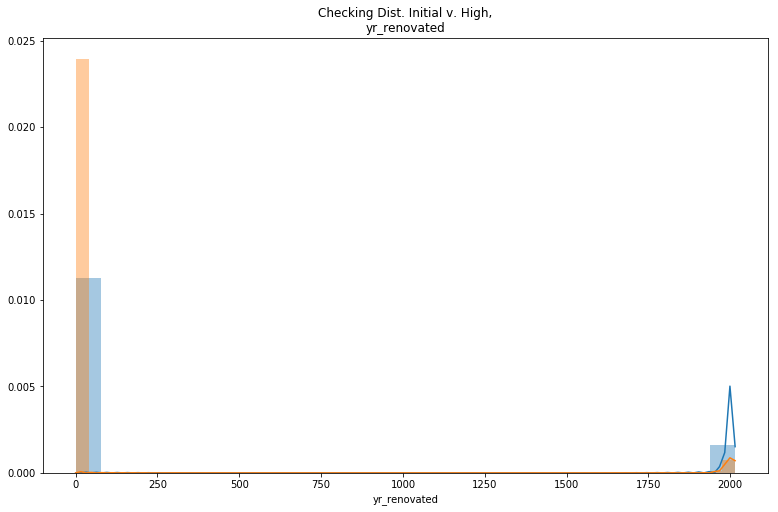

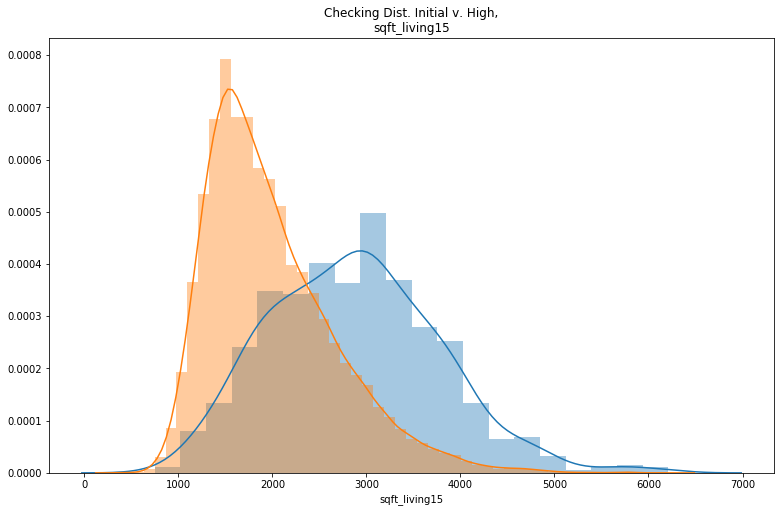

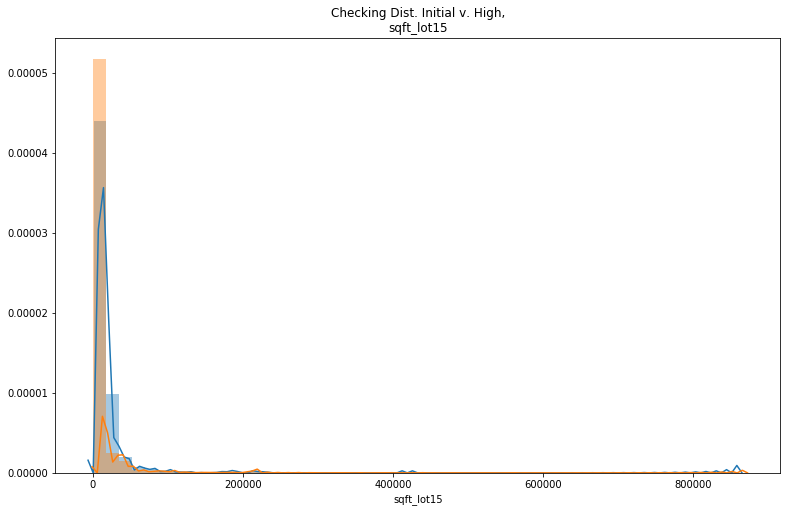

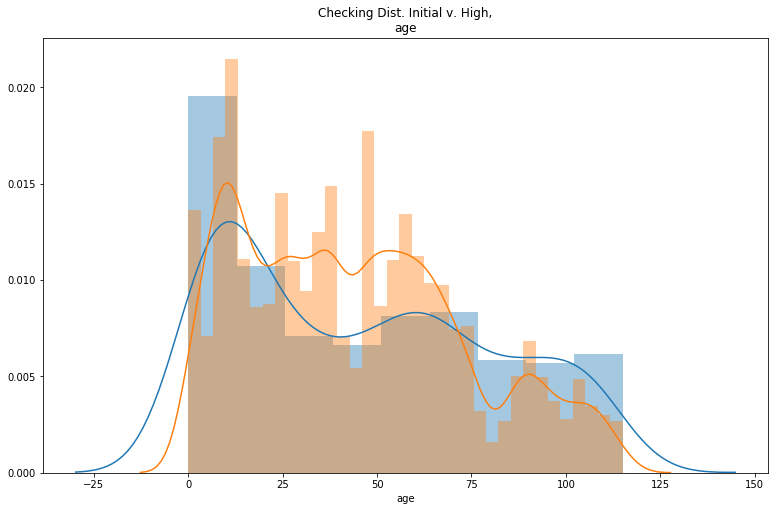

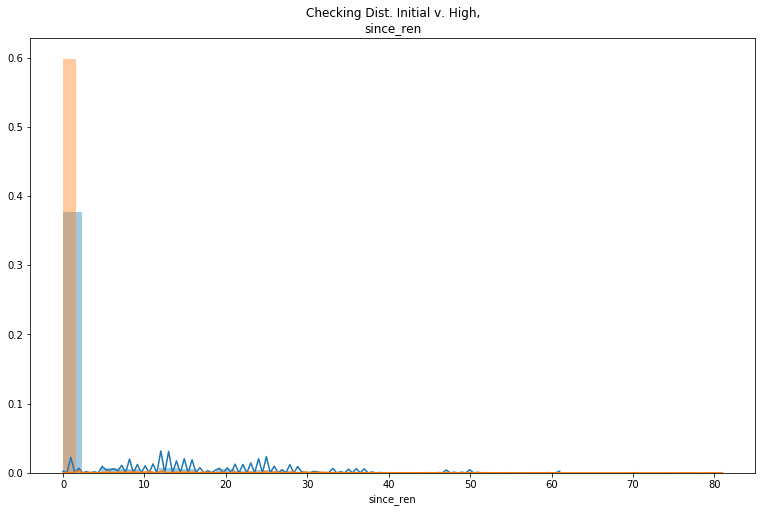

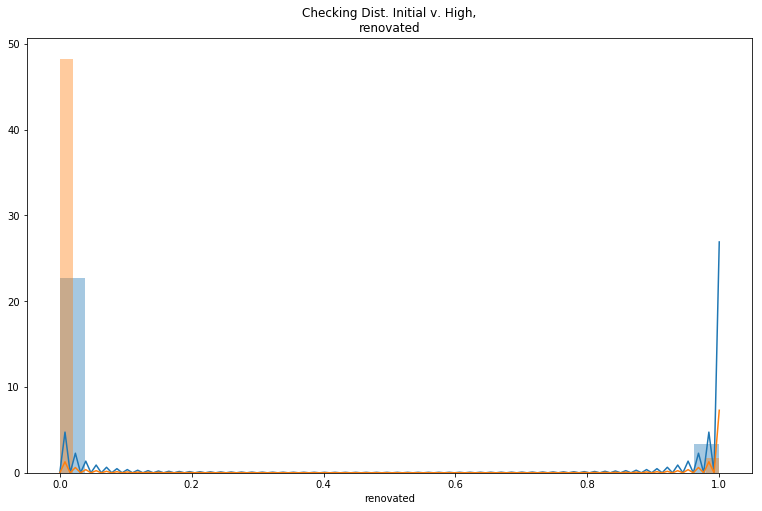

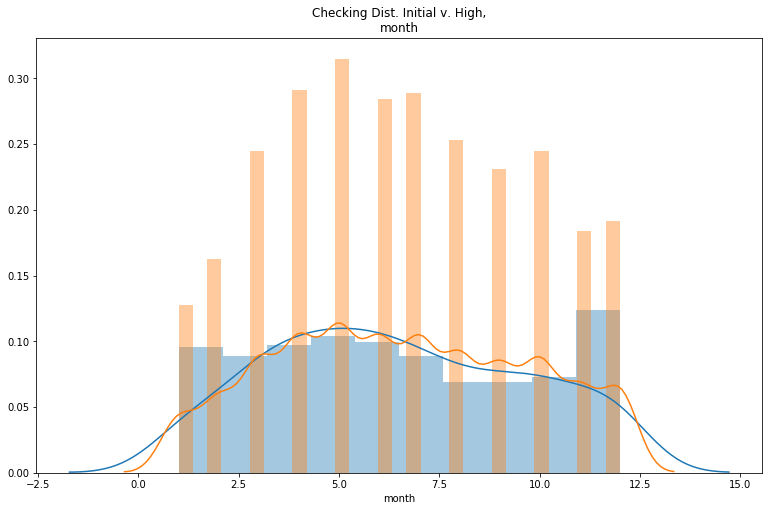

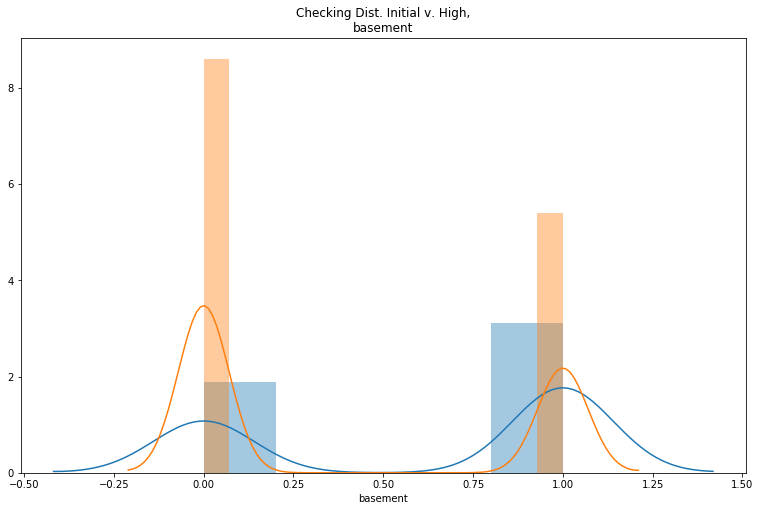

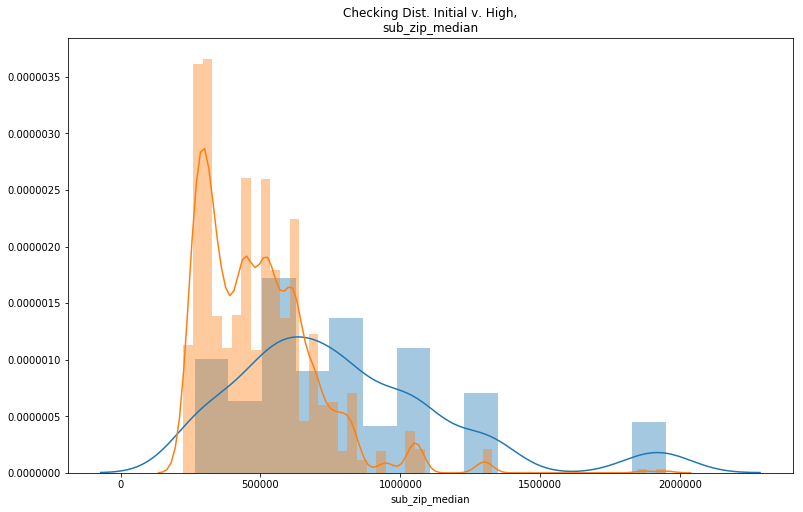

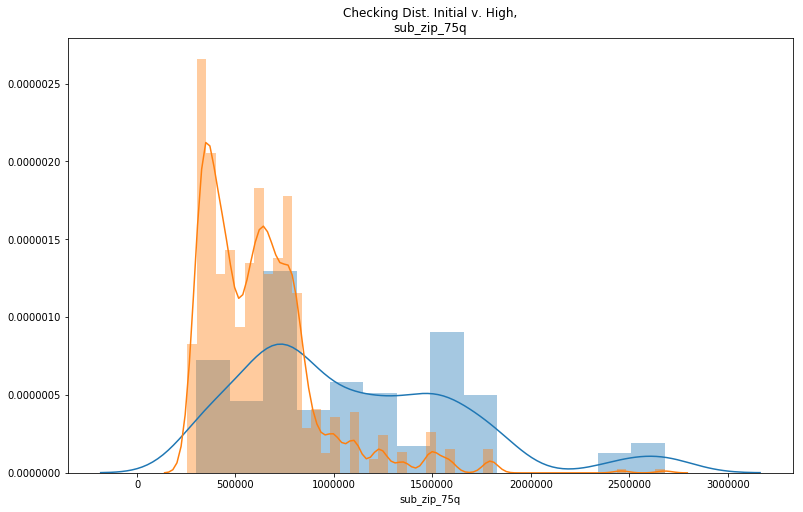

In [157]:
for col in ['price',
'zone_mean', 
'sqft_living',
'grade',
'bedrooms', 
'bathrooms',
'sqft_lot',
'floors',
'waterfront',
'view',
'condition',
'sqft_above',
'sqft_basement',
'yr_built',
'yr_renovated',
'sqft_living15',
'sqft_lot15',
'age',
'since_ren',
'renovated',
'month',
'basement',
'sub_zip_median',
'sub_zip_75q']:
    resd_check(results, data, col)

#### Separating  residual

In [158]:
data['residual'] = results.resid
keep_data = data.loc[data.residual.abs() <= data.residual.std()*2] # removed anything above 3 std deviation in the residuals. 
removed_data = data.loc[data.residual.abs() > data.residual.std()*2]  

In [166]:
a= data.grade.sort_values()


for i in a.unique():
    print(i)
    print(len(keep_data.grade.loc[data.grade == i])/len(data.grade.loc[data.grade == i]))

3
0.0
4
1.0
5
0.9669421487603306
6
0.9916584887144259
7
0.9946512146200134
8
0.9798845836768343
9
0.9391969407265774
10
0.8597883597883598
11
0.7192982456140351
12
0.48314606741573035
13
0.07692307692307693


#### New Variable high_grade
Binary variable for grades with that have removed residual percentages in the last model (3 and grades over 9) other grades recieved a one.

In [237]:
data['high_grade'] = data.grade
data.high_grade.loc[(data.high_grade <12) & (data.high_grade > 3)] = 1
data.high_grade.loc[(data.high_grade >= 12) | (data.high_grade == 3)] = 0

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                 3.394e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        21:06:58   Log-Likelihood:            -2.9627e+05
No. Observations:               21597   AIC:                         5.925e+05
Df Residuals:                   21592   BIC:                         5.926e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
log_sqft_living        1.279e+

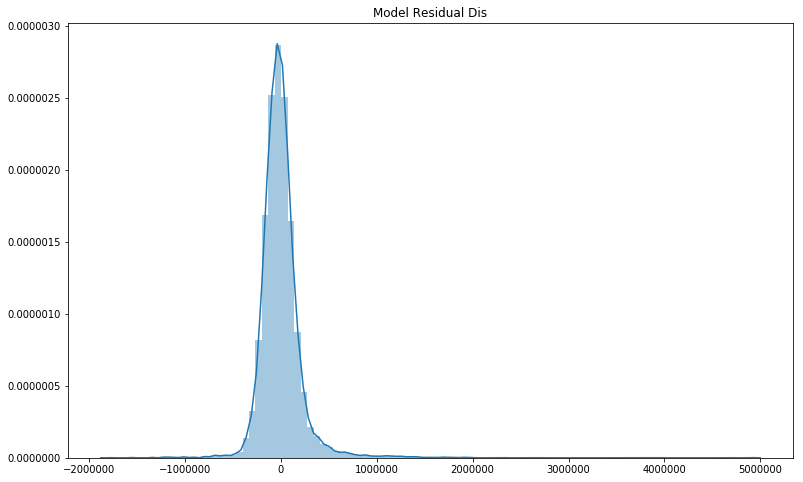

In [241]:
columns= ['log_sqft_living', 'min_max_grade', 'min_max_log_zone_mean', 'waterfront', 'high_grade']

ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');
data['residual'] = results.resid
keep_data = data.loc[data.residual.abs() <= data.residual.std()*2] # removed anything above 3 std deviation in the residuals. 
removed_data = data.loc[data.residual.abs() > data.residual.std()*2]  

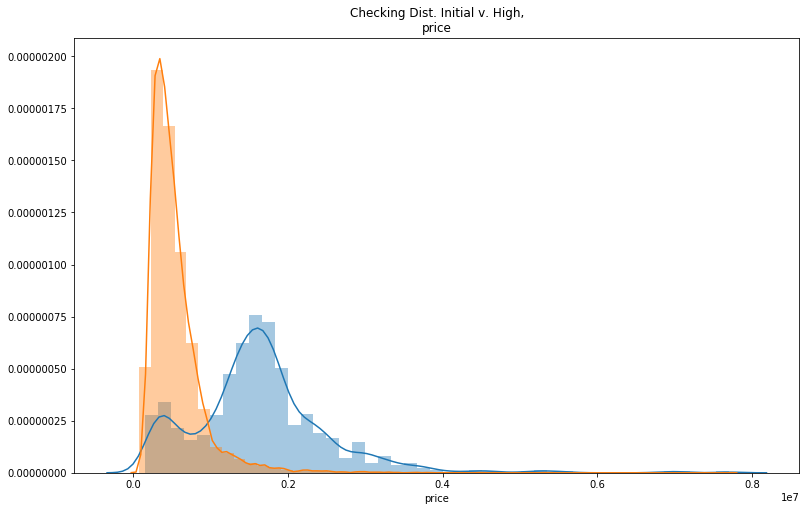

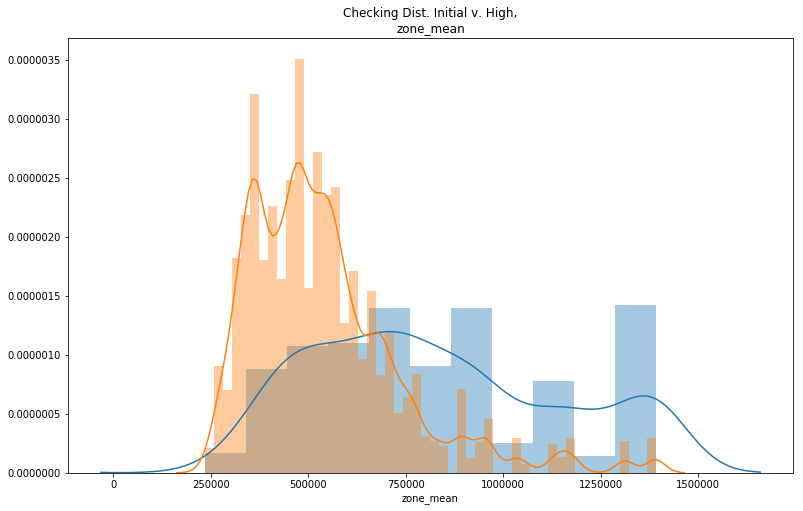

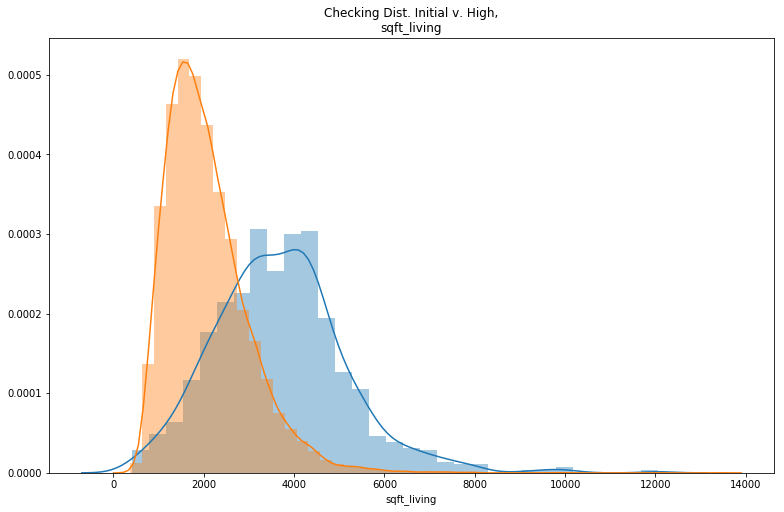

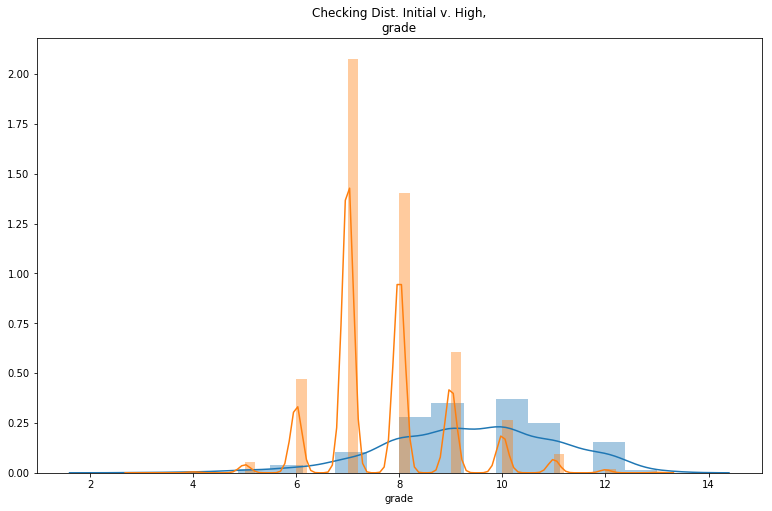

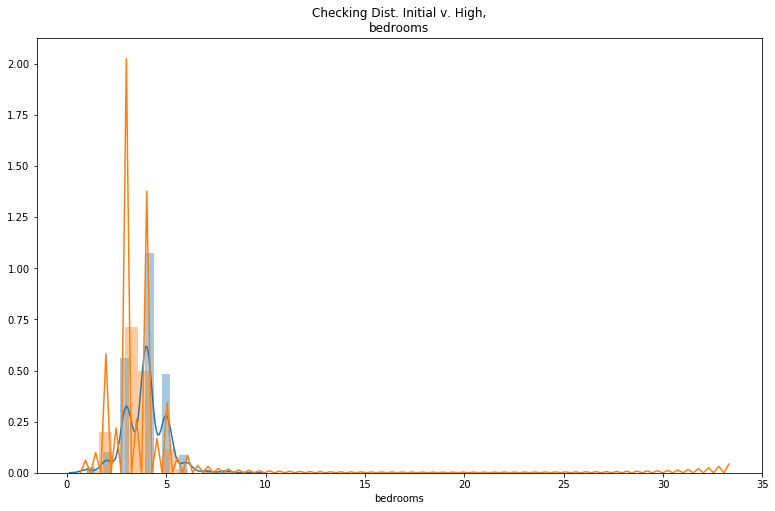

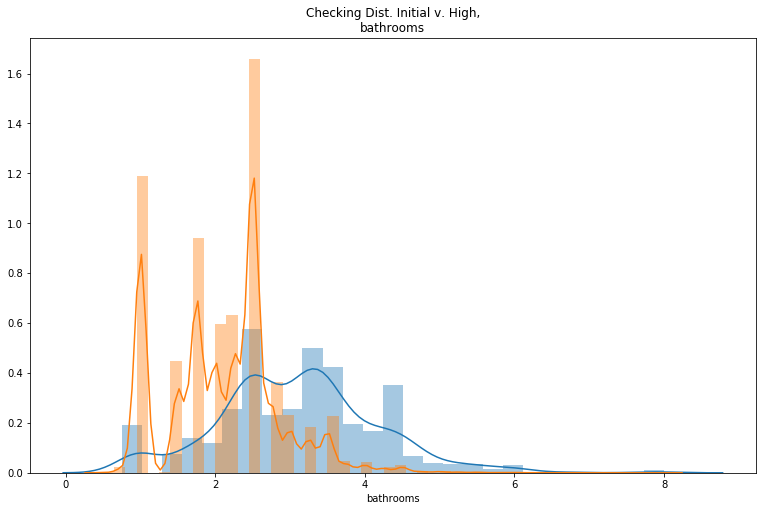

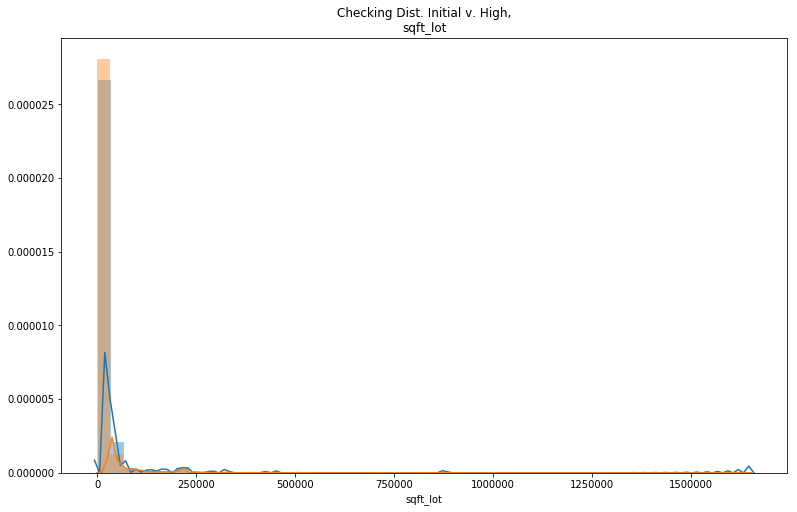

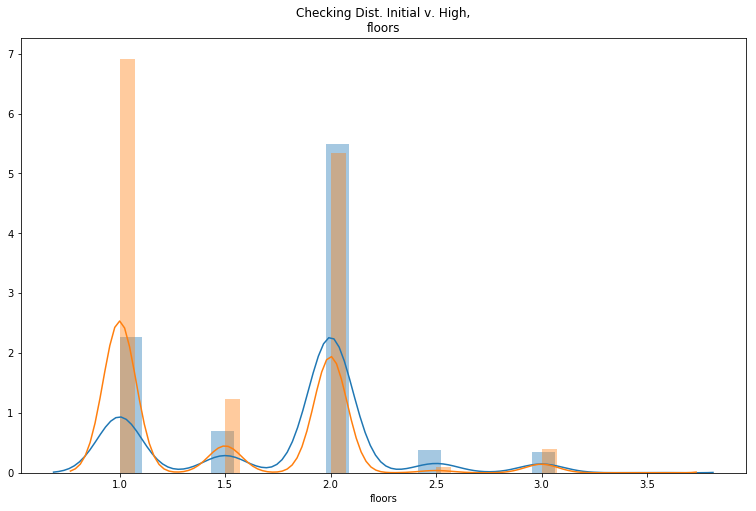

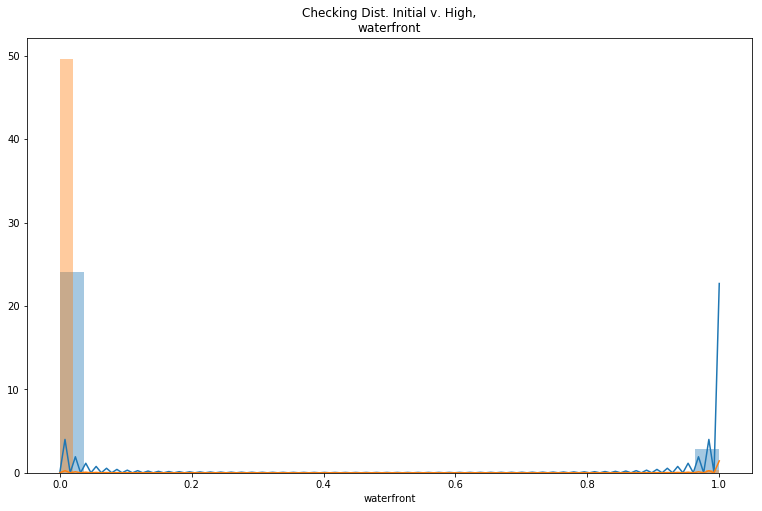

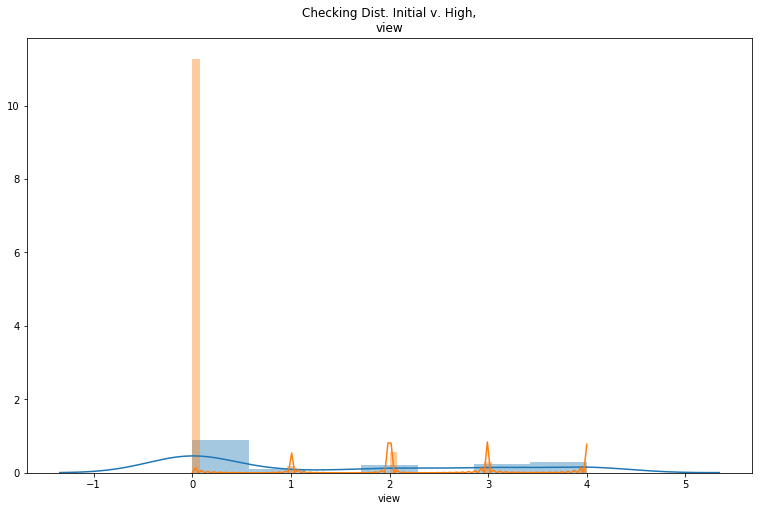

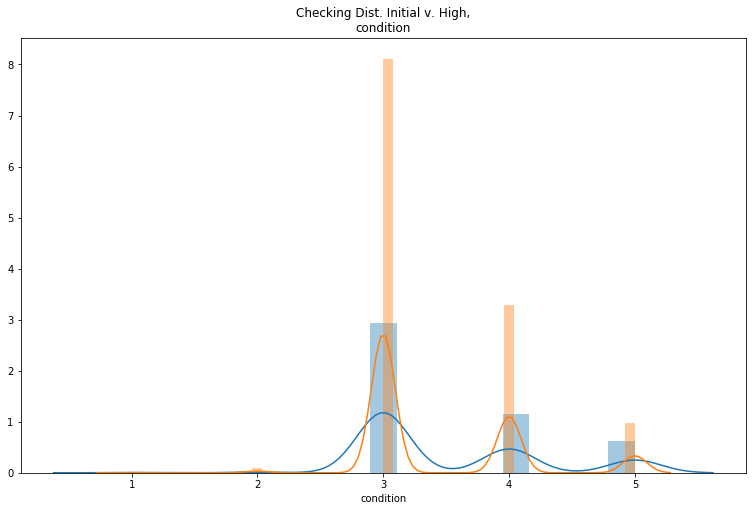

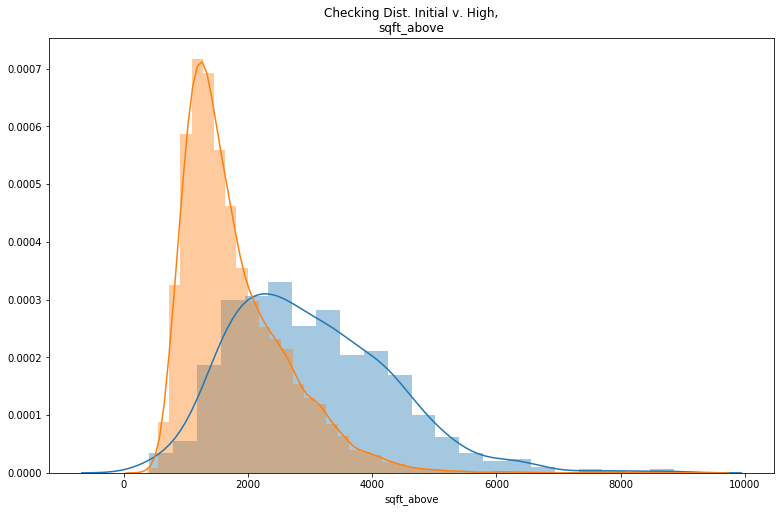

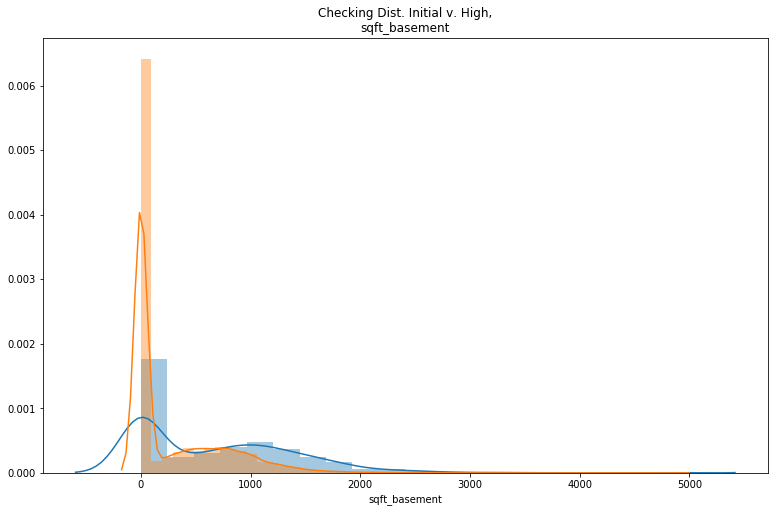

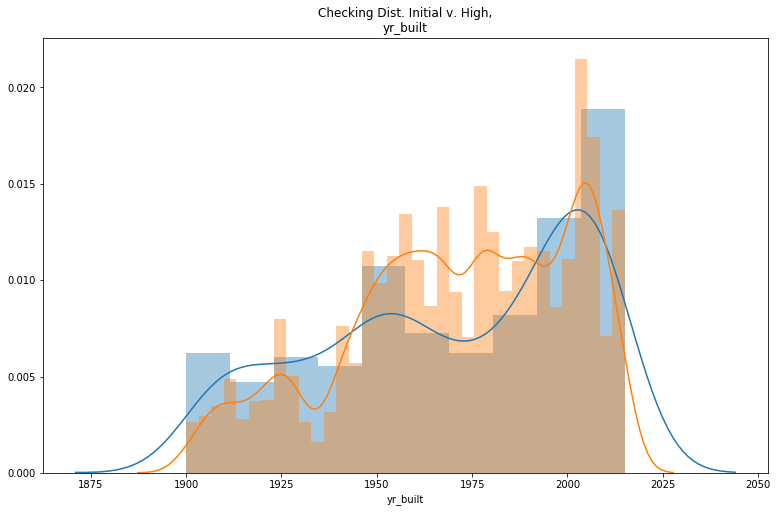

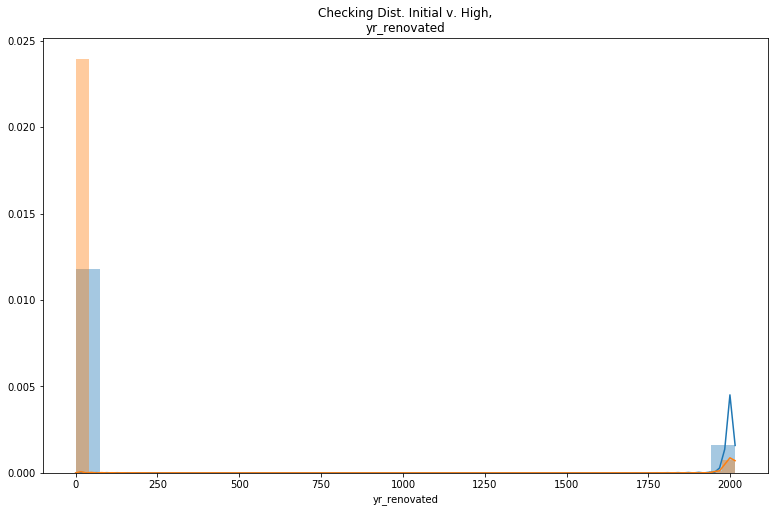

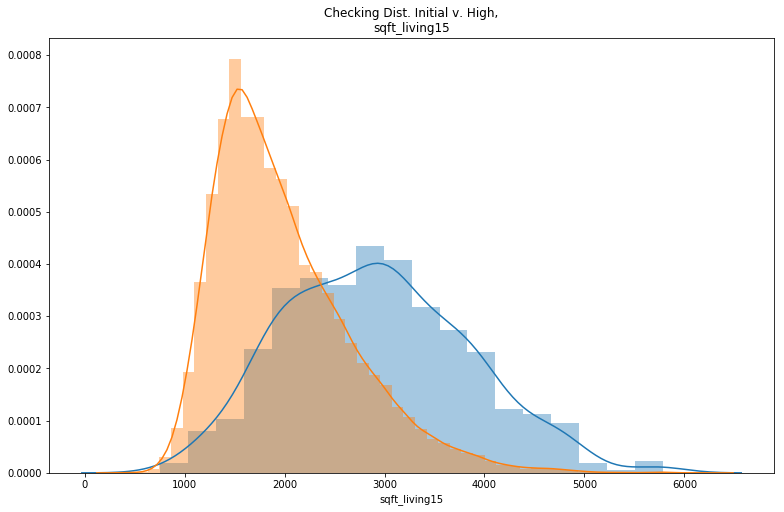

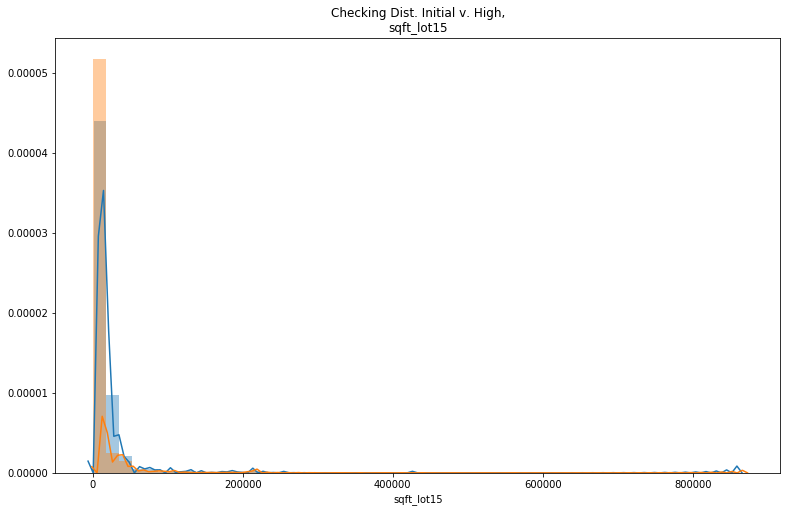

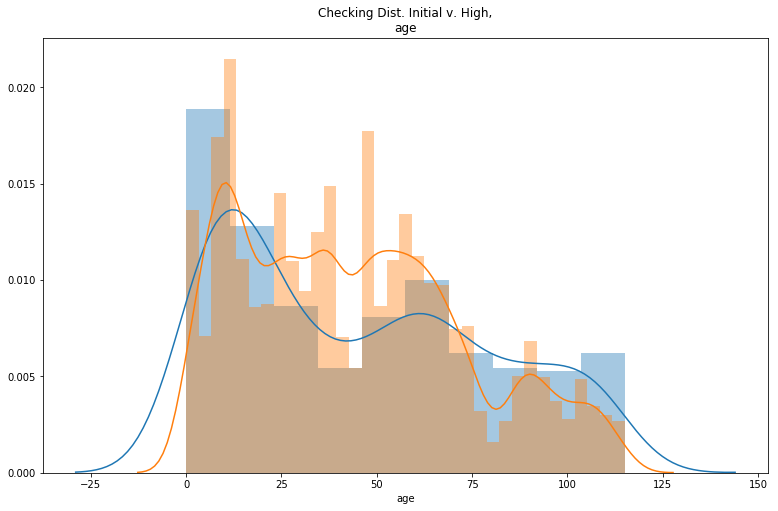

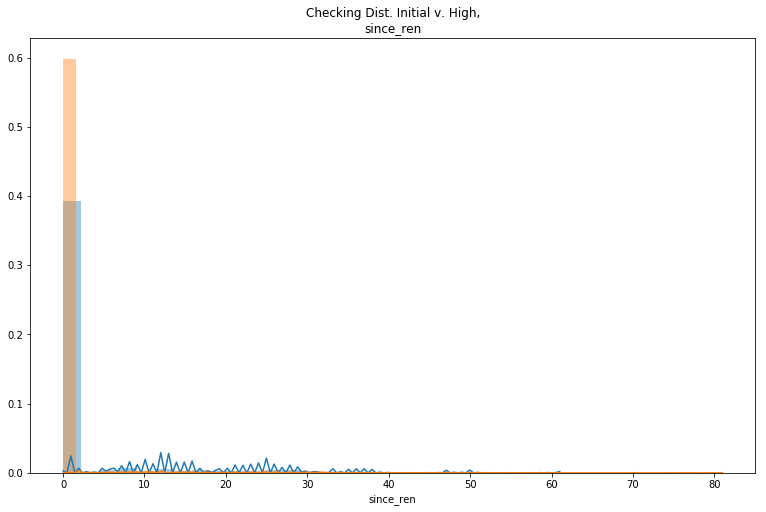

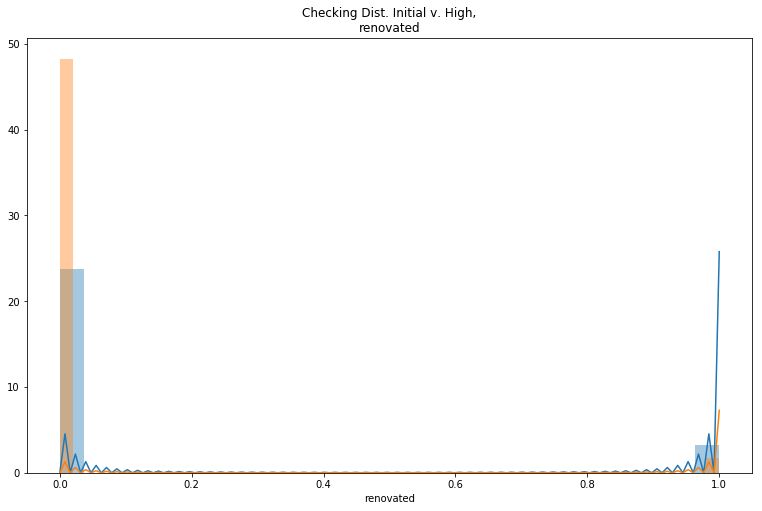

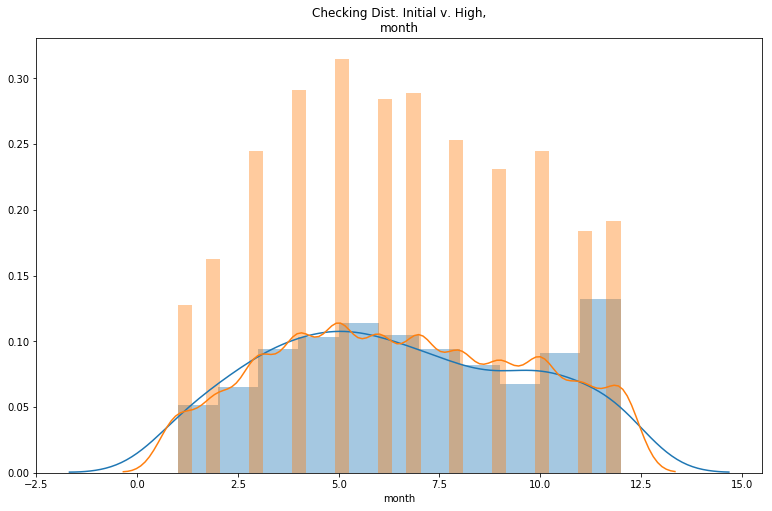

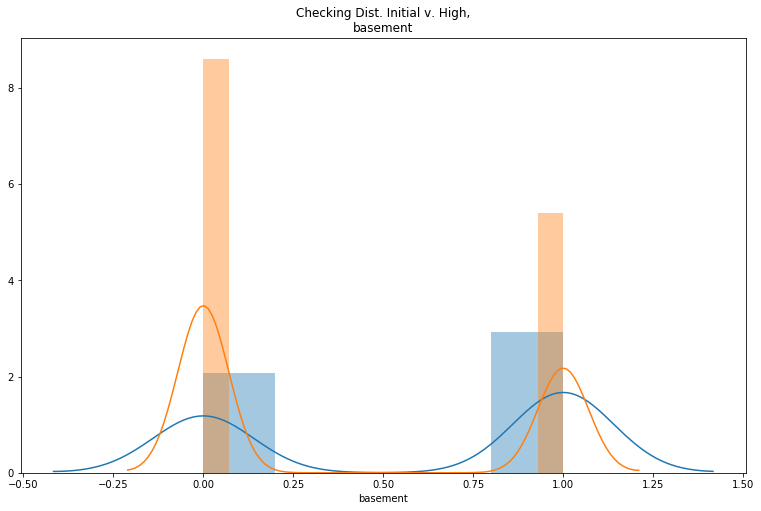

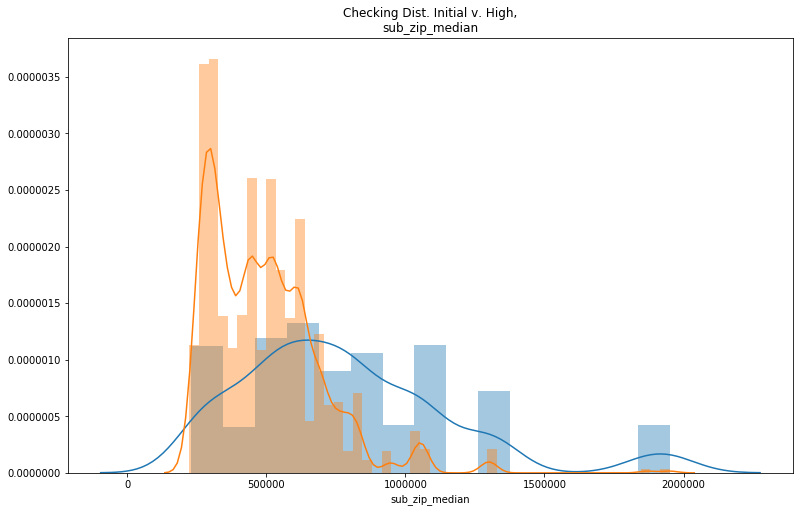

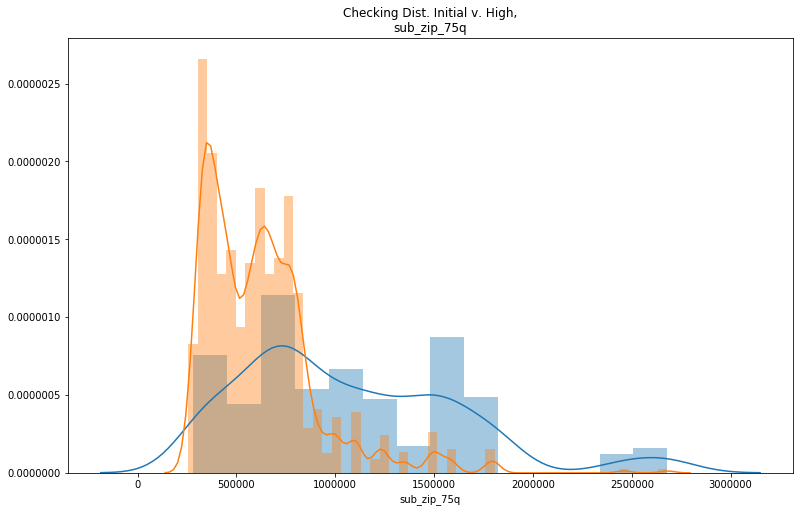

In [222]:
for col in ['price',
'zone_mean', 
'sqft_living',
'grade',
'bedrooms', 
'bathrooms',
'sqft_lot',
'floors',
'waterfront',
'view',
'condition',
'sqft_above',
'sqft_basement',
'yr_built',
'yr_renovated',
'sqft_living15',
'sqft_lot15',
'age',
'since_ren',
'renovated',
'month',
'basement',
'sub_zip_median',
'sub_zip_75q']:
    resd_check(results, data, col)

In [239]:
a= data.bin_floors.sort_values()
for i in a.unique():
    print(i)
    print(len(keep_data.bin_floors.loc[data.bin_floors == i])/len(data.bin_floors.loc[data.bin_floors == i]))

1
0.9807677024556942
2
0.9427108146736541
3
0.9514563106796117


In [242]:
a= data.grade.sort_values()
for i in a.unique():
    print(i)
    print(len(keep_data.grade.loc[data.grade == i])/len(data.grade.loc[data.grade == i]))

3
0.0
4
0.8888888888888888
5
0.9669421487603306
6
0.9906771344455348
7
0.9950969467350123
8
0.9782357790601813
9
0.9334608030592734
10
0.845679012345679
11
0.706766917293233
12
0.1797752808988764
13
0.46153846153846156


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                 2.855e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        21:08:04   Log-Likelihood:            -2.9618e+05
No. Observations:               21597   AIC:                         5.924e+05
Df Residuals:                   21591   BIC:                         5.924e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
log_sqft_living        1.278e+

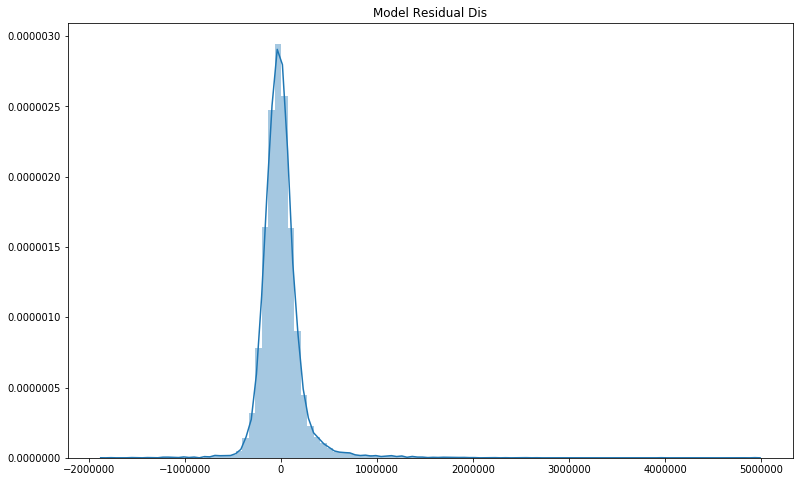

In [244]:
columns= ['log_sqft_living', 'min_max_grade', 'min_max_log_zone_mean', 'waterfront', 'high_grade', 'bin_floors']

ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');
data['residual'] = results.resid
keep_data = data.loc[data.residual.abs() <= data.residual.std()*2] # removed anything above 3 std deviation in the residuals. 
removed_data = data.loc[data.residual.abs() > data.residual.std()*2]  

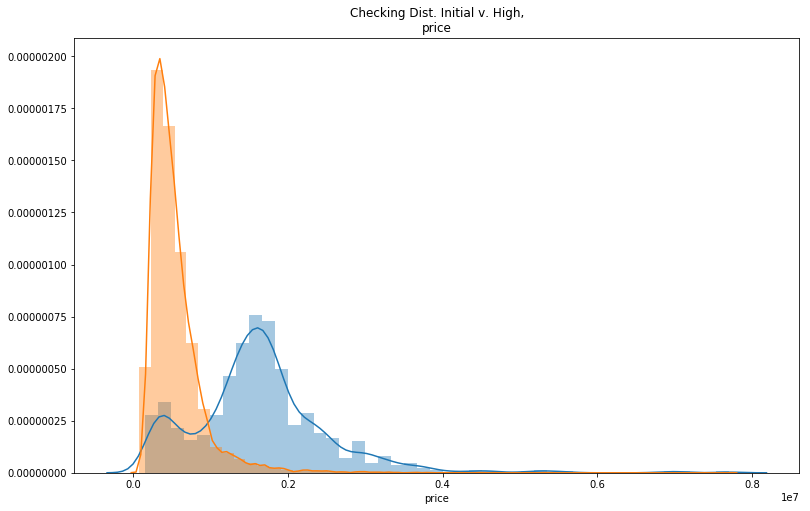

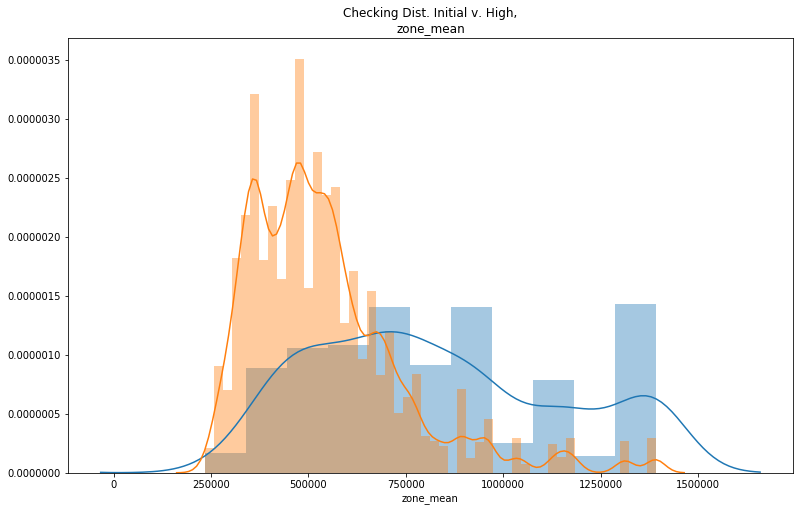

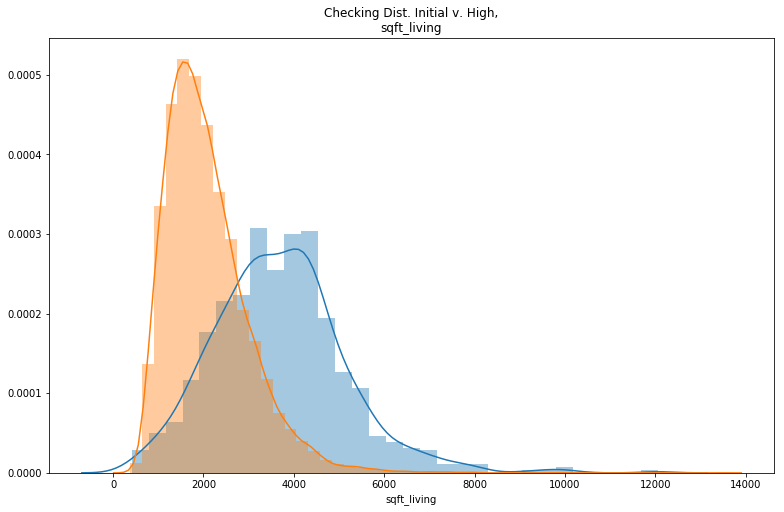

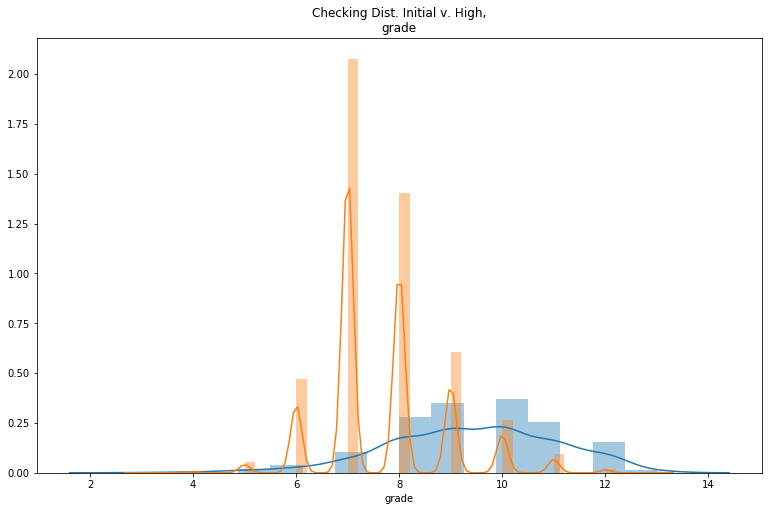

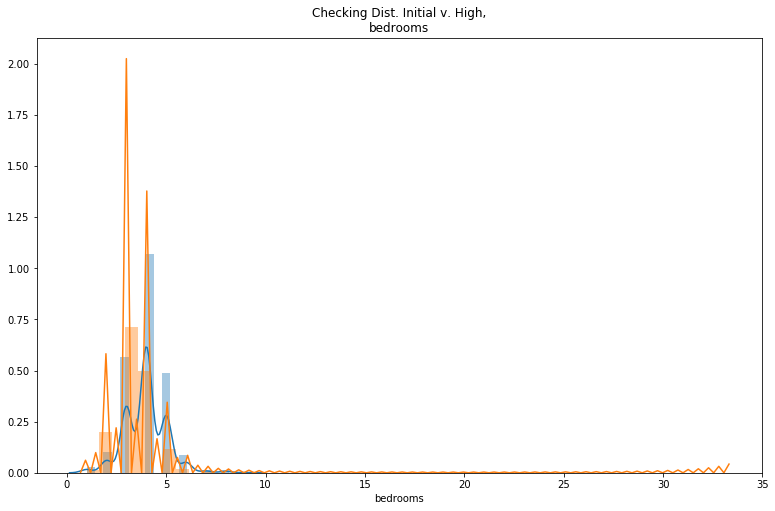

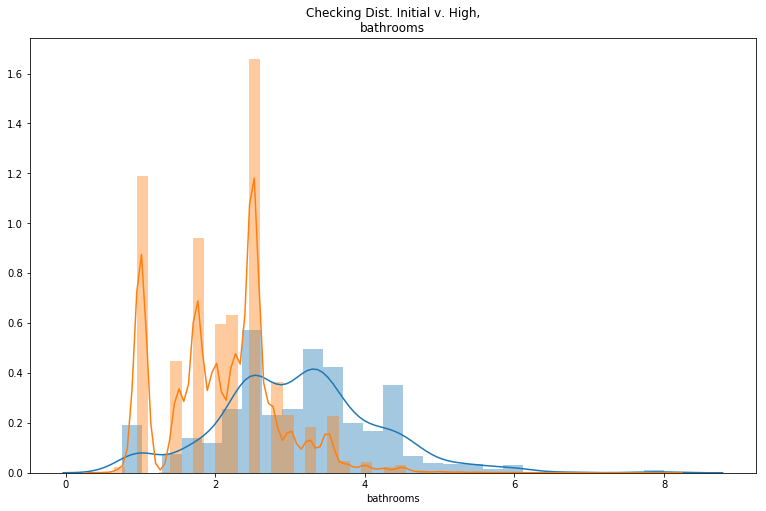

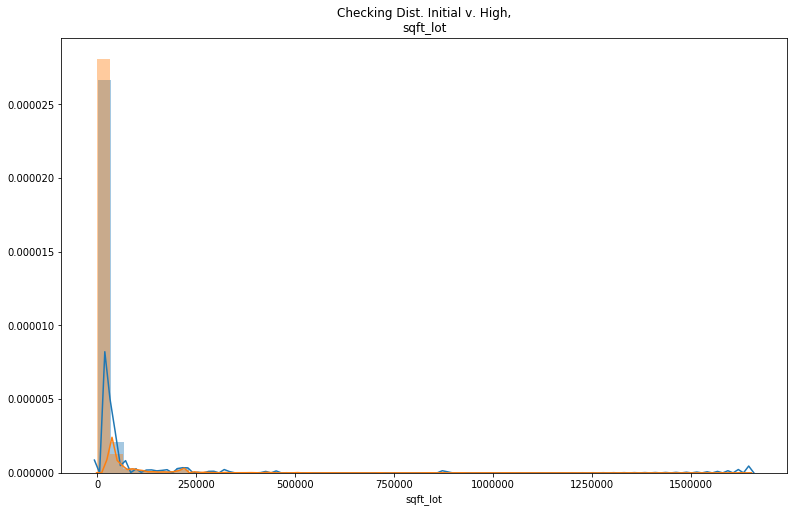

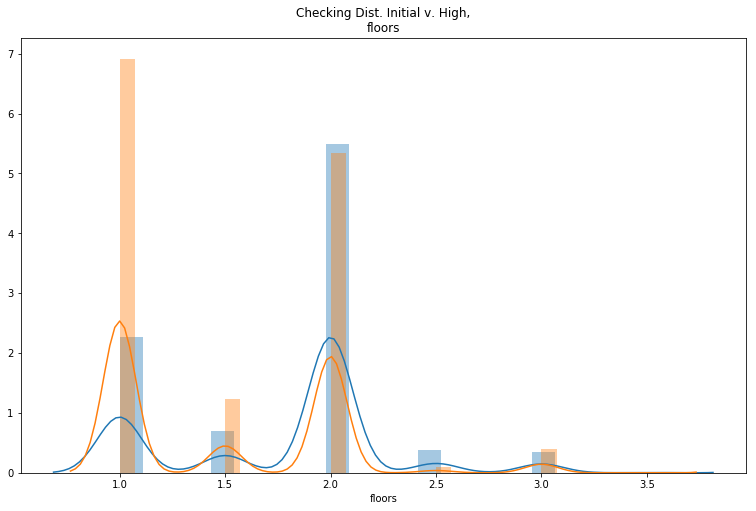

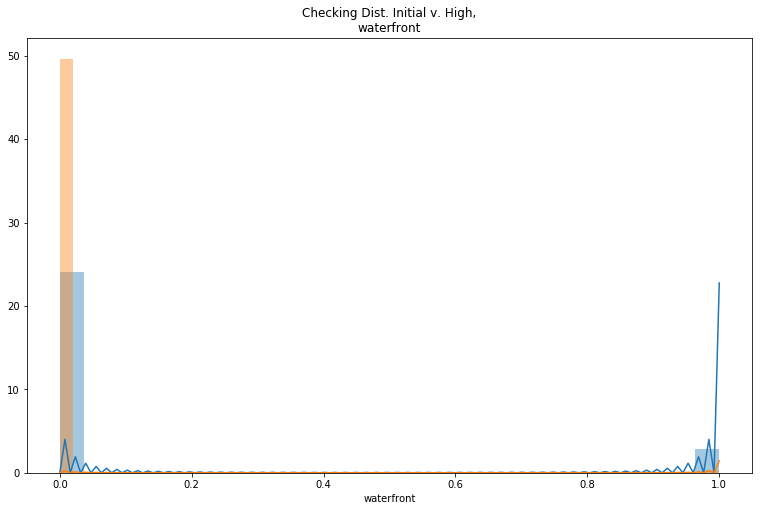

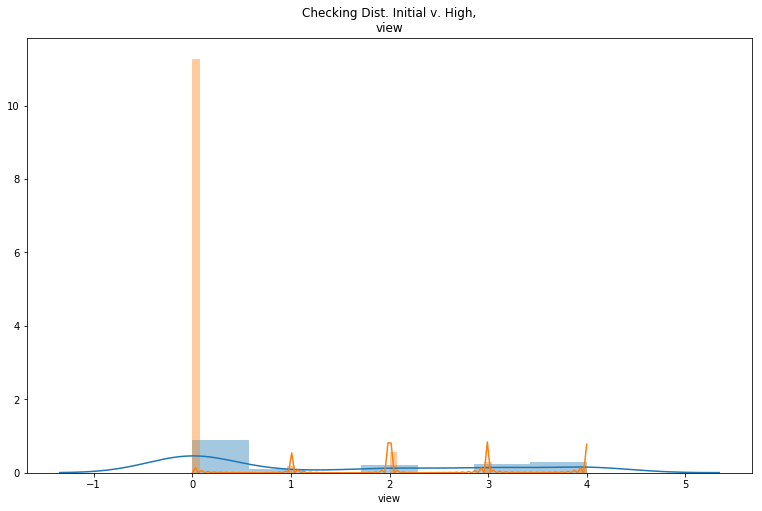

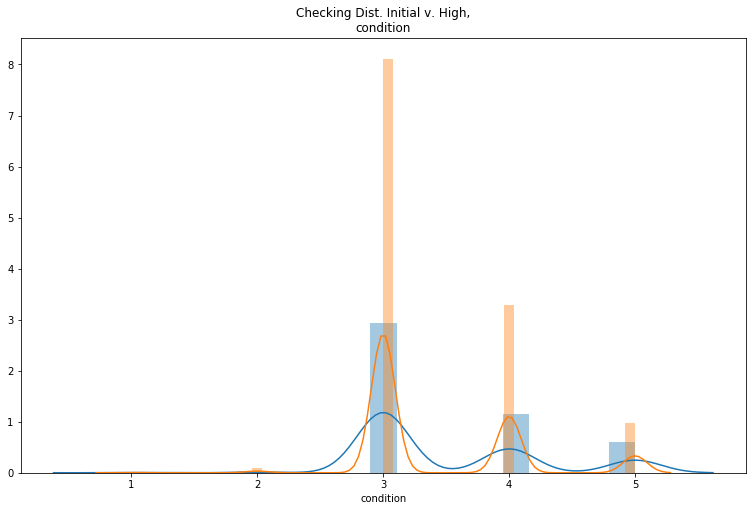

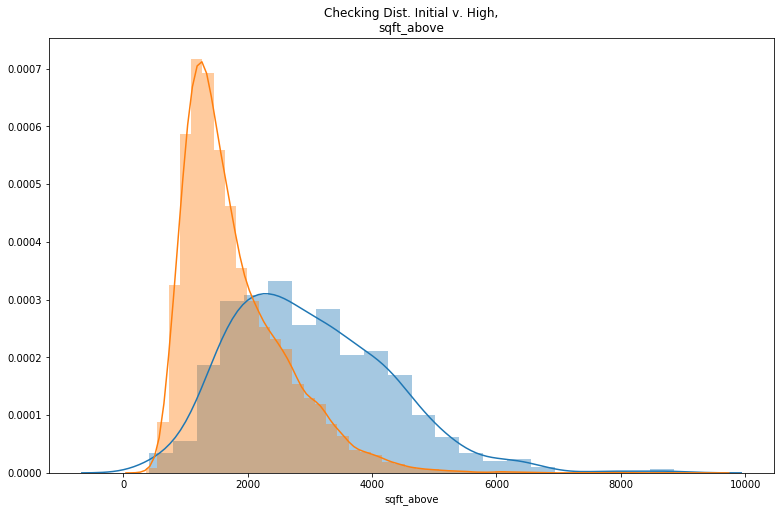

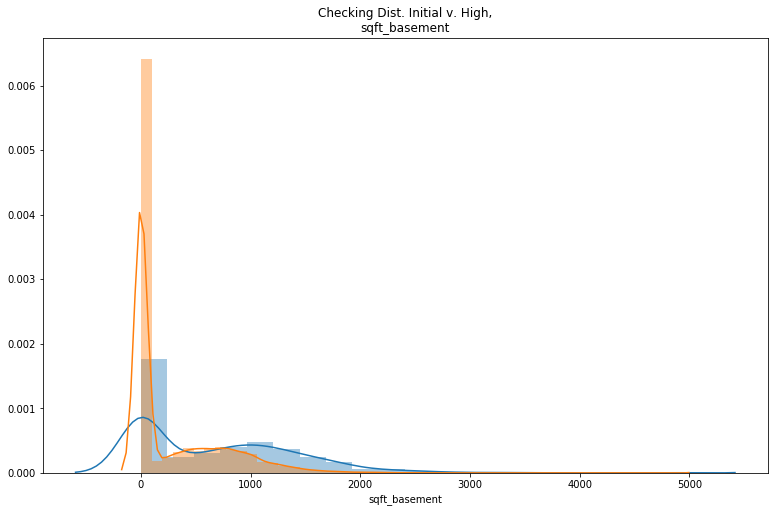

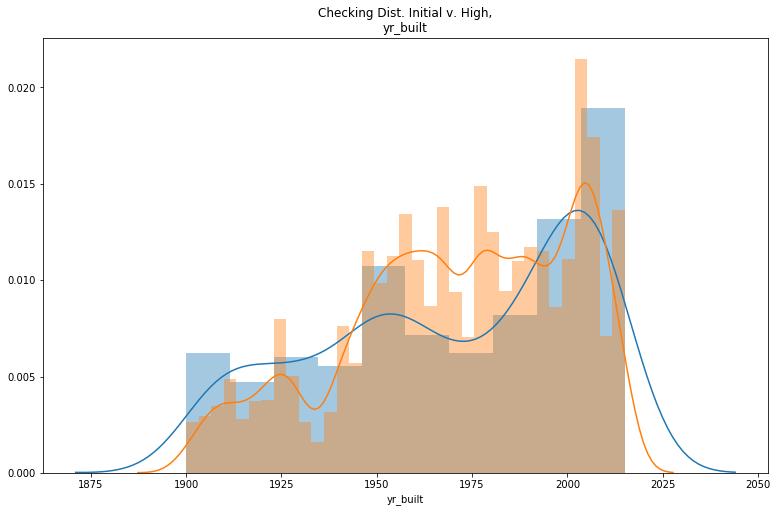

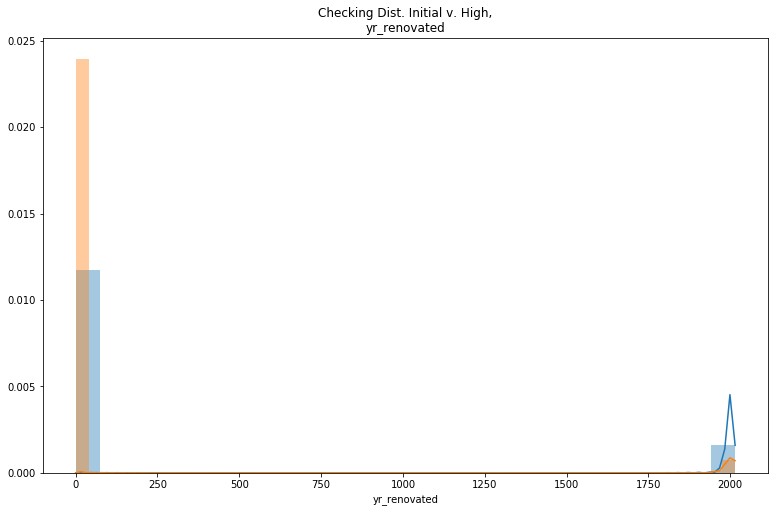

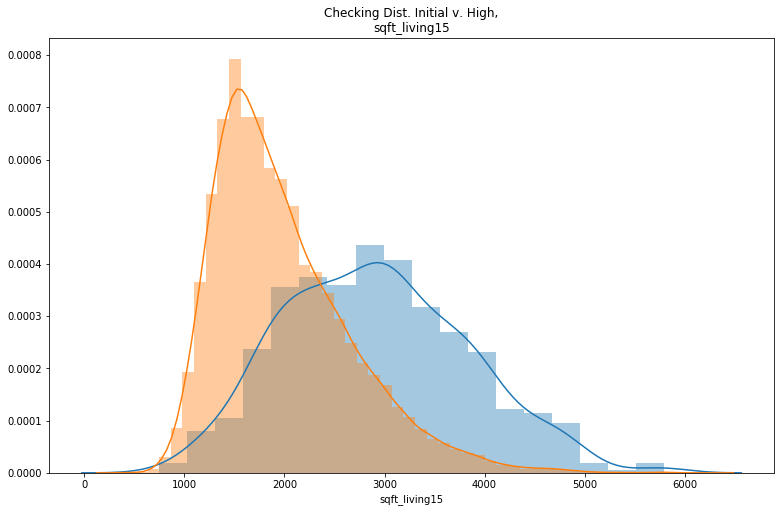

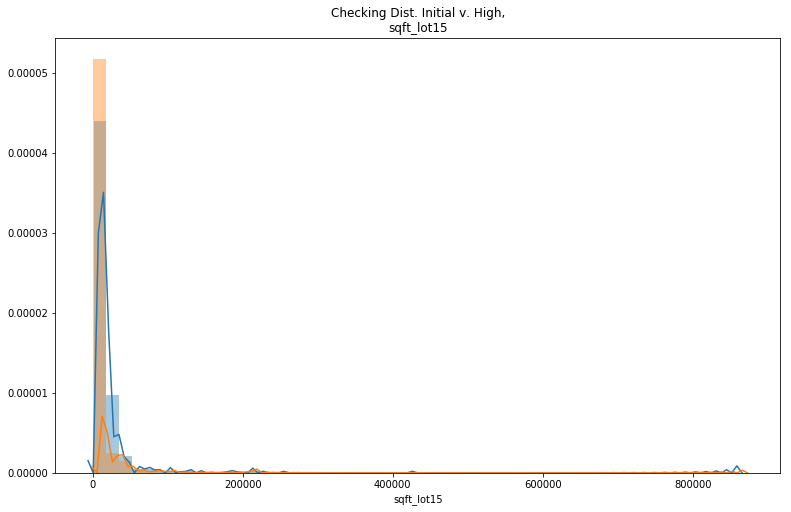

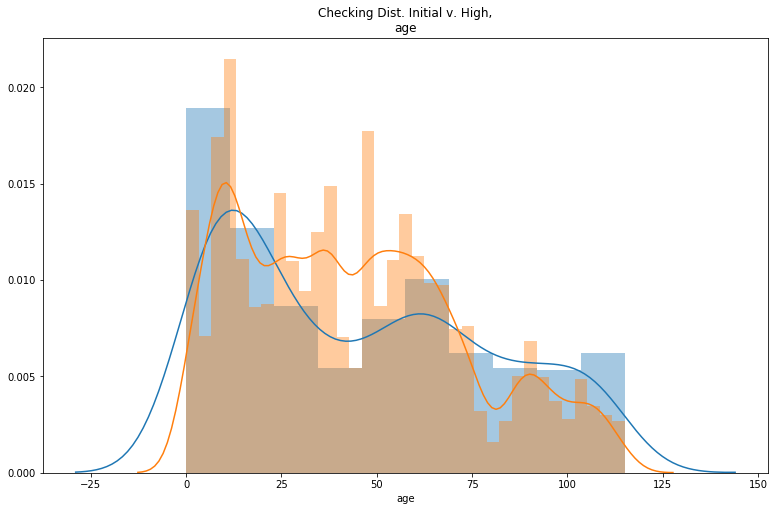

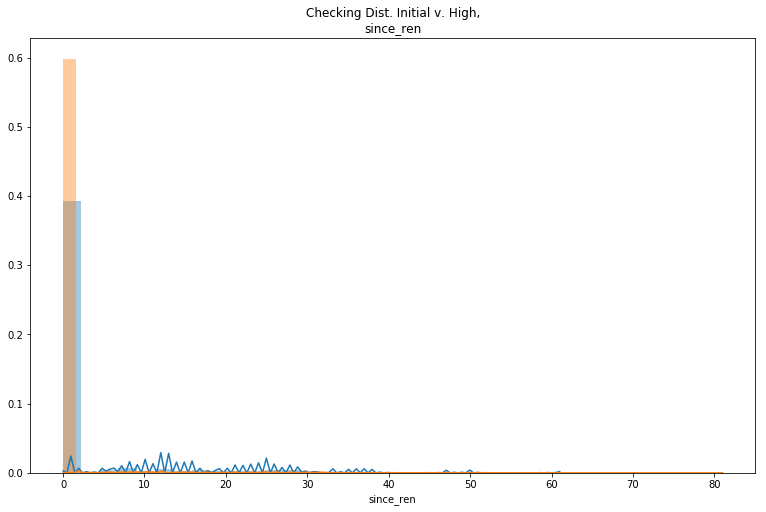

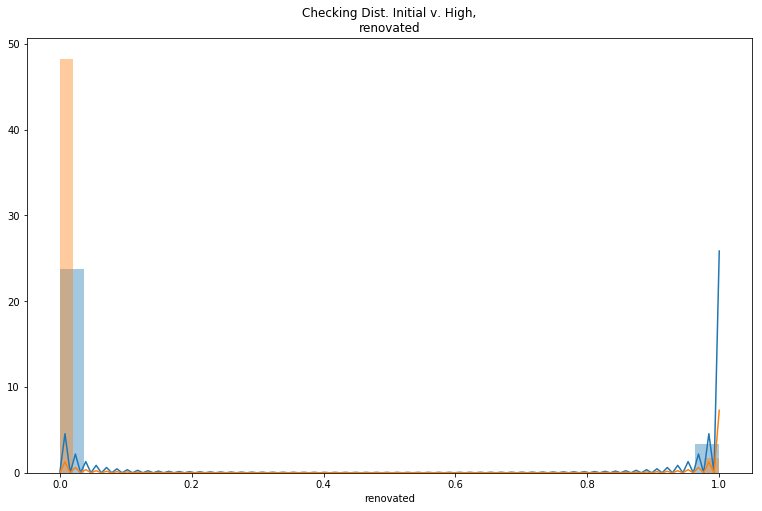

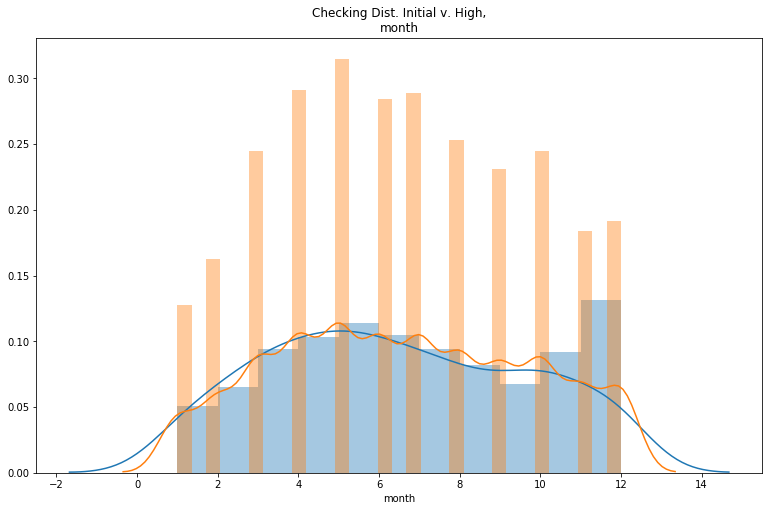

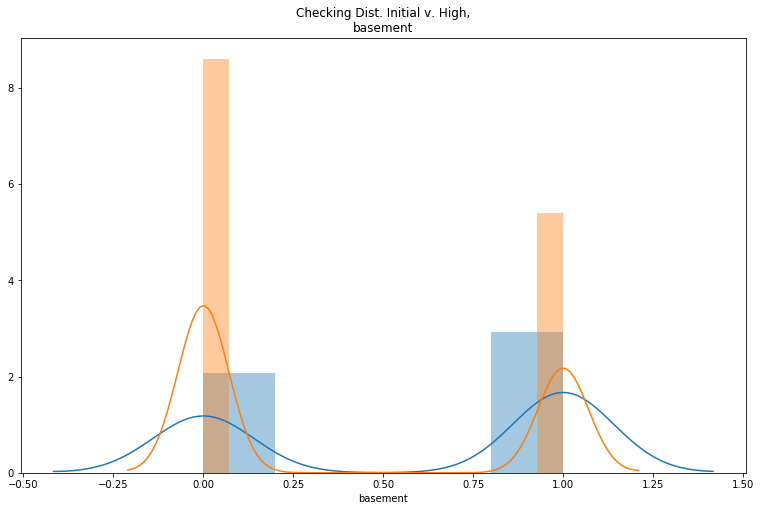

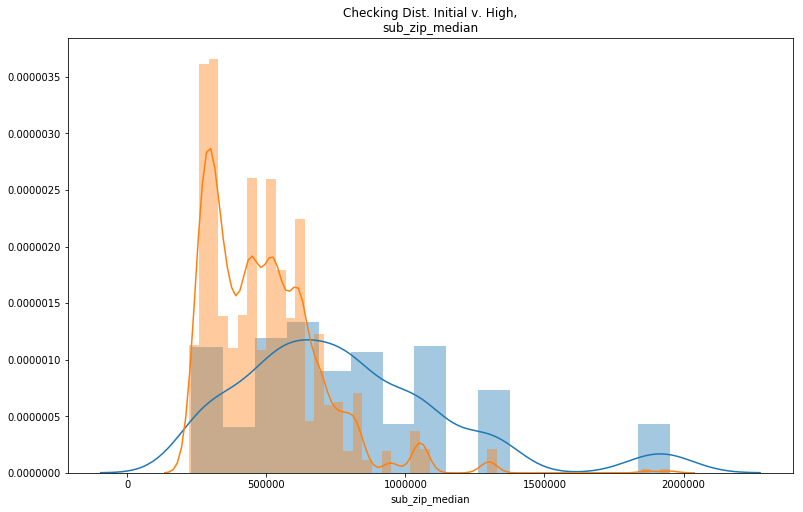

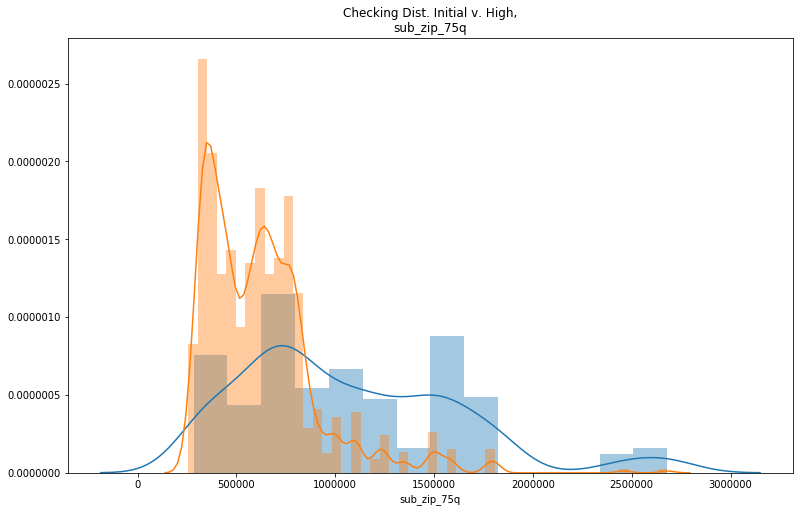

In [245]:
for col in ['price',
'zone_mean', 
'sqft_living',
'grade',
'bedrooms', 
'bathrooms',
'sqft_lot',
'floors',
'waterfront',
'view',
'condition',
'sqft_above',
'sqft_basement',
'yr_built',
'yr_renovated',
'sqft_living15',
'sqft_lot15',
'age',
'since_ren',
'renovated',
'month',
'basement',
'sub_zip_median',
'sub_zip_75q']:
    resd_check(results, data, col)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                 2.471e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        21:09:29   Log-Likelihood:            -2.9609e+05
No. Observations:               21597   AIC:                         5.922e+05
Df Residuals:                   21590   BIC:                         5.922e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
log_sqft_living        1.125e+

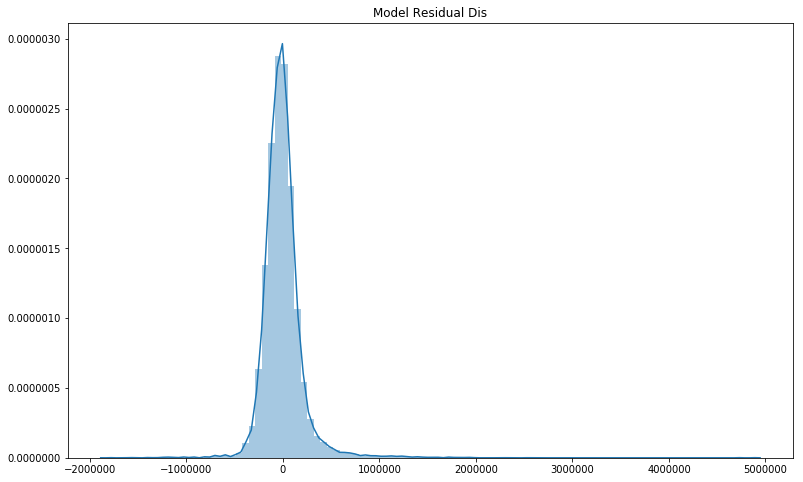

In [246]:
columns= ['log_sqft_living', 'min_max_grade', 'min_max_log_zone_mean', 'waterfront', 'high_grade', 'bin_floors', 'condition']

ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');
data['residual'] = results.resid
keep_data = data.loc[data.residual.abs() <= data.residual.std()*2] # removed anything above 3 std deviation in the residuals. 
removed_data = data.loc[data.residual.abs() > data.residual.std()*2]  

In [281]:
data['lot_living'] = data.sqft_lot15- data.sqft_living15
data.lot_living.loc[data.lot_living <= 0] = 0


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                 2.471e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        21:30:44   Log-Likelihood:            -2.9609e+05
No. Observations:               21597   AIC:                         5.922e+05
Df Residuals:                   21590   BIC:                         5.922e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
log_sqft_living        1.125e+

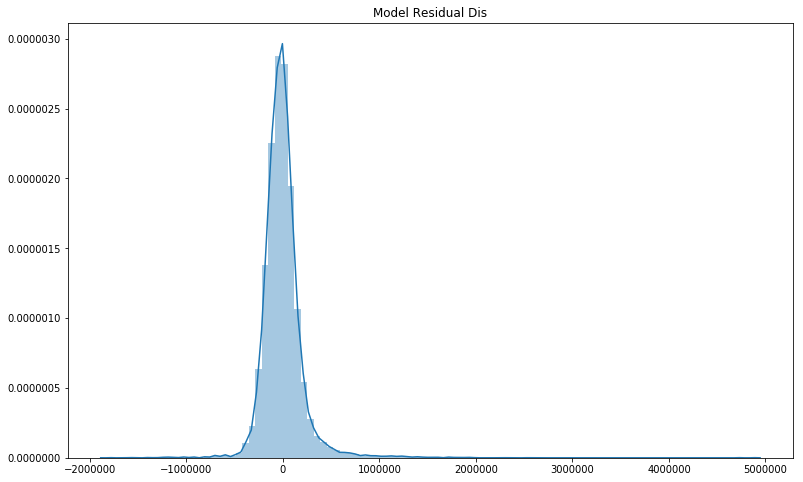

In [282]:
columns= ['log_sqft_living', 'min_max_grade', 'min_max_log_zone_mean', 'waterfront', 'high_grade', 'bin_floors', 'condition']

ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');
data['residual'] = results.resid
keep_data = data.loc[data.residual.abs() <= data.residual.std()*2] # removed anything above 3 std deviation in the residuals. 
removed_data = data.loc[data.residual.abs() > data.residual.std()*2]  

In [308]:
a= data.bin_bathrooms.sort_values()
for i in a.unique():
    print(i)
    print(len(keep_data.bin_bathrooms.loc[data.bin_bathrooms == i])/len(data.bin_bathrooms.loc[data.bin_bathrooms == i]))

(0.0, 1.75]
0.9901518747033697
(1.75, 3.75]
0.9592699929505757
(3.75, 8.0]
0.6169154228855721


#### Using the bin_bathrooms
us

In [316]:
data.bin_bathrooms = data.bin_bathrooms.astype(str)

data.bin_bathrooms.loc[data.bin_bathrooms == '(3.75, 8.0]'] = '0'
data.bin_bathrooms.loc[data.bin_bathrooms == '(0.0, 1.75]'] = '1'
data.bin_bathrooms.loc[data.bin_bathrooms == '(1.75, 3.75]'] = '2'
data.bin_bathrooms = data.bin_bathrooms.astype(int)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                 2.213e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        21:52:00   Log-Likelihood:            -2.9586e+05
No. Observations:               21597   AIC:                         5.917e+05
Df Residuals:                   21589   BIC:                         5.918e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
log_sqft_living        1.214e+

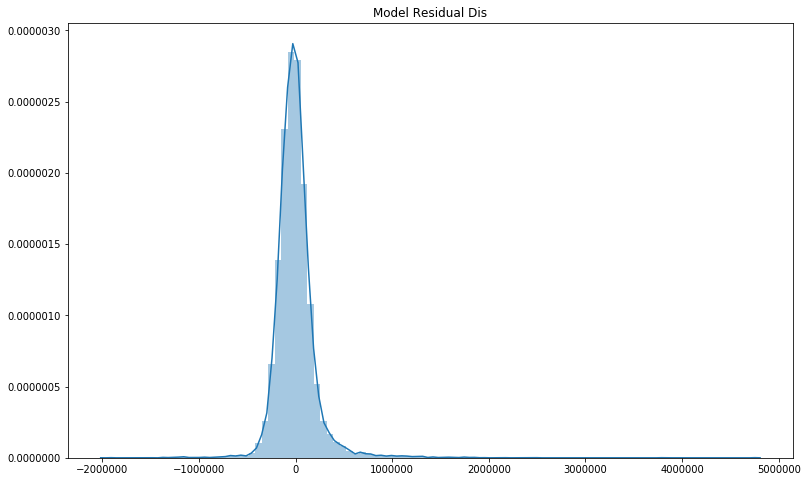

In [317]:
columns= ['log_sqft_living', 'min_max_grade', 'min_max_log_zone_mean', 'waterfront', 'high_grade', 'bin_floors', 'condition', 'bin_bathrooms']

ols, results = make_ols_model(df=data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');
data['residual'] = results.resid
keep_data = data.loc[data.residual.abs() <= data.residual.std()*2] # removed anything above 3 std deviation in the residuals. 
removed_data = data.loc[data.residual.abs() > data.residual.std()*2]  

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                 4.352e+04
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        21:55:31   Log-Likelihood:            -2.7552e+05
No. Observations:               20835   AIC:                         5.510e+05
Df Residuals:                   20827   BIC:                         5.511e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
log_sqft_living         1.71e+

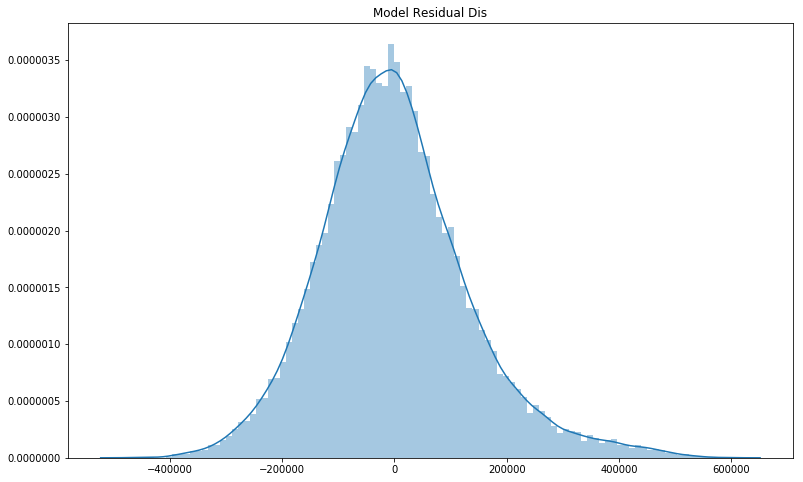

In [319]:


ols, results = make_ols_model(df=keep_data, target='price', columns_to_use=columns, add_constant=False)
plt.figure(figsize= (13,8))
sns.distplot(results.resid, bins=100)
plt.title('Model Residual Dis');

In [320]:
linreg = LinearRegression()

X = keep_data.loc[:,columns]
Y = keep_data.price


cv_5_results = cross_val_score(linreg, X, Y, cv=10, scoring="neg_mean_squared_error")

In [321]:
print(cv_5_results)
print(Y.std(), Y.mean())

[-1.85760235e+10 -1.89809935e+10 -1.78419583e+10 -1.79584915e+10
 -1.72802741e+10 -1.75084290e+10 -1.75090654e+10 -1.89686722e+10
 -1.69587854e+10 -1.78844092e+10]
258796.8683912203 500636.1260859131


In [327]:
linreg.coef()

AttributeError: 'LinearRegression' object has no attribute 'coef'

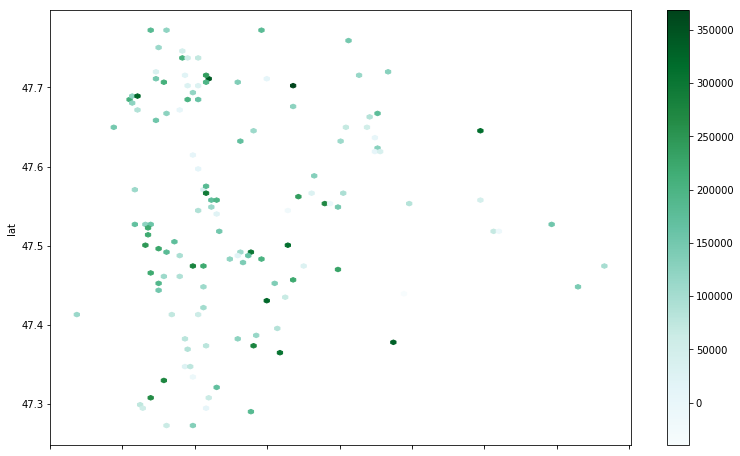

In [147]:
flip.plot.hexbin(figsize= (13,8), x= 'long', y= 'lat', C='change_price')

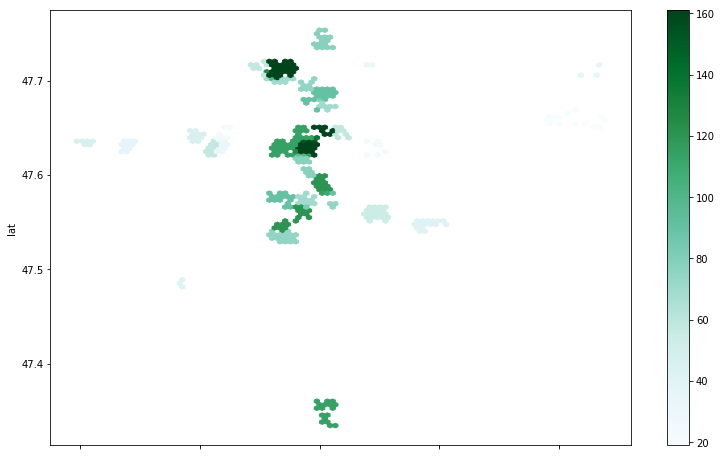

In [148]:
data.loc[data.zone_mean > data.zone_mean.quantile(.95)].plot.hexbin(figsize= (13,8), x= 'long', y= 'lat', C='zone_count')


In [149]:
data.zone_count.value_counts()

78     468
145    435
103    412
55     385
96     384
127    381
93     372
86     344
111    333
51     306
76     304
101    303
75     300
297    297
144    288
70     280
138    276
91     273
68     272
135    270
265    265
132    264
128    256
82     246
122    244
121    242
241    241
119    238
118    236
234    234
      ... 
73      73
24      72
69      69
34      68
32      64
58      58
53      53
52      52
48      48
47      47
43      43
42      42
21      42
20      40
40      40
13      39
19      38
36      36
35      35
30      30
27      27
25      25
12      24
9       18
18      18
17      17
16      16
15      15
6       12
7        7
Name: zone_count, Length: 138, dtype: int64

In [150]:
empty =pd.DataFrame() 

In [151]:

for i in data.bin_lat.unique():
    empty = pd.concat([empty, binning(data.long.loc[data.bin_lat == i],equal_bin10(data.long.loc[data.bin_lat == i]))])


NameError: name 'fObj' is not defined

In [ ]:
empty = empty.astype(str)
empty

### Interpret